# Image preprocessing and Classical Machine Learning Modelling
This notebook will try to solve the classification problem with the use of classical machine learning models. We train, analyze and evaluate the models based on the whole images, on only the lung areas, so called 'regions of interest' (ROI) and on the filtered ROIs.

In [1]:
#Importing libraries

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [12]:
#Showing the number of images
#There are four categories, and each category contains two folders: one with X-ray images and another with masks.

data_path = '../data/raw/' #Change the path to the dataset
categories = ['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

#This code is used to verify the structure of dataset. 

#Initializing lists
category_list = []
images_list = []


#Iterating over categories
for category in categories:
    image_dir = os.path.join(data_path, category)
   
    num_images = len(os.listdir(image_dir)) #Counts the number of the files in images folders
    
    category_list.append(category)
    images_list.append(num_images)
   

data = {'Category': category_list, 'Images': images_list} #Creating a new data frame, dictionary.
df = pd.DataFrame(data)

title = 'Number of Images for each Category'
print(title)
df.head()

Number of Images for each Category


Category  Images
0           Normal       2
1     Lung_Opacity       2
2  Viral Pneumonia       2
3            COVID       2

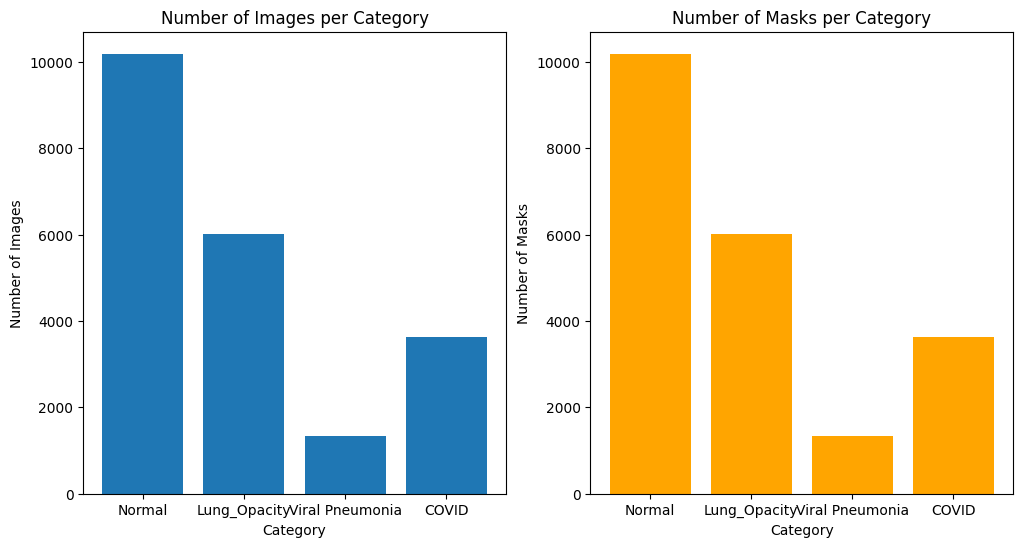

In [13]:
#Visualization

#Counting images per category
image_counts = {category: len(os.listdir(os.path.join(data_path, category, 'images'))) for category in categories}

#Subplots for visualization
fig, axs = plt.subplots(1, 2, figsize = (12, 6));

axs[0].bar(image_counts.keys(), image_counts.values());
axs[0].set_title('Number of Images per Category');
axs[0].set_xlabel('Category');
axs[0].set_ylabel('Number of Images');

#Counting masks per category
mask_counts = {category: len(os.listdir(os.path.join(data_path, category, 'masks'))) for category in categories}

axs[1].bar(mask_counts.keys(), mask_counts.values(), color = 'orange');
axs[1].set_title('Number of Masks per Category');
axs[1].set_xlabel('Category');
axs[1].set_ylabel('Number of Masks');

plt.show();

In [5]:
#Preprocessing
#We are dealing with an imbalanced dataset, since different categories have different numbers of images. 
#Thus it is important to use techniques that will "correct" this imbalance. 
#The imbalanced data containing images could be handeled by:
#1) Flattening the images
#2) Encoding the labels 
#3) Handling imbalance: using techniques such as oversampling, undersampling, and generating synthetic samples.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

#summarize all images:
total_images = sum(images_list)
print("Total number of images in all categories is:", total_images)


Total number of images in all categories is: 21165


In [6]:
#This code converts all images into grayscale images, since not all of them were grayscale
for category in categories:
    image_dir = os.path.join(data_path, category, 'images')
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        with Image.open(image_path) as img:
            mode = img.mode
            if mode != 'L':
                img_gray = img.convert('L')
                img_gray.save(image_path)



non_grayscale_found = False
for category in categories:
    image_dir = os.path.join(data_path, category, 'images')
    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        with Image.open(image_path) as img:
            mode = img.mode
            if mode != 'L':
                non_grayscale_found = True
                print(f" Image {filename} is not grayscale")

if not non_grayscale_found:
    print("All images in all categories are grayscale.")

All images in all categories are grayscale.


In [14]:
from sklearn.utils.class_weight import compute_class_weight

X = []
y = []

for category in categories: #The code iterates through each category in the 'categories' list
    label = categories.index(category) #For each category, the code assigns a label on the index of the category in the list.
    # 0 is for Normal, 1 for Lung_Opacity,...
    
    image_dir = os.path.join('../data/preprocessed/raw', category) #The code constructs the path to the images directory for the current category.

    for filename in os.listdir(image_dir): #The code iterated through each file in the images directory
        #for each image file
        image_path = os.path.join(image_dir, filename)

        with Image.open(image_path) as img: #the image is opened using PIL's Image.open()
            img_array = np.array(img) #the image is converted to a numpy array
            img_array = img_array/255.0 #the pixel values of the image are normalized to the range [0,1]
            img_array = np.expand_dims(img_array, axis = -1)#I added the additional dimension to the image array to indicate 
            #it is a sincgle-channel or grayscale image.

            X.append(img_array)
            y.append(label)

X = np.array(X) #the lists are converted to numpy arrays.
y = np.array(y)

print(f"Shape of X: {X.shape}") # this is a four-dimensional array 
#x represents a batch of 21165 images which height and weight sre 256 each, and each image has channel 1.
print(f"Shape of y: {y.shape}")
#y is a one-dimensional array containing the labels for the images. 


Shape of X: (21165, 256, 256, 1)
Shape of y: (21165,)


In [15]:
#Splitting data to train and test, with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [16]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (16932, 256, 256, 1), (16932,)
Testing set shape: (4233, 256, 256, 1), (4233,)


In [17]:
"""
compute_class_weight is a function from sklearn.utils.class_weight which computes weights associated with classes 
to handle class imbalance.
The values of y are used to automatically adjust weights inversely proportional to class frequencies.
"""
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(f"Shape of X_train_flat: {X_train_flat.shape}")
print(f"Shape of X_test_flat: {X_test_flat.shape}")
#65526 is a product of 256 and 256.

Shape of X_train_flat: (16932, 65536)
Shape of X_test_flat: (4233, 65536)


The class weights are computed to handle class imbalance. They are giving the higher weights to underrepresented classes.
The flattening of images transforms 2D images into 1D arrays.

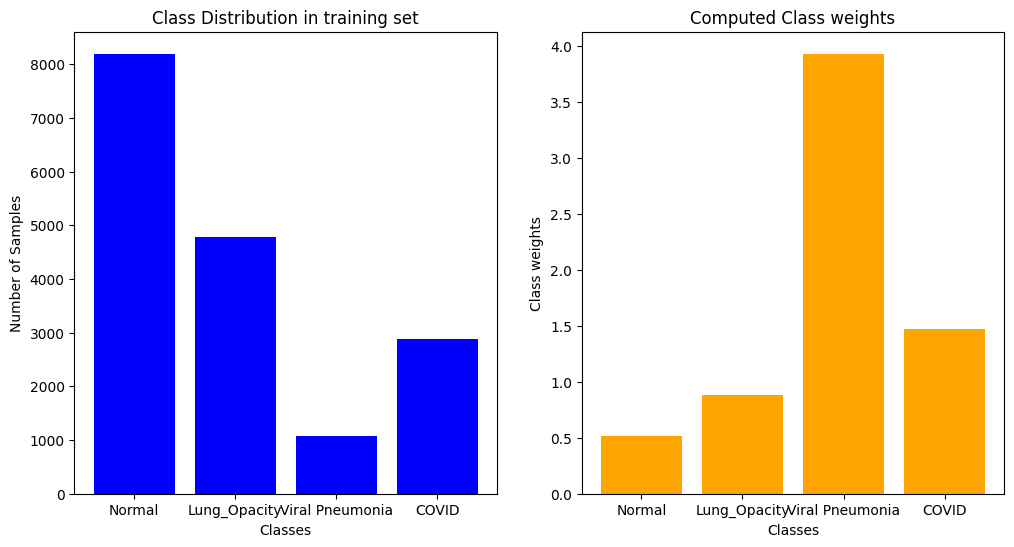

In [18]:
# Data Visualization of class distribution in training set and visualization of computed class weights
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize = (12, 6));
unique, counts = np.unique(y_train, return_counts = True);

axs[0].bar(unique, counts, tick_label = categories, color = 'blue');
axs[0].set_title('Class Distribution in training set');
axs[0].set_xlabel('Classes');
axs[0].set_ylabel('Number of Samples');

axs[1].bar(range(len(class_weights)), class_weights, tick_label = categories, color = 'orange')
axs[1].set_title('Computed Class weights');
axs[1].set_xlabel('Classes');
axs[1].set_ylabel('Class weights');

plt.show();


In [19]:
# It is important to scale the data!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)

Here we are starting the Machine Learning Modelling of the X-ray dataset. To summarize: we calculated the statistical weights and we will implement them into classical models (where it is possible). Before running the models, the images were converted into np.arrays, flattened, the dataset was splitted into training (80%) and testing (20%), and the data was scaled. 

# Machine Learning Modelling

#### We are not going to run all the models again, but only to introduce pickles. However, you can run the models by yourself.
Some pickle files are huge thus we will not upload all of them on github.

## 1. Logistic Regression

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import time
import pandas as pd
import pickle

# Start timing
start_time_lr = time.time()

# Train the Logistic Regression model
clf_lr = LogisticRegression(max_iter=2000, class_weight=class_weights_dict)
clf_lr.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_lr = clf_lr.predict(X_test_flat_scaled)

# Generate classification report
classification_rep = classification_report(y_test, y_pred_lr, target_names=categories)
print(classification_rep)
print("\n")

# Calculate accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy for Logistic Regression is:", accuracy_lr)
print("\n")

# Generate confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_lr_df = pd.DataFrame(cm_lr, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_lr_df)
print("\n")

# End timing
end_time_lr = time.time()
total_time_lr = (end_time_lr - start_time_lr) / 60
formatted_total_time_lr = f"{total_time_lr:.2f}"

print("Total training time is:", formatted_total_time_lr, "minutes")

# Save everything to a pickle file
with open('logistic_regression_results.pkl', 'wb') as file:
    pickle.dump({
        'model': clf_lr,
        'predictions': y_pred_lr,
        'classification_report': classification_rep,
        'accuracy': accuracy_lr,
        'confusion_matrix': cm_lr,
        'conf_matrix_df': conf_matrix_lr_df,
        'total_training_time': formatted_total_time_lr
    }, file)
    print('All important objects saved to logistic_regression_results.pkl')


                 precision    recall  f1-score   support

         Normal       0.77      0.78      0.78      1995
   Lung_Opacity       0.70      0.67      0.69      1225
Viral Pneumonia       0.75      0.79      0.77       268
          COVID       0.69      0.70      0.69       745

       accuracy                           0.74      4233
      macro avg       0.73      0.74      0.73      4233
   weighted avg       0.74      0.74      0.74      4233



Accuracy for Logistic Regression is: 0.7363571934798016


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1559                     262   
Real Lung_Opacity                  303                     825   
Real Viral Pneumonia                19                      17   
Real COVID                         134                      73   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  39              135  
Real Lung_Opacit

In [15]:
import pickle

# Load the objects from the pickle file
with open('logistic_regression_results.pkl', 'rb') as file:
    results = pickle.load(file)
    clf_lr = results['model']
    y_pred_lr = results['predictions']
    classification_rep = results['classification_report']
    accuracy_lr = results['accuracy']
    cm_lr = results['confusion_matrix']
    conf_matrix_lr_df = results['conf_matrix_df']
    formatted_total_time_lr = results['total_training_time']

print("Loaded model and results from logistic_regression_results.pkl")

# Print the loaded results
print(classification_rep)
print("\n")
print("Accuracy for Logistic Regression is:", accuracy_lr)
print("\n")
print(conf_matrix_lr_df)
print("\n")
print("Total training time is:", formatted_total_time_lr, "minutes")


Loaded model and results from logistic_regression_results.pkl
                 precision    recall  f1-score   support

         Normal       0.77      0.78      0.78      1995
   Lung_Opacity       0.70      0.67      0.69      1225
Viral Pneumonia       0.75      0.79      0.77       268
          COVID       0.69      0.70      0.69       745

       accuracy                           0.74      4233
      macro avg       0.73      0.74      0.73      4233
   weighted avg       0.74      0.74      0.74      4233



Accuracy for Logistic Regression is: 0.7363571934798016


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1559                     262   
Real Lung_Opacity                  303                     825   
Real Viral Pneumonia                19                      17   
Real COVID                         134                      73   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal          

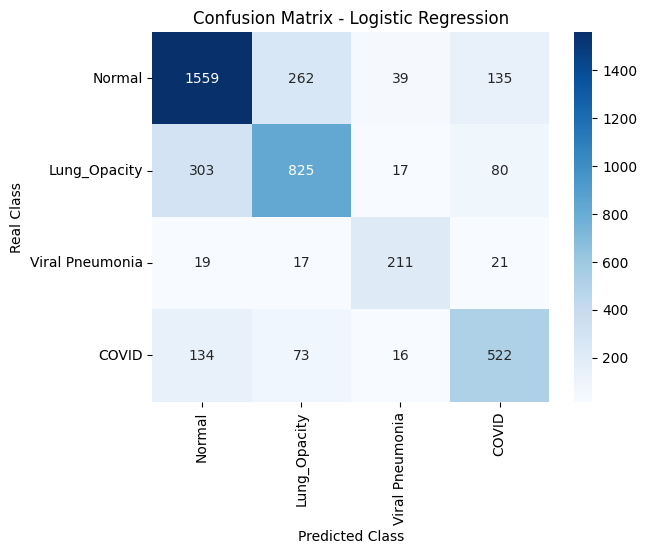

In [42]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

## 2. Support Vector Machine

In [43]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import pickle
import time

# Start timing
start_time_svc = time.time()

# Train the SVM model
clf_svc = SVC(kernel='linear', class_weight=class_weights_dict)
clf_svc.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_svc = clf_svc.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_svc = classification_report(y_test, y_pred_svc, target_names=categories)
print(classification_rep_svc)
print("\n")

# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print("Accuracy score for Support Vector Machine is:", accuracy_svc)
print("\n")

# Generate confusion matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
conf_matrix_svc_df = pd.DataFrame(cm_svc, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_svc_df)
print("\n")

# End timing
end_time_svc = time.time()
total_time_svc = (end_time_svc - start_time_svc) / 60
formatted_total_time_svc = f"{total_time_svc:.2f}"
print("Total training time is:", formatted_total_time_svc, "minutes.")

# Save everything to a pickle file
with open('svc_results.pkl', 'wb') as file:
    pickle.dump({
        'model': clf_svc,
        'predictions': y_pred_svc,
        'classification_report': classification_rep_svc,
        'accuracy': accuracy_svc,
        'confusion_matrix': cm_svc,
        'conf_matrix_df': conf_matrix_svc_df,
        'total_training_time': formatted_total_time_svc
    }, file)
    print('All important objects saved to svc_results.pkl')



                 precision    recall  f1-score   support

         Normal       0.76      0.81      0.79      1995
   Lung_Opacity       0.72      0.68      0.70      1225
Viral Pneumonia       0.88      0.85      0.87       268
          COVID       0.75      0.69      0.72       745

       accuracy                           0.76      4233
      macro avg       0.78      0.76      0.77      4233
   weighted avg       0.75      0.76      0.75      4233



Accuracy score for Support Vector Machine is: 0.755256319395228


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1619                     252   
Real Lung_Opacity                  329                     835   
Real Viral Pneumonia                26                       4   
Real COVID                         149                      74   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  21              103  
Real Lun

In [16]:
import pickle

# Load the objects from the pickle file
with open('svc_results.pkl', 'rb') as file:
    results_svc = pickle.load(file)
    clf_svc = results_svc['model']
    y_pred_svc = results_svc['predictions']
    classification_rep_svc = results_svc['classification_report']
    accuracy_svc = results_svc['accuracy']
    cm_svc = results_svc['confusion_matrix']
    conf_matrix_svc_df = results_svc['conf_matrix_df']
    formatted_total_time_svc = results_svc['total_training_time']

print("Loaded model and results from svc_results.pkl")

# Print the loaded results
print(classification_rep_svc)
print("\n")
print("Accuracy score for Support Vector Machine is:", accuracy_svc)
print("\n")
print(conf_matrix_svc_df)
print("\n")
print("Total training time is:", formatted_total_time_svc, "minutes")


Loaded model and results from svc_results.pkl
                 precision    recall  f1-score   support

         Normal       0.76      0.81      0.79      1995
   Lung_Opacity       0.72      0.68      0.70      1225
Viral Pneumonia       0.88      0.85      0.87       268
          COVID       0.75      0.69      0.72       745

       accuracy                           0.76      4233
      macro avg       0.78      0.76      0.77      4233
   weighted avg       0.75      0.76      0.75      4233



Accuracy score for Support Vector Machine is: 0.755256319395228


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1619                     252   
Real Lung_Opacity                  329                     835   
Real Viral Pneumonia                26                       4   
Real COVID                         149                      74   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                  

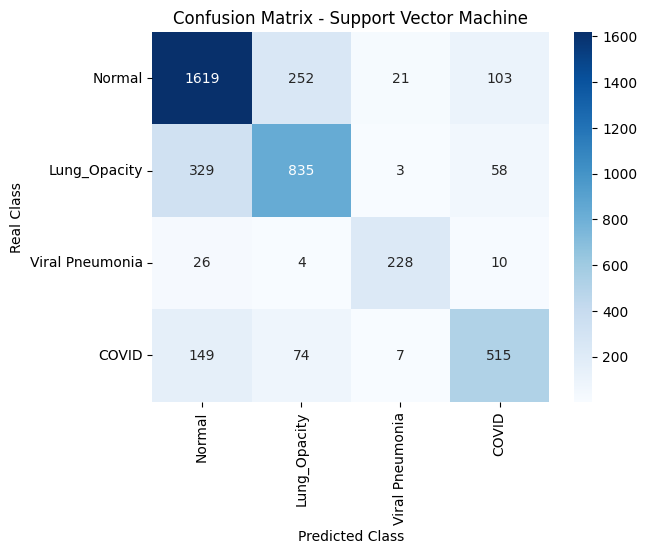

In [45]:
sns.heatmap(confusion_matrix(y_test, y_pred_svc), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Support Vector Machine')
plt.show()

## 3. Random Forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import pickle
import time

# Start timing
start_time_rf = time.time()

# Train the Random Forest model
clf_rf = RandomForestClassifier(n_estimators=100, class_weight=class_weights_dict, random_state=123)
clf_rf.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_rf = clf_rf.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_rf = classification_report(y_test, y_pred_rf, target_names=categories)
print(classification_rep_rf)
print("\n")

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy score for Random Forest is:", accuracy_rf)
print("\n")

# Generate confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_rf_df = pd.DataFrame(cm_rf, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_rf_df)
print("\n")

# End timing
end_time_rf = time.time()
total_time_rf = (end_time_rf - start_time_rf) / 60
formatted_total_time_rf = f"{total_time_rf:.2f}"
print("Total training time is:", formatted_total_time_rf, "minutes.")

# Save everything to a pickle file
with open('rf_results.pkl', 'wb') as file:
    pickle.dump({
        'model': clf_rf,
        'predictions': y_pred_rf,
        'classification_report': classification_rep_rf,
        'accuracy': accuracy_rf,
        'confusion_matrix': cm_rf,
        'conf_matrix_df': conf_matrix_rf_df,
        'total_training_time': formatted_total_time_rf
    }, file)
    print('All important objects saved to rf_results.pkl')


                 precision    recall  f1-score   support

         Normal       0.81      0.91      0.86      1995
   Lung_Opacity       0.83      0.77      0.80      1225
Viral Pneumonia       0.93      0.80      0.86       268
          COVID       0.91      0.76      0.83       745

       accuracy                           0.84      4233
      macro avg       0.87      0.81      0.84      4233
   weighted avg       0.84      0.84      0.84      4233



Accuracy score for Random Forest is: 0.83723127805339


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1822                     135   
Real Lung_Opacity                  257                     940   
Real Viral Pneumonia                41                       9   
Real COVID                         125                      51   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  12               26  
Real Lung_Opacity 

In [18]:
import pickle

# Load the objects from the pickle file
with open('rf_results.pkl', 'rb') as file:
    results_rf = pickle.load(file)
    clf_rf = results_rf['model']
    y_pred_rf = results_rf['predictions']
    classification_rep_rf = results_rf['classification_report']
    accuracy_rf = results_rf['accuracy']
    cm_rf = results_rf['confusion_matrix']
    conf_matrix_rf_df = results_rf['conf_matrix_df']
    formatted_total_time_rf = results_rf['total_training_time']

print("Loaded model and results from rf_results.pkl")

# Print the loaded results
print(classification_rep_rf)
print("\n")
print("Accuracy score for Random Forest is:", accuracy_rf)
print("\n")
print(conf_matrix_rf_df)
print("\n")
print("Total training time is:", formatted_total_time_rf, "minutes")


Loaded model and results from rf_results.pkl
                 precision    recall  f1-score   support

         Normal       0.81      0.91      0.86      1995
   Lung_Opacity       0.83      0.77      0.80      1225
Viral Pneumonia       0.93      0.80      0.86       268
          COVID       0.91      0.76      0.83       745

       accuracy                           0.84      4233
      macro avg       0.87      0.81      0.84      4233
   weighted avg       0.84      0.84      0.84      4233



Accuracy score for Random Forest is: 0.83723127805339


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1822                     135   
Real Lung_Opacity                  257                     940   
Real Viral Pneumonia                41                       9   
Real COVID                         125                      51   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                             

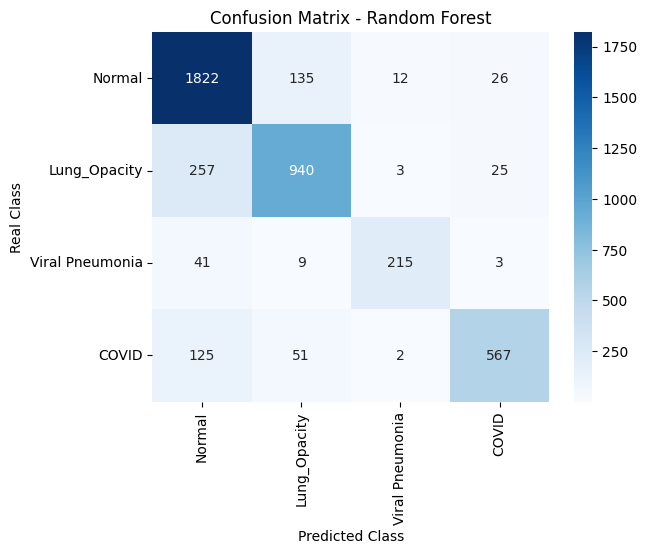

In [48]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Random Forest')
plt.show()

## 4. K Neighbors

#### 4.1. Optimization

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import pickle

start_time_finding_best_params = time.time()

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 51))
}

# Perform grid search
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_flat_scaled, y_train)

# Get best parameters and score
best_n_neighbors = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

print(f"Best number of neighbors: {best_n_neighbors}")
print(f"Best cross-validated score: {best_score:.4f}")

# Save the best model to a pickle file
best_model = grid_search.best_estimator_
with open('best_knn_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
    print('Best model saved to best_knn_model.pkl')

# Save grid search results for further analysis
results = grid_search.cv_results_
mean_test_scores = results['mean_test_score']
param_n_neighbors = param_grid['n_neighbors']

with open('grid_search_results.pkl', 'wb') as file:
    pickle.dump({
        'param_grid': param_grid,
        'results': results,
        'mean_test_scores': mean_test_scores,
        'param_n_neighbors': param_n_neighbors,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }, file)
    print('Grid search results saved to grid_search_results.pkl')

end_time_finding_best_params = time.time()
total_time_finding_best_params = (end_time_finding_best_params - start_time_finding_best_params) / 60
formatted_total_time_finding_best_params = f"{total_time_finding_best_params:.2f}"
print("Time needed to find the best number of neighbors is:", formatted_total_time_finding_best_params, "minutes.")


Best number of neighbors: 7
Best cross-validated score: 0.7885
Time needed to find the best number of neighbors is: 768.98 minutes.


In [ ]:
import pickle

# Load the best model
with open('best_knn_model.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Load grid search results
with open('grid_search_results.pkl', 'rb') as file:
    grid_search_results = pickle.load(file)

# Access the saved data
best_params_loaded = grid_search_results['best_params']
best_score_loaded = grid_search_results['best_score']
mean_test_scores_loaded = grid_search_results['mean_test_scores']
param_n_neighbors_loaded = grid_search_results['param_n_neighbors']

print("Best parameters loaded:", best_params_loaded)
print("Best score loaded:", best_score_loaded)

y_pred_best_model = best_model.predict(X_test_flat_scaled)
print(classification_report(y_test, y_pred_best_model, target_names=categories))


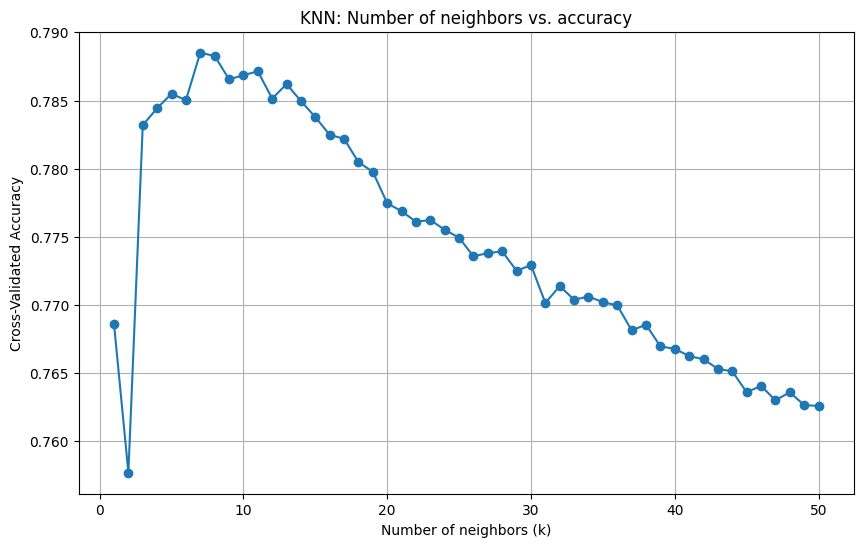

In [45]:
plt.figure(figsize = (10, 6))
plt.plot(param_n_neighbors, mean_test_scores, marker = 'o')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN: Number of neighbors vs. accuracy')
plt.grid(True)
plt.show()

#### 4.2. Training

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import pickle
import time

# Assuming you have already determined the best_n_neighbors variable from previous steps
best_n_neighbors = 7

start_time_knn = time.time()

# Initialize and fit the KNN classifier with the best number of neighbors
best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
best_knn.fit(X_train_flat_scaled, y_train)

# Make predictions and evaluate the optimized KNN classifier
y_pred_knn_best = best_knn.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_knn = classification_report(y_test, y_pred_knn_best, target_names=categories)
print("Optimized KNN Classification Report")
print(classification_rep_knn)
print("\n")

# Calculate accuracy
accuracy_knn_best = accuracy_score(y_test, y_pred_knn_best)
print(f"Optimized KNN accuracy score is: {accuracy_knn_best:.4f}")
print("\n")

# Generate confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn_best)
conf_matrix_knn_df = pd.DataFrame(cm_knn, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_knn_df)
print("\n")

# End timing
end_time_knn = time.time()
total_time_knn = (end_time_knn - start_time_knn) / 60
formatted_total_time_knn = f"{total_time_knn:.2f}"
print("Total training time is:", formatted_total_time_knn, "minutes")

# Save everything to a pickle file
with open('knn_results.pkl', 'wb') as file:
    pickle.dump({
        'model': best_knn,
        'predictions': y_pred_knn_best,
        'classification_report': classification_rep_knn,
        'accuracy': accuracy_knn_best,
        'confusion_matrix': cm_knn,
        'conf_matrix_df': conf_matrix_knn_df,
        'total_training_time': formatted_total_time_knn
    }, file)
    print('All important objects saved to knn_results.pkl')


Optimized KNN Classification Report
                 precision    recall  f1-score   support

         Normal       0.79      0.88      0.83      1995
   Lung_Opacity       0.74      0.74      0.74      1225
Viral Pneumonia       0.88      0.89      0.89       268
          COVID       0.81      0.57      0.67       745

       accuracy                           0.79      4233
      macro avg       0.80      0.77      0.78      4233
   weighted avg       0.79      0.79      0.78      4233



Optimized KNN accuracy score is: 0.7850


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1755                     158   
Real Lung_Opacity                  273                     908   
Real Viral Pneumonia                15                      10   
Real COVID                         168                     153   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  30               5

In [20]:
import pickle

# Load the objects from the pickle file
with open('knn_results.pkl', 'rb') as file:
    results_knn = pickle.load(file)
    best_knn = results_knn['model']
    y_pred_knn_best = results_knn['predictions']
    classification_rep_knn = results_knn['classification_report']
    accuracy_knn_best = results_knn['accuracy']
    cm_knn = results_knn['confusion_matrix']
    conf_matrix_knn_df = results_knn['conf_matrix_df']
    formatted_total_time_knn = results_knn['total_training_time']

print("Loaded model and results from knn_results.pkl")

# Print the loaded results
print(classification_rep_knn)
print("\n")
print(f"Optimized KNN accuracy score is: {accuracy_knn_best:.4f}")
print("\n")
print(conf_matrix_knn_df)
print("\n")
print("Total training time is:", formatted_total_time_knn, "minutes")

Loaded model and results from knn_results.pkl
                 precision    recall  f1-score   support

         Normal       0.79      0.88      0.83      1995
   Lung_Opacity       0.74      0.74      0.74      1225
Viral Pneumonia       0.88      0.89      0.89       268
          COVID       0.81      0.57      0.67       745

       accuracy                           0.79      4233
      macro avg       0.80      0.77      0.78      4233
   weighted avg       0.79      0.79      0.78      4233



Optimized KNN accuracy score is: 0.7850


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1755                     158   
Real Lung_Opacity                  273                     908   
Real Viral Pneumonia                15                      10   
Real COVID                         168                     153   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  30      

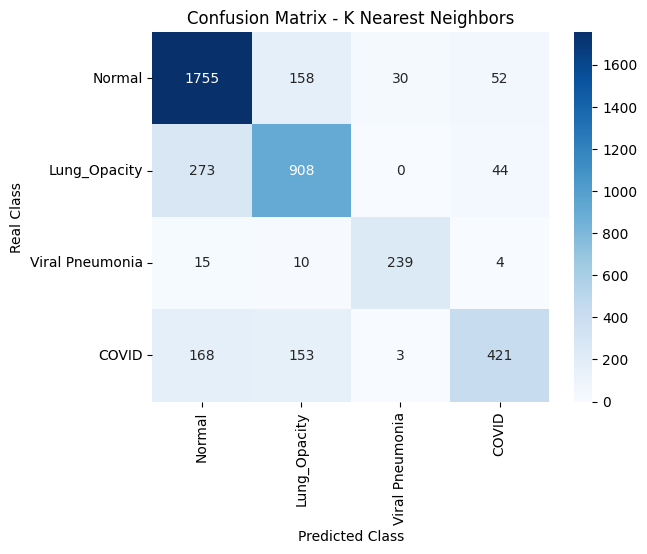

In [53]:
sns.heatmap(confusion_matrix(y_test, y_pred_knn_best), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - K Nearest Neighbors')
plt.show()

## 5. Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import pickle
import time

start_time_dt = time.time()

# Train the Decision Tree model
dt = DecisionTreeClassifier(class_weight=class_weights_dict, random_state=123)
dt.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_dt = dt.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_dt = classification_report(y_test, y_pred_dt, target_names=categories)
print("Decision Tree Classification Report")
print(classification_rep_dt)
print("\n")

# Calculate accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy score for Decision Tree is:", accuracy_dt)
print("\n")

# Generate confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
conf_matrix_dt_df = pd.DataFrame(cm_dt, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_dt_df)
print("\n")

# End timing
end_time_dt = time.time()
total_time_dt = (end_time_dt - start_time_dt) / 60
formatted_total_time_dt = f"{total_time_dt:.2f}"
print("Total training time is:", formatted_total_time_dt, "minutes")

# Save everything to a pickle file
with open('dt_results.pkl', 'wb') as file:
    pickle.dump({
        'model': dt,
        'predictions': y_pred_dt,
        'classification_report': classification_rep_dt,
        'accuracy': accuracy_dt,
        'confusion_matrix': cm_dt,
        'conf_matrix_df': conf_matrix_dt_df,
        'total_training_time': formatted_total_time_dt
    }, file)
    print('All important objects saved to dt_results.pkl')



Decision Tree Classification Report
                 precision    recall  f1-score   support

         Normal       0.75      0.75      0.75      1995
   Lung_Opacity       0.64      0.65      0.64      1225
Viral Pneumonia       0.69      0.71      0.70       268
          COVID       0.69      0.66      0.68       745

       accuracy                           0.70      4233
      macro avg       0.69      0.69      0.69      4233
   weighted avg       0.70      0.70      0.70      4233



Accuracy score for Decision Tree is: 0.7039924403496338


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1505                     327   
Real Lung_Opacity                  315                     792   
Real Viral Pneumonia                46                      17   
Real COVID                         133                     107   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  58

In [22]:
import pickle

# Load the objects from the pickle file
with open('dt_results.pkl', 'rb') as file:
    results_dt = pickle.load(file)
    dt = results_dt['model']
    y_pred_dt = results_dt['predictions']
    classification_rep_dt = results_dt['classification_report']
    accuracy_dt = results_dt['accuracy']
    cm_dt = results_dt['confusion_matrix']
    conf_matrix_dt_df = results_dt['conf_matrix_df']
    formatted_total_time_dt = results_dt['total_training_time']

print("Loaded model and results from dt_results.pkl")

# Print the loaded results
print(classification_rep_dt)
print("\n")
print(f"Accuracy score for Decision Tree is: {accuracy_dt:.4f}")
print("\n")
print(conf_matrix_dt_df)
print("\n")
print("Total training time is:", formatted_total_time_dt, "minutes")


Loaded model and results from dt_results.pkl
                 precision    recall  f1-score   support

         Normal       0.75      0.75      0.75      1995
   Lung_Opacity       0.64      0.65      0.64      1225
Viral Pneumonia       0.69      0.71      0.70       268
          COVID       0.69      0.66      0.68       745

       accuracy                           0.70      4233
      macro avg       0.69      0.69      0.69      4233
   weighted avg       0.70      0.70      0.70      4233



Accuracy score for Decision Tree is: 0.7040


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1505                     327   
Real Lung_Opacity                  315                     792   
Real Viral Pneumonia                46                      17   
Real COVID                         133                     107   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  58   

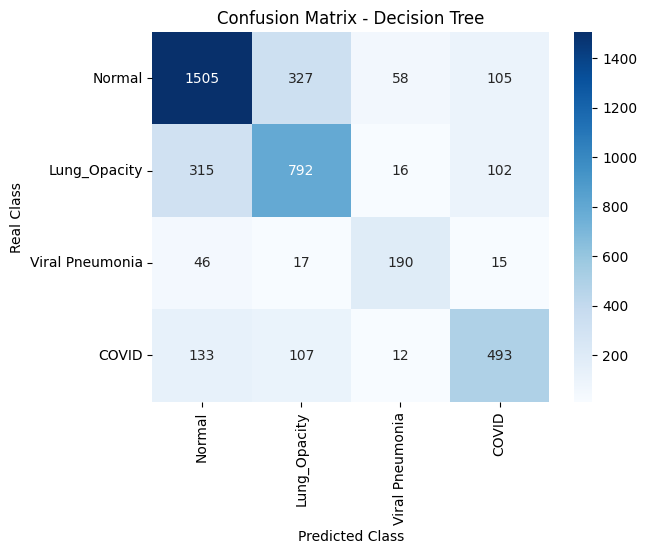

In [56]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

## 6. Bagging with Random Forest

In [13]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import pickle
import time

start_time_bagging = time.time()

# Train the Bagging classifier
bagging = BaggingClassifier(estimator=RandomForestClassifier(class_weight=class_weights_dict), n_estimators=100, random_state=123)
bagging.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_bagging = bagging.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_bagging = classification_report(y_test, y_pred_bagging, target_names=categories)
print("Bagging Classification Report")
print(classification_rep_bagging)
print("\n")

# Calculate accuracy
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy score for Bagging is:", accuracy_bagging)
print("\n")

# Generate confusion matrix
cm_bagging = confusion_matrix(y_test, y_pred_bagging)
conf_matrix_bagging_df = pd.DataFrame(cm_bagging, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_bagging_df)
print("\n")

# End timing
end_time_bagging = time.time()
total_time_bagging = (end_time_bagging - start_time_bagging) / 60
formatted_total_time_bagging = f"{total_time_bagging:.2f}"
print("Total training time is:", formatted_total_time_bagging, "minutes.")

# Save everything to a pickle file
with open('bagging_results.pkl', 'wb') as file:
    pickle.dump({
        'model': bagging,
        'predictions': y_pred_bagging,
        'classification_report': classification_rep_bagging,
        'accuracy': accuracy_bagging,
        'confusion_matrix': cm_bagging,
        'conf_matrix_df': conf_matrix_bagging_df,
        'total_training_time': formatted_total_time_bagging
    }, file)
    print('All important objects saved to bagging_results.pkl')


Bagging Classification Report
                 precision    recall  f1-score   support

         Normal       0.80      0.91      0.85      1995
   Lung_Opacity       0.81      0.76      0.78      1225
Viral Pneumonia       0.92      0.76      0.84       268
          COVID       0.91      0.73      0.81       745

       accuracy                           0.82      4233
      macro avg       0.86      0.79      0.82      4233
   weighted avg       0.83      0.82      0.82      4233



Accuracy score for Bagging is: 0.8249468462083629


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1816                     140   
Real Lung_Opacity                  273                     926   
Real Viral Pneumonia                43                      14   
Real COVID                         141                      57   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  14            

In [14]:
import pickle

# Load the objects from the pickle file
with open('bagging_results.pkl', 'rb') as file:
    results_bagging = pickle.load(file)
    bagging = results_bagging['model']
    y_pred_bagging = results_bagging['predictions']
    classification_rep_bagging = results_bagging['classification_report']
    accuracy_bagging = results_bagging['accuracy']
    cm_bagging = results_bagging['confusion_matrix']
    conf_matrix_bagging_df = results_bagging['conf_matrix_df']
    formatted_total_time_bagging = results_bagging['total_training_time']

print("Loaded model and results from bagging_results.pkl")

# Print the loaded results
print(classification_rep_bagging)
print("\n")
print(f"Accuracy score for Bagging is: {accuracy_bagging:.4f}")
print("\n")
print(conf_matrix_bagging_df)
print("\n")
print("Total training time is:", formatted_total_time_bagging, "minutes")


Loaded model and results from bagging_results.pkl
                 precision    recall  f1-score   support

         Normal       0.80      0.91      0.85      1995
   Lung_Opacity       0.81      0.76      0.78      1225
Viral Pneumonia       0.92      0.76      0.84       268
          COVID       0.91      0.73      0.81       745

       accuracy                           0.82      4233
      macro avg       0.86      0.79      0.82      4233
   weighted avg       0.83      0.82      0.82      4233



Accuracy score for Bagging is: 0.8249


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1816                     140   
Real Lung_Opacity                  273                     926   
Real Viral Pneumonia                43                      14   
Real COVID                         141                      57   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  14    

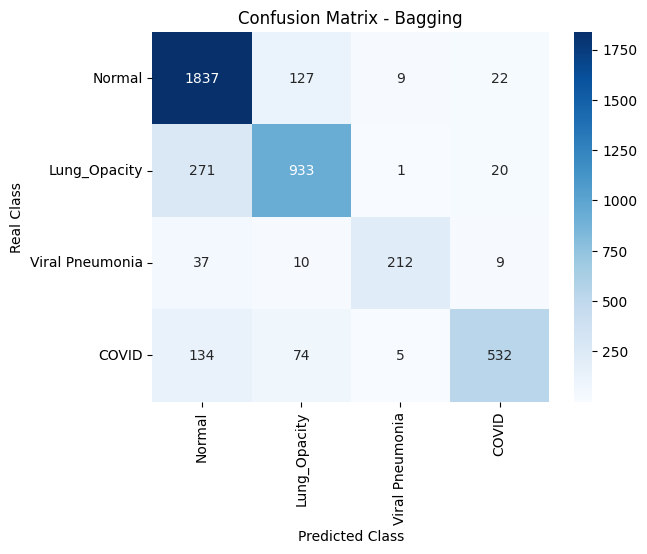

In [39]:
sns.heatmap(confusion_matrix(y_test, y_pred_bagging), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Bagging')
plt.show()

## 7. Boosting - AdaBoost

In [57]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import pickle
import time

start_time_abc = time.time()

# Train the AdaBoost classifier
adaboost = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=123)
adaboost.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_adaboost = adaboost.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_adaboost = classification_report(y_test, y_pred_adaboost, target_names=categories)
print("AdaBoost Classification Report")
print(classification_rep_adaboost)
print("\n")

# Calculate accuracy
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("Accuracy score for AdaBoost is:", accuracy_adaboost)
print("\n")

# Generate confusion matrix
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)
conf_matrix_adaboost_df = pd.DataFrame(cm_adaboost, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_adaboost_df)
print("\n")

# End timing
end_time_abc = time.time()
total_time_abc = (end_time_abc - start_time_abc) / 60
formatted_total_time_adaboost = f"{total_time_abc:.2f}"
print("Total training time is:", formatted_total_time_adaboost, "minutes.")

# Save everything to a pickle file
with open('adaboost_results.pkl', 'wb') as file:
    pickle.dump({
        'model': adaboost,
        'predictions': y_pred_adaboost,
        'classification_report': classification_rep_adaboost,
        'accuracy': accuracy_adaboost,
        'confusion_matrix': cm_adaboost,
        'conf_matrix_df': conf_matrix_adaboost_df,
        'total_training_time': formatted_total_time_adaboost
    }, file)
    print('All important objects saved to adaboost_results.pkl')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classification Report
                 precision    recall  f1-score   support

         Normal       0.76      0.76      0.76      1995
   Lung_Opacity       0.66      0.68      0.67      1225
Viral Pneumonia       0.67      0.62      0.65       268
          COVID       0.67      0.66      0.66       745

       accuracy                           0.71      4233
      macro avg       0.69      0.68      0.69      4233
   weighted avg       0.71      0.71      0.71      4233



Accuracy score for AdaBoost is: 0.7113158516418616


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1526                     293   
Real Lung_Opacity                  290                     830   
Real Viral Pneumonia                58                      24   
Real COVID                         126                     114   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  52          

In [24]:
import pickle

# Load the objects from the pickle file
with open('adaboost_results.pkl', 'rb') as file:
    results_adaboost = pickle.load(file)
    adaboost = results_adaboost['model']
    y_pred_adaboost = results_adaboost['predictions']
    classification_rep_adaboost = results_adaboost['classification_report']
    accuracy_adaboost = results_adaboost['accuracy']
    cm_adaboost = results_adaboost['confusion_matrix']
    conf_matrix_adaboost_df = results_adaboost['conf_matrix_df']
    formatted_total_time_adaboost = results_adaboost['total_training_time']

print("Loaded model and results from adaboost_results.pkl")

# Print the loaded results
print(classification_rep_adaboost)
print("\n")
print(f"Accuracy score for AdaBoost is: {accuracy_adaboost:.4f}")
print("\n")
print(conf_matrix_adaboost_df)
print("\n")
print("Total training time is:", formatted_total_time_adaboost, "minutes")


Loaded model and results from adaboost_results.pkl
                 precision    recall  f1-score   support

         Normal       0.76      0.76      0.76      1995
   Lung_Opacity       0.66      0.68      0.67      1225
Viral Pneumonia       0.67      0.62      0.65       268
          COVID       0.67      0.66      0.66       745

       accuracy                           0.71      4233
      macro avg       0.69      0.68      0.69      4233
   weighted avg       0.71      0.71      0.71      4233



Accuracy score for AdaBoost is: 0.7113


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1526                     293   
Real Lung_Opacity                  290                     830   
Real Viral Pneumonia                58                      24   
Real COVID                         126                     114   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                  52  

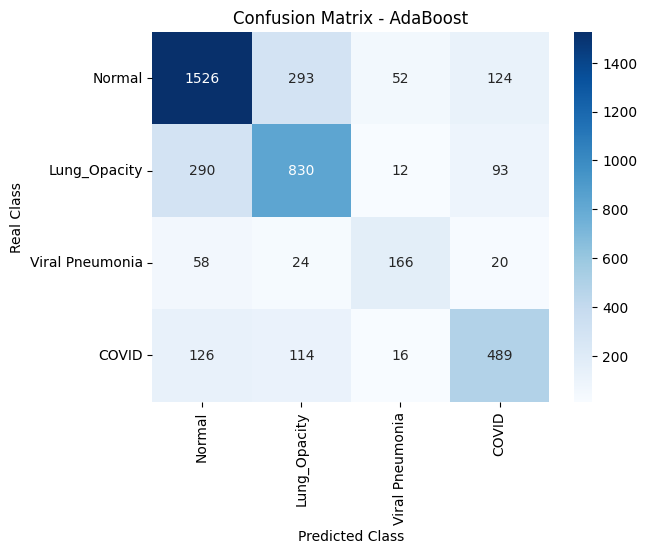

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

## 8. XG Boost

In [8]:
import time
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

start_time_xgb = time.time()

# Train the XGBoost classifier
xgboost = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=123)
xgboost.fit(X_train_flat_scaled, y_train)

# Make predictions
y_pred_xgboost = xgboost.predict(X_test_flat_scaled)

# Generate classification report
classification_rep_xgboost = classification_report(y_test, y_pred_xgboost, target_names=categories)
print("XGBoost Classification Report")
print(classification_rep_xgboost)
print("\n")

# Calculate accuracy
accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
print("Accuracy score for XGBoost is:", accuracy_xgboost)
print("\n")

# Generate confusion matrix
cm_xgboost = confusion_matrix(y_test, y_pred_xgboost)
conf_matrix_xgboost_df = pd.DataFrame(cm_xgboost, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_xgboost_df)
print("\n")

# End timing
end_time_xgb = time.time()
total_time_xgb = (end_time_xgb - start_time_xgb) / 60
formatted_total_time_xgboost = f"{total_time_xgb:.2f}"
print("Total training time is:", formatted_total_time_xgboost, "minutes.")

# Save everything to a pickle file
with open('xgboost_results.pkl', 'wb') as file:
    pickle.dump({
        'model': xgboost,
        'predictions': y_pred_xgboost,
        'classification_report': classification_rep_xgboost,
        'accuracy': accuracy_xgboost,
        'confusion_matrix': cm_xgboost,
        'conf_matrix_df': conf_matrix_xgboost_df,
        'total_training_time': formatted_total_time_xgboost
    }, file)
    print('All important objects saved to xgboost_results.pkl')


XGBoost Classification Report
                 precision    recall  f1-score   support

         Normal       0.86      0.92      0.89      1995
   Lung_Opacity       0.86      0.81      0.84      1225
Viral Pneumonia       0.96      0.88      0.92       268
          COVID       0.94      0.88      0.91       745

       accuracy                           0.88      4233
      macro avg       0.91      0.87      0.89      4233
   weighted avg       0.88      0.88      0.88      4233



Accuracy score for XGBoost is: 0.8816442239546421


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1841                     132   
Real Lung_Opacity                  214                     998   
Real Viral Pneumonia                17                       2   
Real COVID                          58                      27   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                   7            

In [25]:
import pickle

# Load the objects from the pickle file
with open('xgboost_results.pkl', 'rb') as file:
    results_xgboost = pickle.load(file)
    xgboost = results_xgboost['model']
    y_pred_xgboost = results_xgboost['predictions']
    classification_rep_xgboost = results_xgboost['classification_report']
    accuracy_xgboost = results_xgboost['accuracy']
    cm_xgboost = results_xgboost['confusion_matrix']
    conf_matrix_xgboost_df = results_xgboost['conf_matrix_df']
    formatted_total_time_xgboost = results_xgboost['total_training_time']

print("Loaded model and results from xgboost_results.pkl")

# Print the loaded results
print(classification_rep_xgboost)
print("\n")
print(f"Accuracy score for XGBoost is: {accuracy_xgboost:.4f}")
print("\n")
print(conf_matrix_xgboost_df)
print("\n")
print("Total training time is:", formatted_total_time_xgboost, "minutes")


Loaded model and results from xgboost_results.pkl
                 precision    recall  f1-score   support

         Normal       0.86      0.92      0.89      1995
   Lung_Opacity       0.86      0.81      0.84      1225
Viral Pneumonia       0.96      0.88      0.92       268
          COVID       0.94      0.88      0.91       745

       accuracy                           0.88      4233
      macro avg       0.91      0.87      0.89      4233
   weighted avg       0.88      0.88      0.88      4233



Accuracy score for XGBoost is: 0.8816


                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1841                     132   
Real Lung_Opacity                  214                     998   
Real Viral Pneumonia                17                       2   
Real COVID                          58                      27   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                   7    

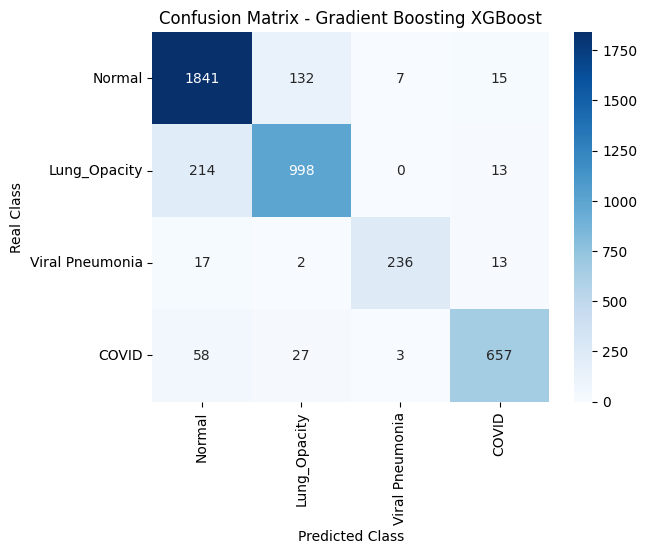

In [10]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgboost), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Gradient Boosting XGBoost')
plt.show()

## 9. Voting with Random Forest, Bagging, and XG Boost

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import time

start_time_voting = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=123)
bagging = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=123)
xgboost = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=123)

voting_clf = VotingClassifier(estimators=[
    ('rf', rf), 
    ('bagging', bagging), 
    ('xgboost', xgboost)
], voting='hard')

voting_clf.fit(X_train_flat_scaled, y_train)

y_pred_voting = voting_clf.predict(X_test_flat_scaled)

print("Voting Classifier Classification Report")
print(classification_report(y_test, y_pred_voting, target_names=categories))

accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Accuracy score for Voting Classifier is:", accuracy_voting)

cm_voting = confusion_matrix(y_test, y_pred_voting)
conf_matrix_voting_df = pd.DataFrame(cm_voting, index=[f'Real {cat}' for cat in categories], columns=[f'Predicted {cat}' for cat in categories])
print(conf_matrix_voting_df)

end_time_voting = time.time()
total_time_voting = (end_time_voting - start_time_voting) / 60
formatted_total_time_voting = f"{total_time_voting:.2f}"
print("Total training time is:", formatted_total_time_voting, "minutes.")



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:49:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Voting Classifier Classification Report
                 precision    recall  f1-score   support

         Normal       0.81      0.93      0.87      1995
   Lung_Opacity       0.83      0.77      0.80      1225
Viral Pneumonia       0.95      0.81      0.87       268
          COVID       0.92      0.74      0.82       745

       accuracy                           0.84      4233
      macro avg       0.88      0.81      0.84      4233
   weighted avg       0.85      0.84      0.84      4233

Accuracy score for Voting Classifier is: 0.8412473423104181
                      Predicted Normal  Predicted Lung_Opacity  \
Real Normal                       1849                     117   
Real Lung_Opacity                  259                     946   
Real Viral Pneumonia                35                       9   
Real COVID                         130                      62   

                      Predicted Viral Pneumonia  Predicted COVID  
Real Normal                                

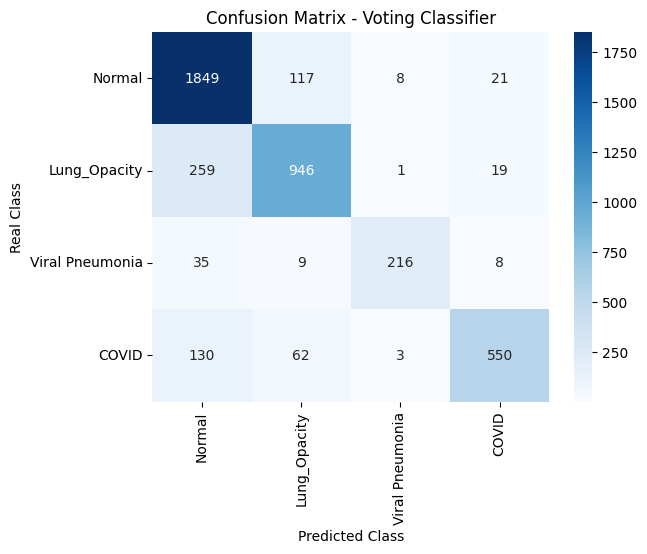

In [56]:
sns.heatmap(confusion_matrix(y_test, y_pred_voting), annot = True, fmt = 'd', cmap = 'Blues', xticklabels = categories, yticklabels = categories)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()

# Interpreting the classification models

#### Summary of results, and constructing a dataframe

In [11]:
results = {
    'Model': ['Logistic Regression', 'SVM', 'Random Forest', 'KNN', 'Decision Tree', 'Bagging', 'Boosting', 'XGBoost', 'Voting'],
    'Accuracy': [0.74, 0.76, 0.84, 0.78, 0.70, 0.83, 0.71, 0.88, 0.84],
    'Training time (min)': [24.30, 304.14, 7.50, 5.89, 28.06, 520.35, 30.17, 229.65, 762.48],
    'Precision_Normal': [0.77, 0.76, 0.81, 0.79, 0.75, 0.81, 0.76, 0.86, 0.81],
    'Recall Normal': [0.78, 0.81, 0.91, 0.88, 0.75, 0.92, 0.76, 0.92, 0.93],
    'F1-Score Normal': [0.78, 0.79, 0.86, 0.83, 0.75, 0.86, 0.76, 0.89, 0.87],
    'Precision Lung Opacity': [0.70, 0.72, 0.83, 0.74, 0.64, 0.82, 0.66, 0.86, 0.83],
    'Recall Lung Opacity': [0.67, 0.68, 0.77, 0.74, 0.65, 0.76, 0.68, 0.81, 0.77],
    'F1-Score Lung Opacity': [0.69, 0.70, 0.80, 0.74, 0.64, 0.79, 0.67, 0.84, 0.80],
    'Precision Viral Pneumonia': [0.75, 0.88, 0.93, 0.88, 0.69, 0.93, 0.67, 0.96, 0.95],
    'Recall Viral Pneumonia': [0.79, 0.85, 0.80, 0.89, 0.71, 0.79, 0.62, 0.88, 0.81],
    'F1-Score Viral Pneumonia': [0.77, 0.87, 0.86, 0.89, 0.70, 0.86, 0.65, 0.92, 0.87],
    'Precision COVID': [0.69, 0.75, 0.91, 0.81, 0.69, 0.91, 0.67, 0.94, 0.92],
    'Recall COVID': [0.70, 0.69, 0.76, 0.57, 0.66, 0.71, 0.66, 0.88, 0.74],
    'F1-Score COVID': [0.69, 0.72, 0.83, 0.67, 0.68, 0.80, 0.66, 0.91, 0.82]
}

summary_classification_df = pd.DataFrame(results)
summary_classification_df.head(9)

Model  Accuracy  Training time (min)  Precision_Normal  \
0  Logistic Regression      0.74                24.30              0.77   
1                  SVM      0.76               304.14              0.76   
2        Random Forest      0.84                 7.50              0.81   
3                  KNN      0.78                 5.89              0.79   
4        Decision Tree      0.70                28.06              0.75   
5              Bagging      0.83               520.35              0.81   
6             Boosting      0.71                30.17              0.76   
7              XGBoost      0.88               229.65              0.86   
8               Voting      0.84               762.48              0.81   

   Recall Normal  F1-Score Normal  Precision Lung Opacity  \
0           0.78             0.78                    0.70   
1           0.81             0.79                    0.72   
2           0.91             0.86                    0.83   
3           0.88             0.83                    0.74   
4           0.75             0.75                    0.64   
5           0.92             0.86                    0.82   
6           0.76             0.76                    0.66   
7           0.92             0.89                    0.86   
8           0.93             0.87                    0.83   

   Recall Lung Opacity  F1-Score Lung Opacity  Precision Viral Pneumonia  \
0                 0.67                   0.69                       0.75   
1                 0.68                   0.70                       0.88   
2                 0.77                   0.80                       0.93   
3                 0.74                   0.74                       0.88   
4                 0.65                   0.64                       0.69   
5                 0.76                   0.79                       0.93   
6                 0.68                   0.67                       0.67   
7                 0.81                   0.84                       0.96   
8                 0.77                   0.80                       0.95   

   Recall Viral Pneumonia  F1-Score Viral Pneumonia  Precision COVID  \
0                    0.79                      0.77             0.69   
1                    0.85                      0.87             0.75   
2                    0.80                      0.86             0.91   
3                    0.89                      0.89             0.81   
4                    0.71                      0.70             0.69   
5                    0.79                      0.86             0.91   
6                    0.62                      0.65             0.67   
7                    0.88                      0.92             0.94   
8                    0.81                      0.87             0.92   

   Recall COVID  F1-Score COVID  
0          0.70            0.69  
1          0.69            0.72  
2          0.76            0.83  
3          0.57            0.67  
4          0.66            0.68  
5          0.71            0.80  
6          0.66            0.66  
7          0.88            0.91  
8          0.74            0.82

##### Melting dataframe for easier visualizations

In [12]:
melted_df = summary_classification_df.melt(id_vars = 'Model', var_name = 'Metric', value_name = 'Value')

precision_df = melted_df[melted_df['Metric'].str.contains('Precision')]
recall_df = melted_df[melted_df['Metric'].str.contains('Recall')]
f1score_df = melted_df[melted_df['Metric'].str.contains('F1-Score')]


# Visualization of Precision scores, F1-score, and Recall

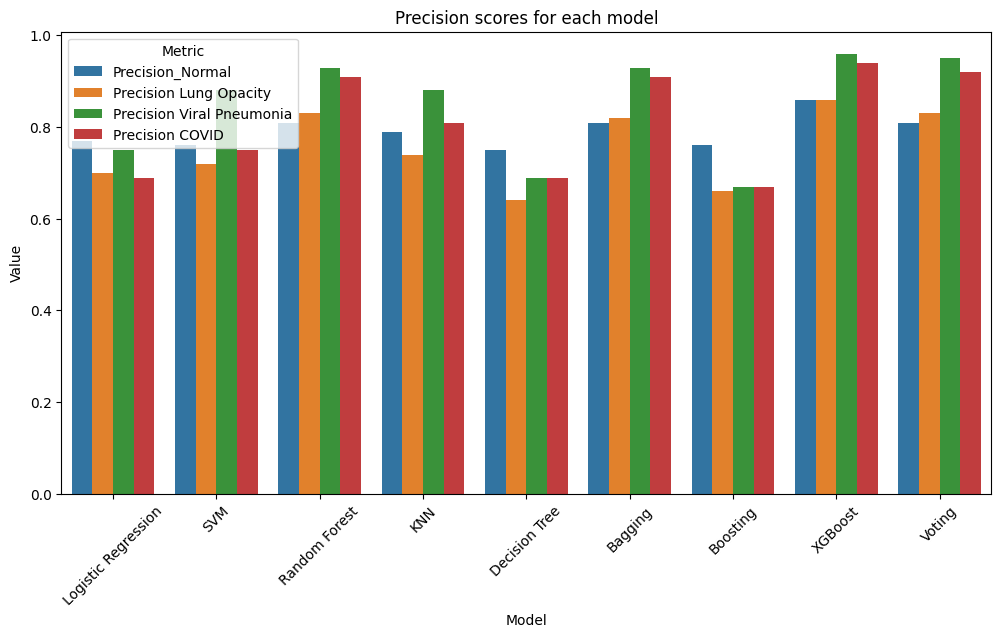

In [13]:
plt.figure(figsize = (12, 6))
sns.barplot(data = precision_df, x = 'Model', y = 'Value', hue = 'Metric')
plt.title('Precision scores for each model')
plt.xticks(rotation = 45)
plt.show()


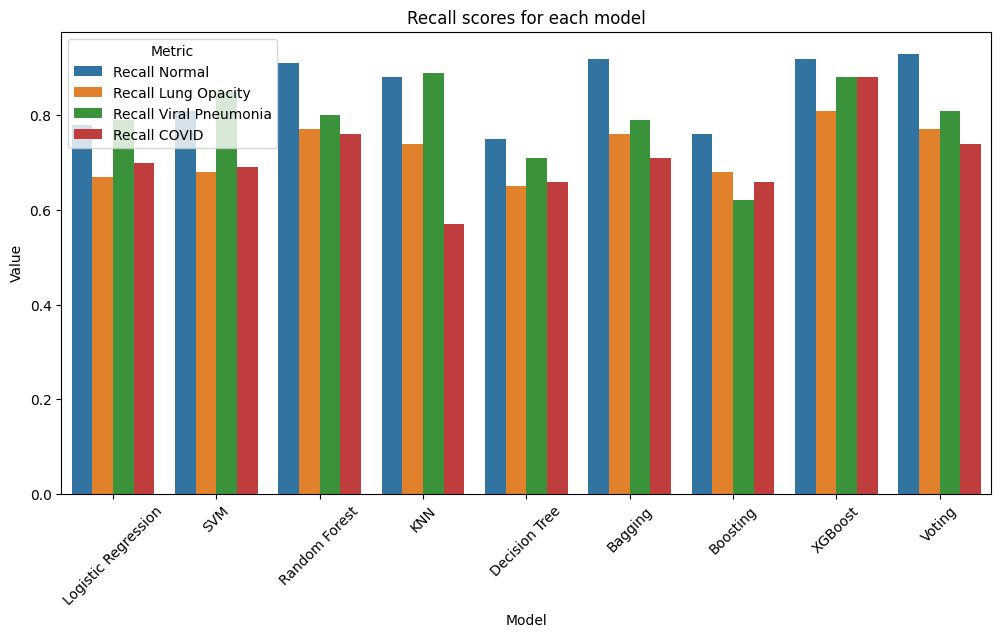

In [14]:
plt.figure(figsize = (12, 6))
sns.barplot(data = recall_df, x = 'Model', y = 'Value', hue = 'Metric')
plt.title('Recall scores for each model')
plt.xticks(rotation = 45)
plt.show()


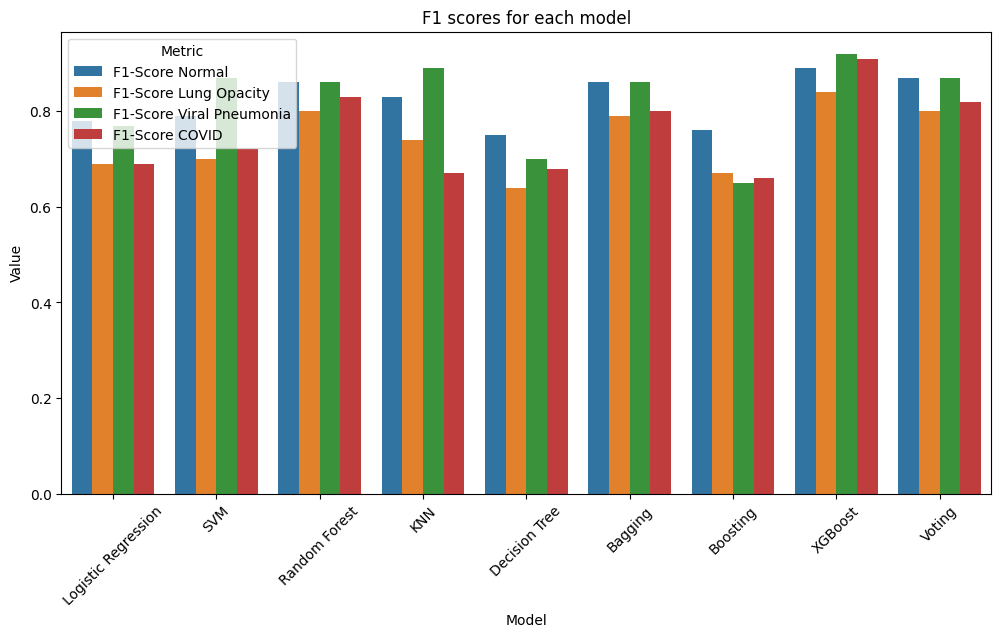

In [15]:
plt.figure(figsize = (12, 6))
sns.barplot(data = f1score_df, x = 'Model', y = 'Value', hue = 'Metric')
plt.title('F1 scores for each model')
plt.xticks(rotation = 45)
plt.show()


# Visualization of training time for each model

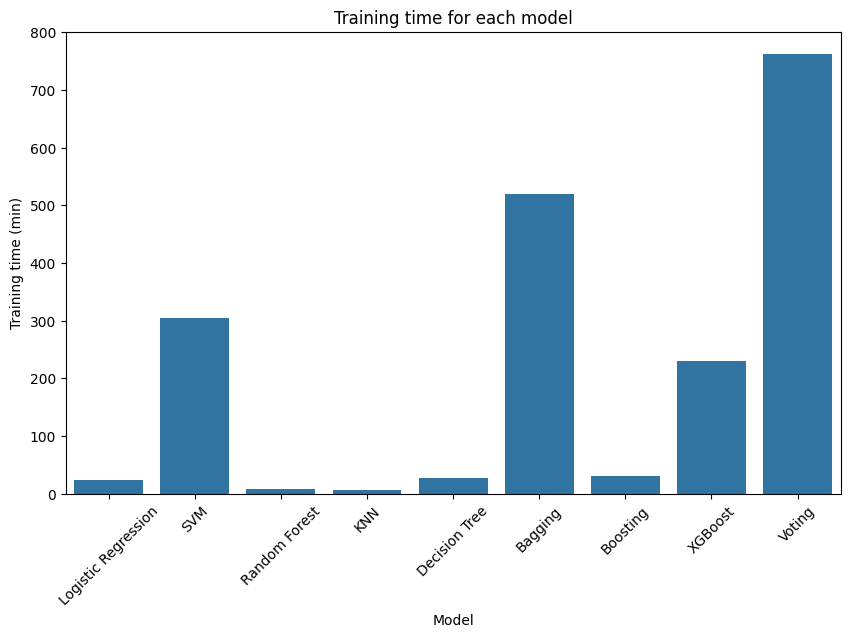

In [16]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Model', y = 'Training time (min)', data = summary_classification_df)
plt.title('Training time for each model')
plt.xticks(rotation = 45)
plt.show()


# Visualization of accuracies of all the models 

/var/folders/1h/mrfz61111xnc8q8w56bcw_r80000gp/T/ipykernel_1780/2821424482.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = summary_classification_df, x = 'Model', y = 'Accuracy', palette = 'viridis')


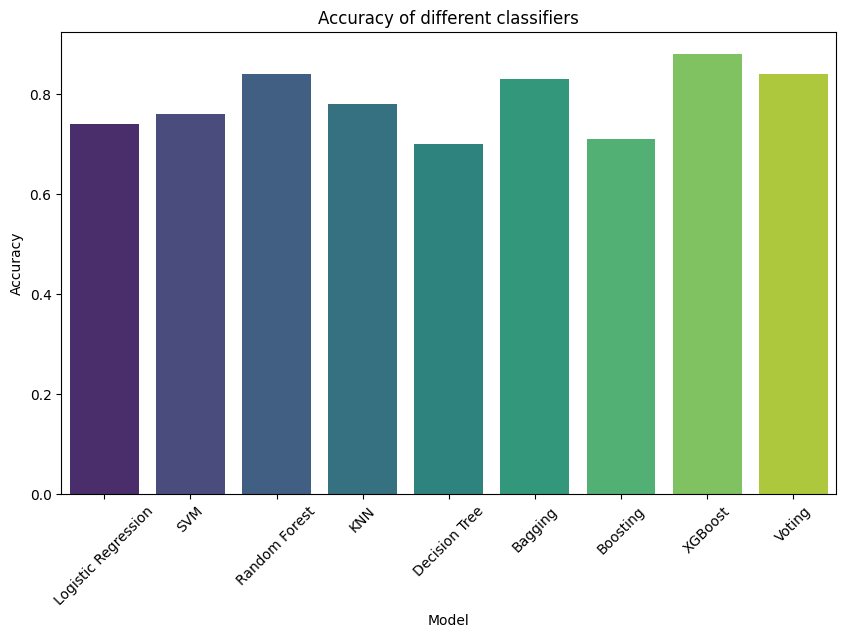

In [17]:
plt.figure(figsize = (10, 6))
sns.barplot(data = summary_classification_df, x = 'Model', y = 'Accuracy', palette = 'viridis')
plt.title('Accuracy of different classifiers')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation = 45)
plt.show()


# Calculating predicted probabilities for all the models

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_pred_lr_proba = clf_lr.predict_proba(X_test_flat_scaled)


In [34]:
import pickle

pickle_filename = "y_pred_lr_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_lr_proba, f)

print(f"Saved as {pickle_filename}")


Saved as y_pred_lr_proba.pkl


In [41]:
y_pred_svm_score = clf_svc.decision_function(X_test_flat_scaled)
y_pred_svm_proba = np.exp(y_pred_svm_score) / np.sum(np.exp(y_pred_svm_score), axis=1, keepdims=True)


In [42]:
import pickle

pickle_filename = "y_pred_svm_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_svm_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_svm_proba.pkl


In [27]:
y_pred_rf_proba = clf_rf.predict_proba(X_test_flat_scaled)


In [35]:
import pickle

pickle_filename = "y_pred_rf_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_rf_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_rf_proba.pkl


In [28]:
y_pred_knn_proba = best_knn.predict_proba(X_test_flat_scaled)


In [33]:
import pickle

pickle_filename = "y_pred_knn_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_knn_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_knn_proba.pkl


In [29]:
y_pred_dt_proba = dt.predict_proba(X_test_flat_scaled)


In [32]:
import pickle

pickle_filename = "y_pred_dt_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_dt_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_dt_proba.pkl


In [30]:
y_pred_bagging_proba = bagging.predict_proba(X_test_flat_scaled)


In [31]:
import pickle

pickle_filename = "y_pred_bagging_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_bagging_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_bagging_proba.pkl


In [36]:
y_pred_adaboost_proba = adaboost.predict_proba(X_test_flat_scaled)


In [38]:
import pickle

pickle_filename = "y_pred_adaboost_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_adaboost_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_adaboost_proba.pkl


In [39]:
y_pred_xgboost_proba = xgboost.predict_proba(X_test_flat_scaled)

In [40]:
import pickle

pickle_filename = "y_pred_xgboost_proba.pkl"
with open(pickle_filename, 'wb') as f:
    pickle.dump(y_pred_xgboost_proba, f)

print(f"Saved as {pickle_filename}")

Saved as y_pred_xgboost_proba.pkl


# Visualization of ROC Curves for all the models 

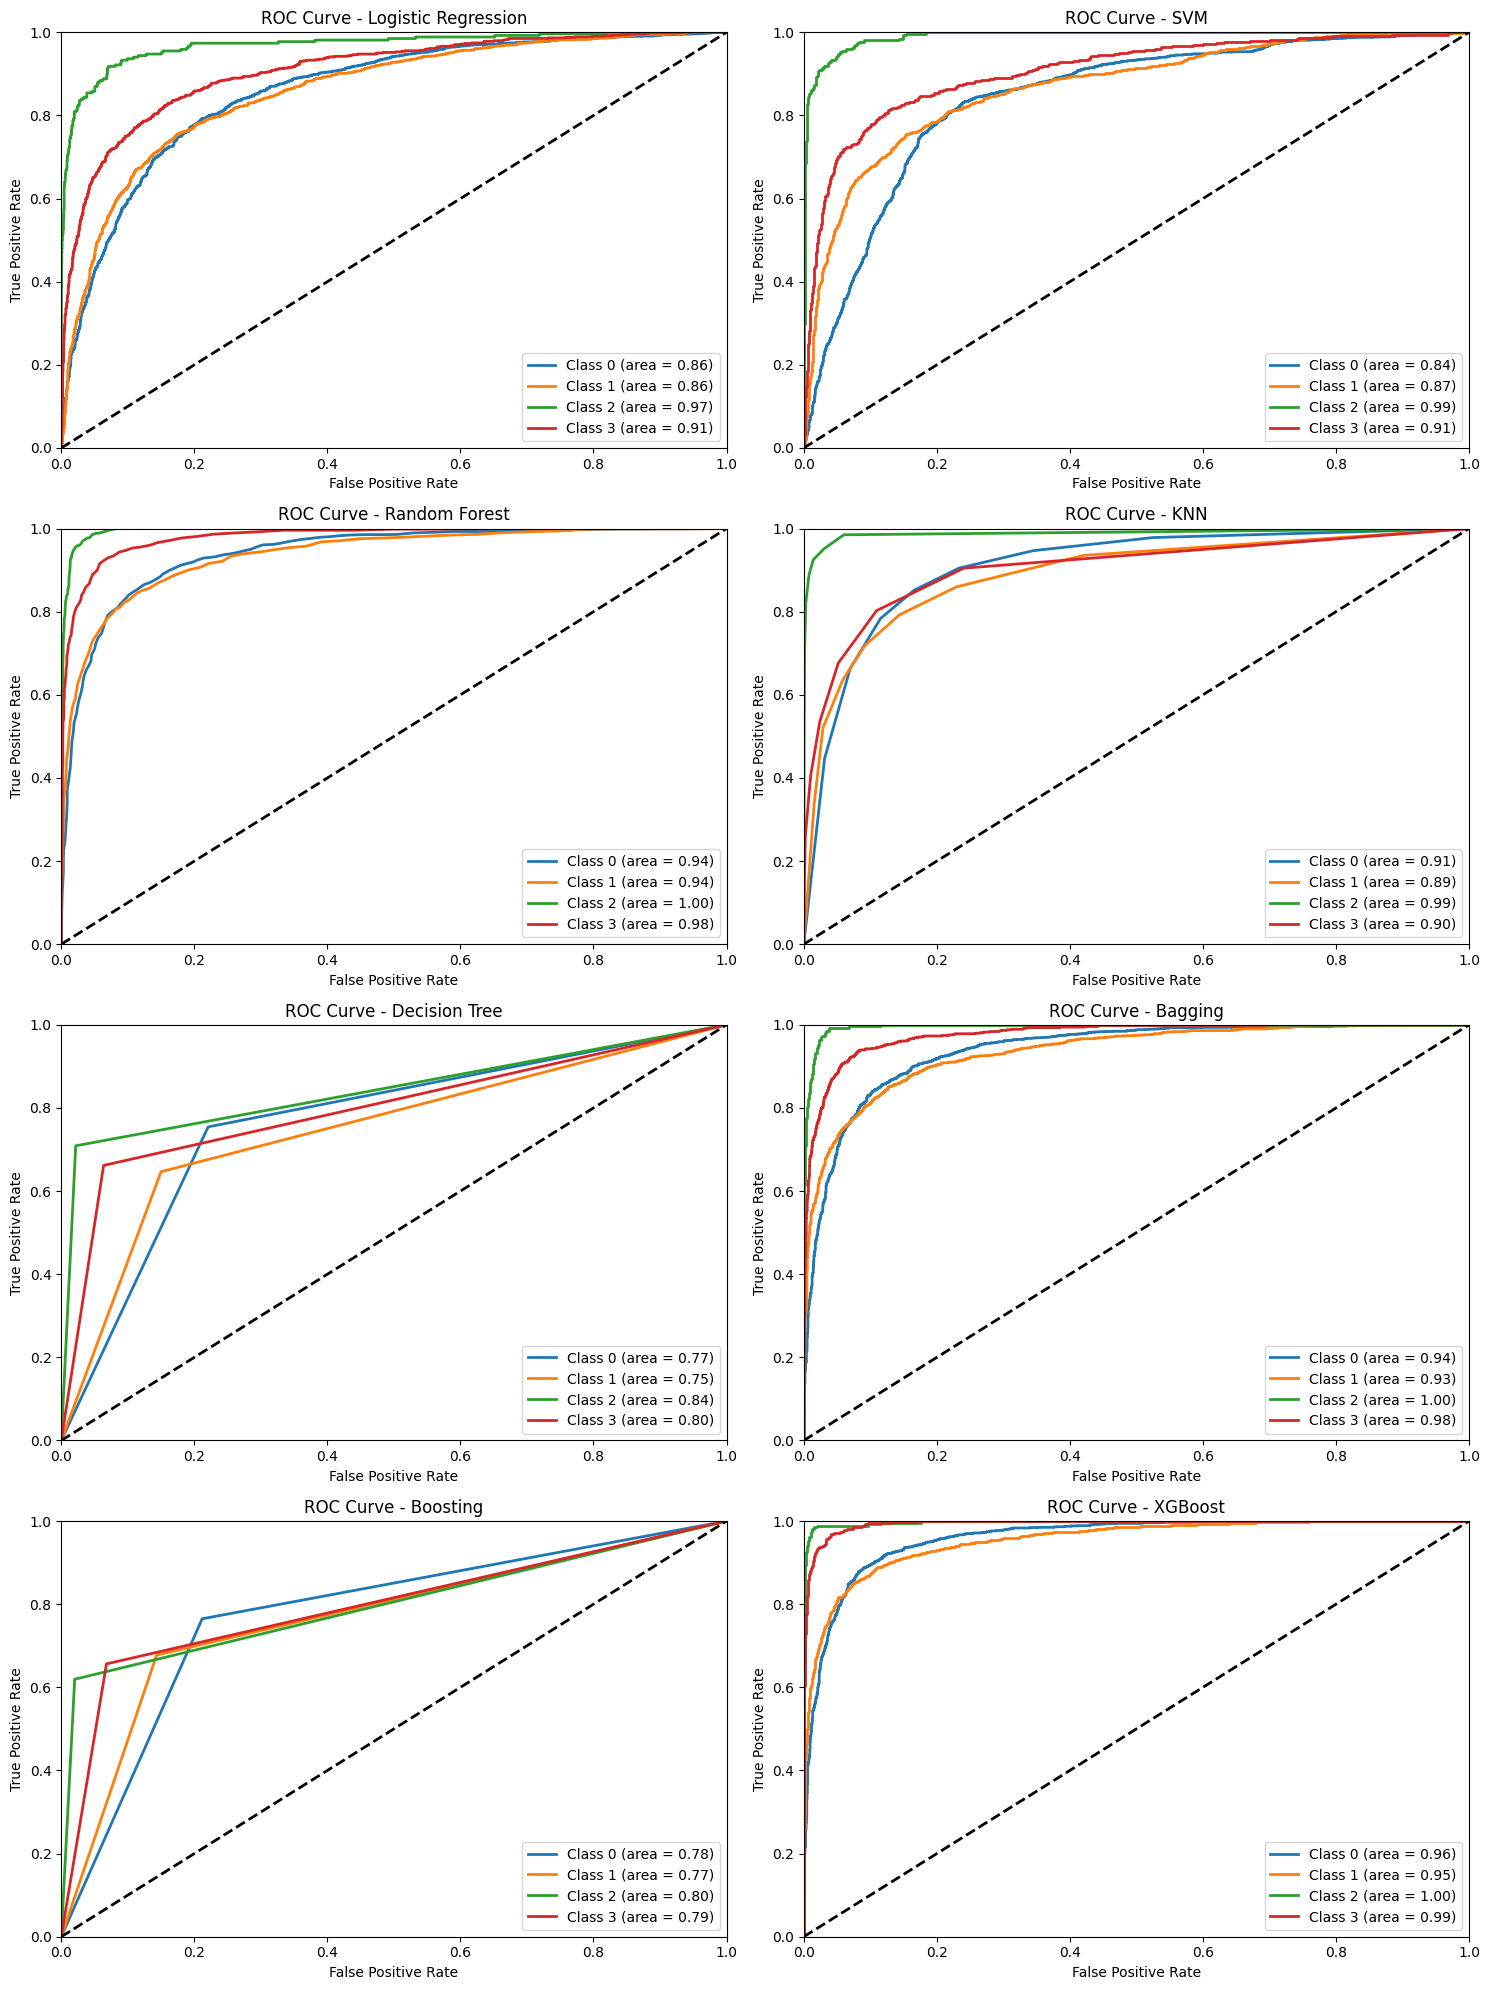

In [43]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Classifier predictions
classifiers = {
    'Logistic Regression': y_pred_lr_proba,
    'SVM': y_pred_svm_proba,
    'Random Forest': y_pred_rf_proba,
    'KNN': y_pred_knn_proba,
    'Decision Tree': y_pred_dt_proba,
    'Bagging': y_pred_bagging_proba,
    'Boosting': y_pred_adaboost_proba,
    'XGBoost': y_pred_xgboost_proba
}

# Determine number of rows needed for the plots
n_classifiers = len(classifiers)
n_cols = 2
n_rows = (n_classifiers + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot ROC curves for each classifier
for ax, (model_name, y_pred_proba) in zip(axes, classifiers.items()):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right")

# Remove empty subplots
for ax in axes[n_classifiers:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


# Visualization of PR Curves for all the models

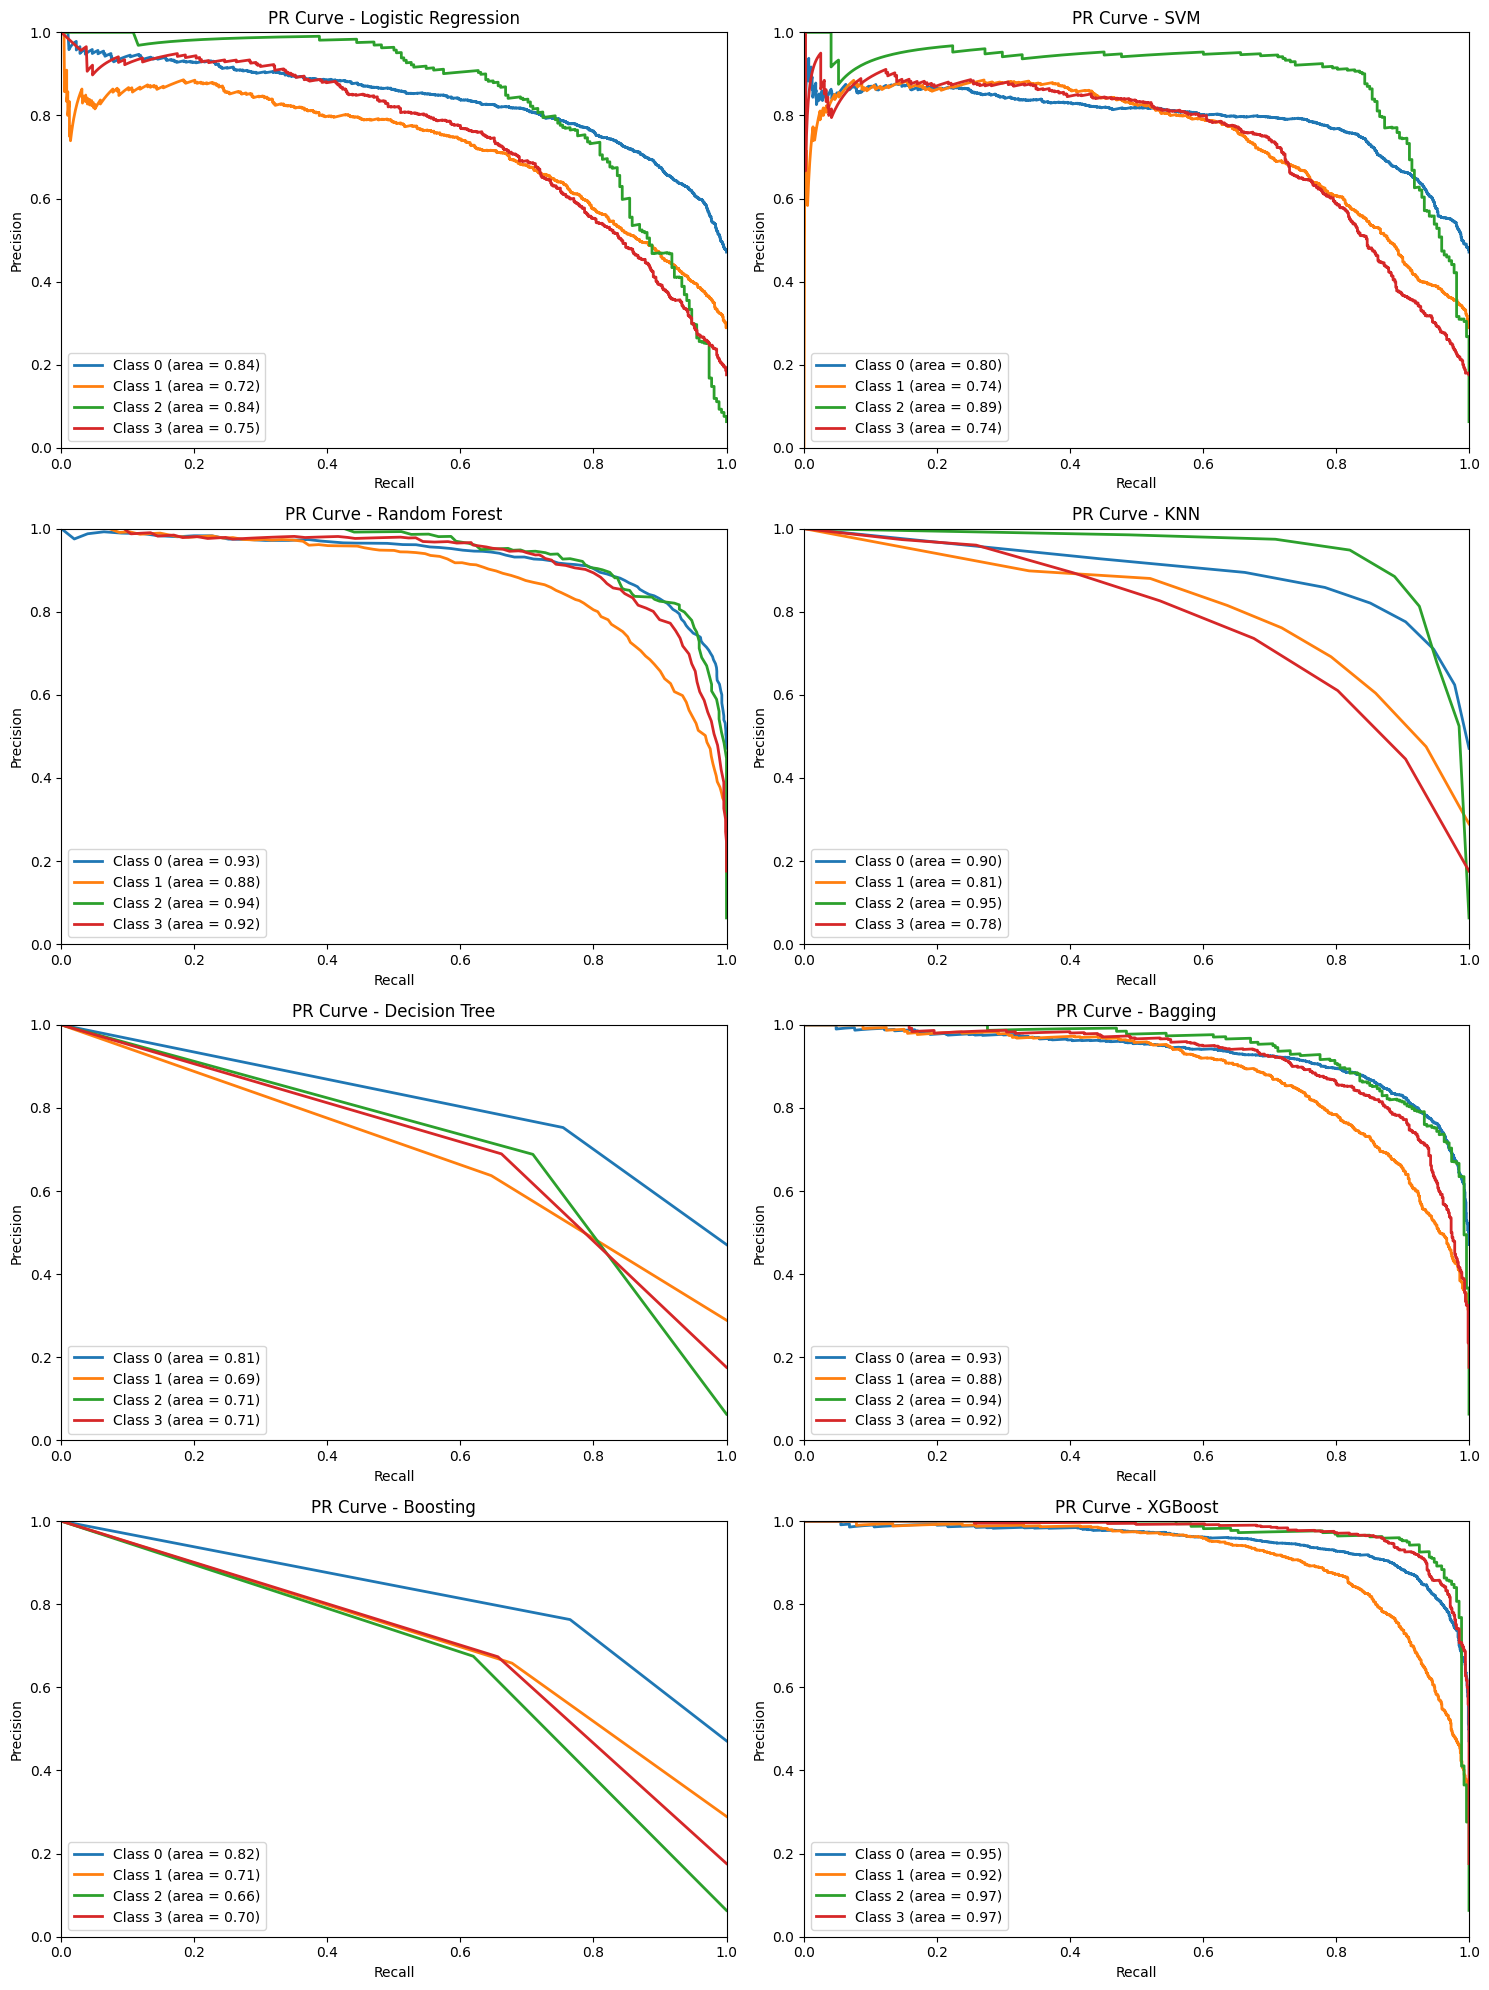

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

# Classifier predictions
classifiers = {
    'Logistic Regression': y_pred_lr_proba,
    'SVM': y_pred_svm_proba,
    'Random Forest': y_pred_rf_proba,
    'KNN': y_pred_knn_proba,
    'Decision Tree': y_pred_dt_proba,
    'Bagging': y_pred_bagging_proba,
    'Boosting': y_pred_adaboost_proba,
    'XGBoost': y_pred_xgboost_proba
}

# Determine number of rows needed for the plots
n_classifiers = len(classifiers)
n_cols = 2
n_rows = (n_classifiers + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot PR curves for each classifier
for ax, (model_name, y_pred_proba) in zip(axes, classifiers.items()):
    precision = dict()
    recall = dict()
    pr_auc = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    for i in range(n_classes):
        ax.plot(recall[i], precision[i], lw=2, label=f'Class {i} (area = {pr_auc[i]:.2f})')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'PR Curve - {model_name}')
    ax.legend(loc="lower left")

# Remove empty subplots
for ax in axes[n_classifiers:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


# Calculation and visualization of Feature Importance

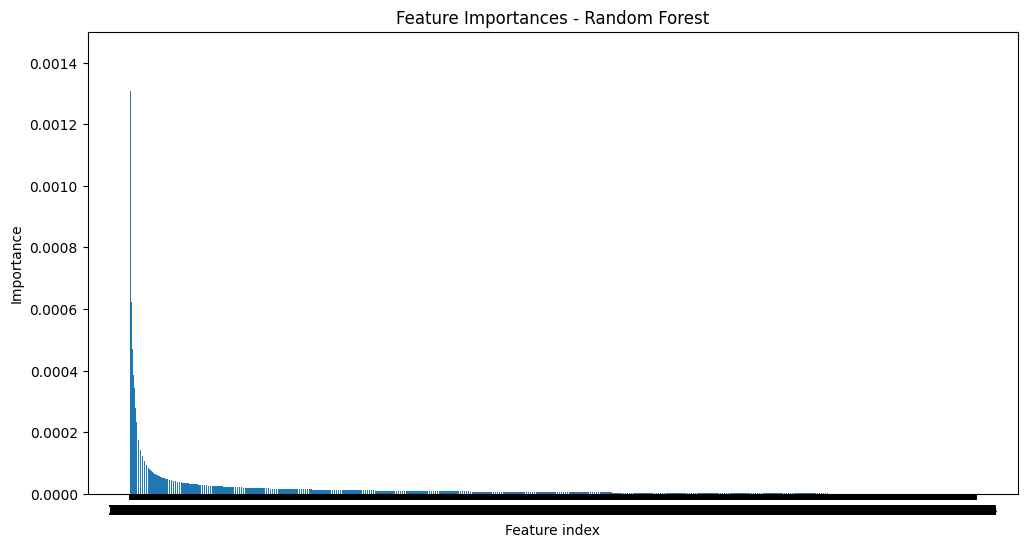

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate feature importances
importances_rf = clf_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.xticks(range(len(importances_rf)), indices_rf)
plt.ylim(0, 0.0015);
plt.show();


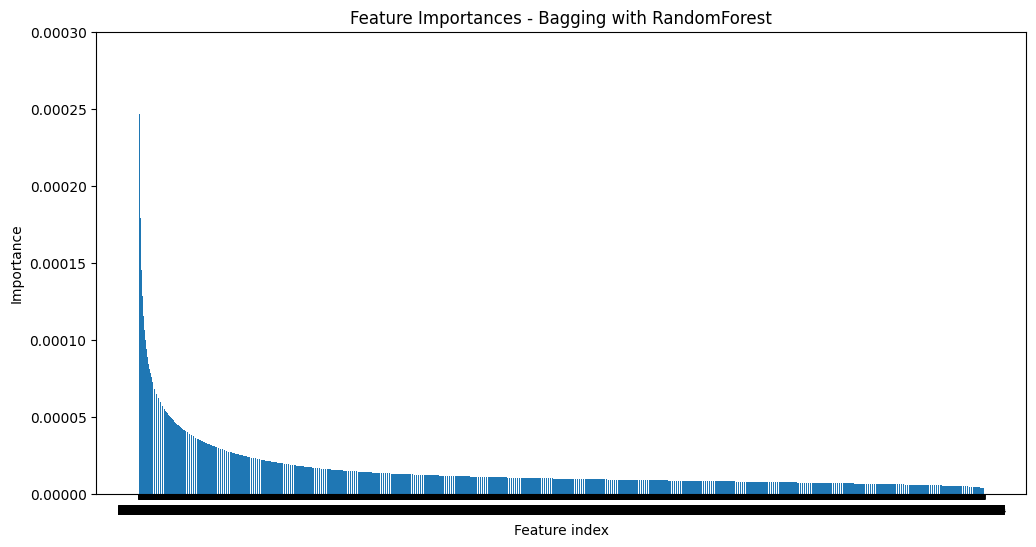

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate feature importances
importances_bagging = np.mean([est.feature_importances_ for est in bagging.estimators_], axis=0)
indices_bagging = np.argsort(importances_bagging)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Bagging with RandomForest")
plt.bar(range(len(importances_bagging)), importances_bagging[indices_bagging], align='center')
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.xticks(range(len(importances_bagging)), indices_bagging)
plt.ylim(0, 0.0003)
plt.show()



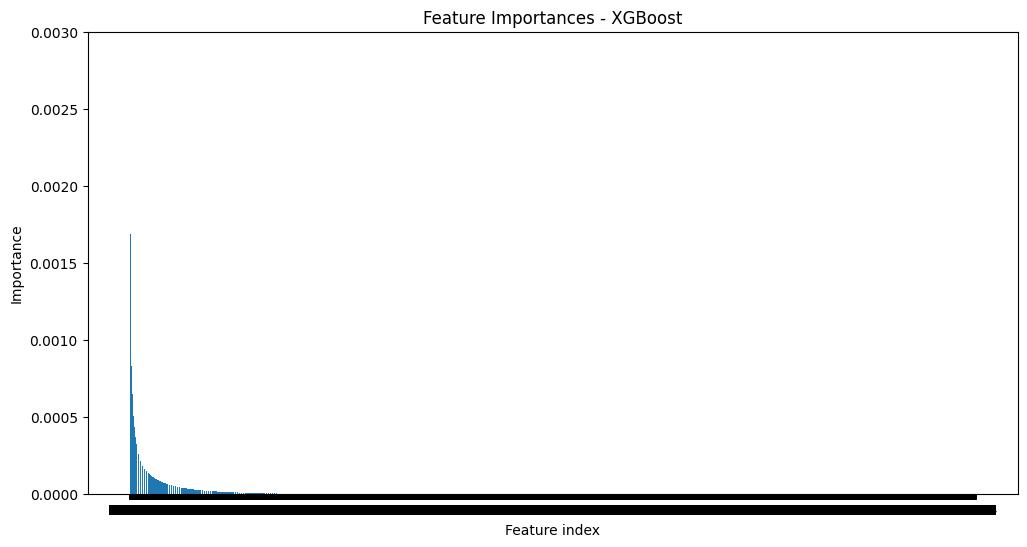

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `xgboost` is your trained XGBoost model
importances_xgb = xgboost.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], align='center')
plt.xlabel('Feature index')
plt.ylabel('Importance')
plt.xticks(range(len(importances_xgb)), indices_xgb)
plt.ylim(0, 0.003);
plt.show();


# Showing common misclassified indices across the models

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

misclassified_indices = defaultdict(list)


In [66]:
misclassified_indices['Logistic Regression'] = np.where(y_test != y_pred_lr)[0]


In [68]:
misclassified_indices['SVM'] = np.where(y_test != y_pred_svc)[0]

In [69]:
misclassified_indices['Random Forest'] = np.where(y_test != y_pred_rf)[0]

In [71]:
misclassified_indices['KNN'] = np.where(y_test != y_pred_knn_best)[0]

In [72]:
misclassified_indices['Decision Tree'] = np.where(y_test != y_pred_dt)[0]

In [74]:
misclassified_indices['Bagging'] = np.where(y_test != y_pred_bagging)[0]

In [75]:
misclassified_indices['AdaBoost'] = np.where(y_test != y_pred_adaboost)[0]

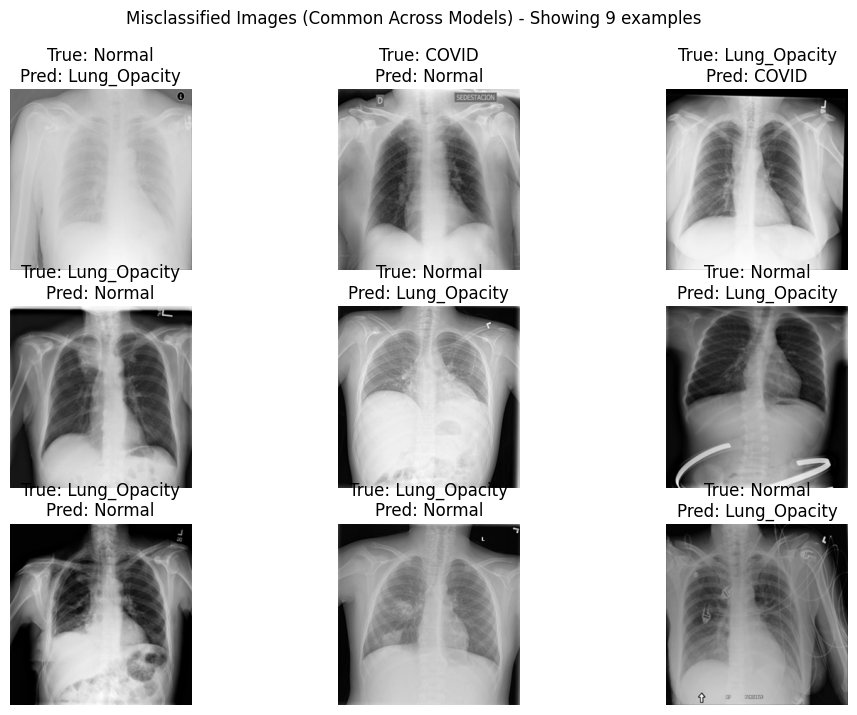

In [78]:
# Find common misclassified indices across all models
common_indices = set(misclassified_indices['Logistic Regression'])
for model in ['SVM', 'Random Forest', 'KNN', 'Decision Tree', 'Bagging', 'AdaBoost']:
    common_indices &= set(misclassified_indices[model])

common_indices = list(common_indices)
num_common_misclassified = len(common_indices)

plt.figure(figsize=(12, 8))

for i, index in enumerate(common_indices[:9]):  # Limit to 9 images for visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[index].reshape(256, 256), cmap='gray')  # Assuming images are 256x256
    plt.title(f"True: {categories[y_test[index]]}\nPred: {categories[y_pred_lr[index]]}")
    plt.axis('off')

plt.suptitle(f'Misclassified Images (Common Across Models) - Showing {min(num_common_misclassified, 9)} examples')
plt.show()

# RandomUnderSampler for balancing

In [23]:
from imblearn.under_sampling import RandomUnderSampler

rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train_flat_scaled, y_train)
X_ru.shape

(4308, 65536)

In [ ]:
# undersampled training set
clf_rf = RandomForestClassifier(n_jobs=-1)
clf_adaboost = AdaBoostClassifier()
clf_logreg = LogisticRegression()
clf_kneighbors = KNeighborsClassifier()
clf_svc = SVC()

accuracy_ru = list()

for clf in [clf_rf, clf_adaboost, clf_logreg, clf_kneighbors, clf_svc]:
    clf.fit(X_ru, y_ru)
    test_pred = clf.predict(X_test)
    accuracy_ru.append(accuracy_score(y_test, test_pred))

acurracy_df_ru = pd.DataFrame({'Accuarcy Score': accuracy_ru},
                            index = ['RandomForest', 'AdaBoost', 'LogisticRegression', 'KNeighbors', 'SVC'])
acurracy_df_ru

/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/philipptrinh/Desktop/DataScientest/Project - Covid X-Ray/Project Covid19-XRay Repo/may24_bds_int_covid_xray/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuarcy Score
RandomForest              0.792346
AdaBoost                  0.529648
LogisticRegression        0.720765
KNeighbors                0.714859
SVC                       0.781243

In [ ]:
# As you can see the accuracy scores with random undersampling were (sometimes much) lower which is why we decided to stick with class weighting.

# Codes that took too much time, and thus were not finished for this project

### 1. Parametrization of Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf = RandomForestClassifier(random_state=123)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_flat_scaled, y_train)

best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest are:", best_params_rf)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results_rf_opt_df = pd.DataFrame(grid_search_rf.cv_results_)

params_columns = ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_class_weight']
results_columns = ['mean_test_score']



In [ ]:
start_time_opt_rf = time.time()

clf_best_rf = RandomForestClassifier(
    n_estimators = best_params_rf['n_estimators'],
    max_depth = best_params_rf['max_depth'],
    min_samples_split = best_params_rf['min_samples_split'],
    min_samples_leaf = best_params_rf['min_samples_leaf'],
    class_weight = best_params_rf['class_weight'],
    random_state = 123
)

clf_best_rf.fit(X_train_flat_scaled, y_train)

y_pred_best_rf = clf_best_rf.predict(X_test_flat_scaled)
print(classification_report(y_test, y_pred_best_rf, target_names = categories))
print("\n")
accuracy = accuracy_score(y_test, y_pred_best_rf)
print("Accuracy Scor for optimized Random Forest is:", accuracy)
print("\n")
cm_rf = confusion_matrix(y_test, y_pred_best_rf)
conf_matrix_best_rf_df = pd.DataFrame(cm_rf, index = [f'Real {cat}' for cat in categories], columns = [f'Predicted {cat}' for cat in categories])
print(conf_matrix_best_rf_df)
print("\n")
end_time_opt_rf = time.time()
total_time_opt_rf = (end_time_opt_rf - start_time_opt_rf)/60
formatted_total_time_opt_rf = f"{total_time_opt_rf:.2f}"
print("Total training time is:", formatted_total_time_opt_rf, "minutes.")


### 2. Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, resampler = None):
    if resampler:
        X_train_res, y_train_res = resampler.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train, y_train

    start_time = time.time()

    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    end_time = time.time()
    total_time = (end_time - start_time) / 60
    formatted_total_time = f"{total_time:.2f}"

    print(f"{model_name} Classification report")
    print(classification_report(y_test, y_pred, target_names = categories))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name} is: {accuracy:.4f}")
    print("\n")

    cm = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(cm, index = [f'Real {cat}' for cat in categories], columns = [f'Predicted {cat}' for cat in categories])
    print(conf_matrix_df)

    print(f"Total training time for {model_name} is: {formated_total_time} minutes.")

    return accuracy, formatted_total_time

oversampler = SMOTE(random_state = 123)
undersampler = RandomUnderSampler(random_state = 123)


In [ ]:
accuracy_lr_oversampling, time_lr_oversampling = train_and_evaluate_model(
    LogisticRegression(max_iter = 2000), 'Logistic Regression (oversampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_lr_undersampling, time_lr_undersampling = train_and_evaluate_model(
    LogisticRegression(max_iter = 2000), 'Logistic Regression (undersampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = undersampler
)


In [ ]:
accuracy_svm_oversampling, time_svm_oversampling = train_and_evaluate_model(
    SVC(probability = True), 'SVM (oversampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_svm_undersampling, time_svm_undersampling = train_and_evaluate_model(
    SVC(probability = True), 'SVM (undersampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_knn_oversampling, time_knn_oversampling = train_and_evaluate_model(
    KNeighborsClassifier(), 'KNN (oversampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_knn_undersampling, time_knn_undersampling = train_and_evaluate_model(
    KNeighborsClassifier(), 'KNN (undersampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = undersampler
)


In [ ]:
accuracy_dt_oversampling, time_dt_oversampling = train_and_evaluate_model(
    DecisionTreeClassifier(), 'Decision Tree (oversampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_dt_undersampling, time_dt_undersampling = train_and_evaluate_model(
    DecisionTreeClassifier(), 'Decision Tree (undersampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = undersampler
)


In [ ]:
accuracy_rf_oversampling, time_rf_oversamling = train_and_evaluate_model(
    RandomForestClassifier(n_estimators = 100, random_state = 123), 'Random Forest (oversampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = oversampler
)


In [ ]:
accuracy_rf_undersampling, time_rf_undersampling = train_and_evaluate_model(
    RandomForestClassifier(n_estimator = 100, random_state = 123), 'Random Forest (undersampling)',
    X_train_scaled, y_train, X_test_scaled, y_test, resampler = undersampler
)


# Image Preprocessing (Region of Interests and Filters) and further Classification Modelling

### We will use a for loop to go through all images in each directory, read them, re-size them and store them as arrays as well as a df. In the following step, we will use the array to select only the lung area for building our model

### All dataframes created for future use in models currently have image data in the form of an array. This has to be modified in the following steps before splitting the data into train and test set

In [1]:
# Import the necessary modules

import pandas as pd, numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
%matplotlib inline

In [3]:
# Step 1: A for loop to read, resize and store all image and mask data in a dataframe

# Step 1.1: Get the path of the directory that contains the data
base_dir = os.path.abspath('..')
data_dir = os.path.join(base_dir, 'data')
# path = '../data/raw/'
# os.chdir(path)  #Go to the directory specified abv


# Step 1.2:  Create a list of categories and subfolders for each category to loop through
categories = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
sub_types = ['images', 'masks']

# Step 1.3: Create a list to store image and mask data separately- we will need this to select the lung area
image_data = []
image_name = [] # stores the name of the image
labels_img = []# the label or category of each image or mask

mask_data = []
mask_name = [] # stores the name of the mask
labels_mk = []


# Step 1.4: Loop through and read the 1st image and mask of each group 
for category in categories:
  
    #Loop through each sub-folder to load the images
    for sub_type in sub_types:
        
        file_path = os.path.join(data_dir, 'raw', category, sub_type)
        

        for image in os.listdir(file_path):
            
            if sub_type == 'images':

                # Step 1: Get the label for each image
                label = image.split('-')[0]
                #label_cat = categories.index(label)# 0: Normal, 1: COVID, 2: Lung Opacity, 3: Pneumonia
                labels_img.append(label)

                # Step 2: Read each image
                Xray = cv2.imread(os.path.join(file_path, image), cv2.IMREAD_GRAYSCALE)# reads every image
     
                # Step 3: Re-size each raw X-ray image to 256*256 pixels
                Xray_resize = cv2.resize(Xray, (256, 256))
        
                # Step 4: Store image data 
                image_data.append(Xray_resize)
                image_name.append(image)# name of the image
                #print(np.array(image_data))   
                    
                # Step 5: create a df with this data
                image_df = pd.DataFrame({'name': image_name, 'image': image_data, 'label': labels_img})
                     

            elif sub_type == 'masks':

                # Step 1: Get the label for each mask
                label_mk = image.split('-')[0]
                labels_mk.append(label_mk)
                    
                # Step 2: Read the mask
                mask = cv2.imread(os.path.join(file_path, image), cv2.IMREAD_GRAYSCALE)

                    # check the size of the mask. They are 256*256 pixels
                    #print(mask.shape)

                    #Note: No re-sizing needed for masks as they are already 256*256

                # Step 3: Store image data as an array
                mask_data.append(mask)
                mask_name.append(image)

                # STep 4:reate a df with this data
                mask_df = pd.DataFrame({'name': mask_name, 'image': mask_data, 'label': labels_mk})
                    
                    

Text(0.5, 1.0, 'Lung area')

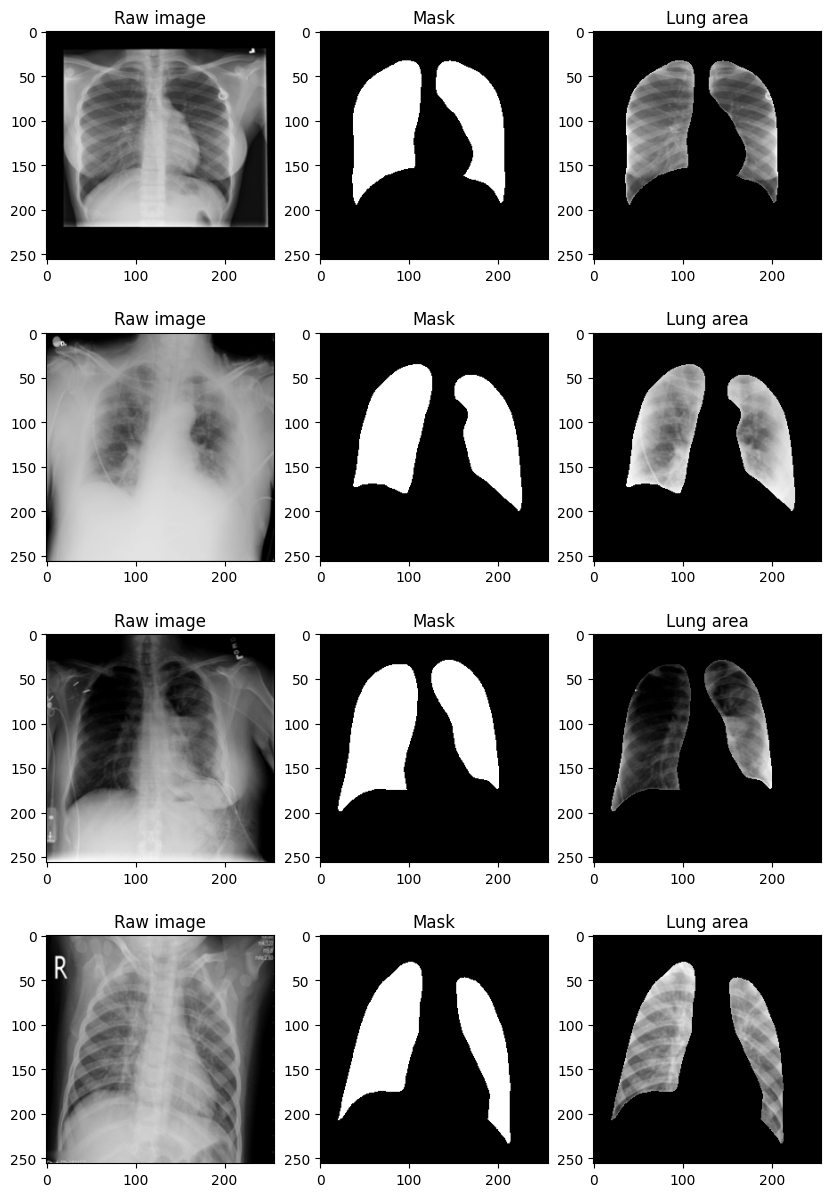

In [4]:
# Step 2.1:  Define a function to cut out only the lung region of the x ray for analysis
def filter_roi(image, mask):
    
    # Apply the mask to the image
    roi = cv2.bitwise_and(image, image, mask = mask)
    
    # Filter the ROI (e.g., apply additional blurring or other filters)
    #filtered_roi = cv2.GaussianBlur(roi, (15, 15), 0)
    
    return roi

# Step 2.2: TEST RUN for the function
# Step 2.2.1: first, read and re-size the image 
def read_resize_img(image):

    # Step1: Read the image in gray scale
    Xray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

    # Step1.2: resize the image to 256*256 pixels
    Xray_resize = cv2.resize(Xray, (256, 256))

    return Xray_resize

# Step 2.2.2: test the filter function on re-sized images
#A test run for images
normal = read_resize_img('../data/raw/Normal/images/Normal-1.png')
normal_mk = read_resize_img('../data/raw/Normal/masks/Normal-1.png')
roi_normal = filter_roi(normal, normal_mk)

# FOr a COVID series
covid = read_resize_img('../data/raw/COVID/images/COVID-1.png')
covid_mk = read_resize_img('../data/raw/COVID/masks/COVID-1.png')
roi_covid = filter_roi(covid, covid_mk)


# FOr an LO series
lo = read_resize_img('../data/raw/Lung_Opacity/images/Lung_Opacity-1.png')
lo_mk = read_resize_img('../data/raw/Lung_Opacity/masks/Lung_Opacity-1.png')
roi_lo = filter_roi(lo, lo_mk)

# FOr a VP series
vp = read_resize_img('../data/raw/Viral Pneumonia/images/Viral Pneumonia-1.png')
vp_mk = read_resize_img('../data/raw/Viral Pneumonia/masks/Viral Pneumonia-1.png')
roi_vp = filter_roi(vp, vp_mk)

# plot
fig = plt.figure(figsize=(10,15))

# images
plt.subplot(4,3,1)
plt.imshow(normal, cmap = 'gray')
plt.title('Raw image')

plt.subplot(4,3,2)
plt.imshow(normal_mk, cmap="gray")
plt.title('Mask')

plt.subplot(4,3,3)
plt.imshow(roi_normal, cmap="gray")
plt.title('Lung area')

plt.subplot(4,3,4)
plt.imshow(covid, cmap = 'gray')
plt.title('Raw image')

plt.subplot(4,3,5)
plt.imshow(covid_mk, cmap="gray")
plt.title('Mask')

plt.subplot(4,3,6)
plt.imshow(roi_covid, cmap="gray")
plt.title('Lung area')

plt.subplot(4,3,7)
plt.imshow(lo, cmap = 'gray')
plt.title('Raw image')

plt.subplot(4,3,8)
plt.imshow(lo_mk, cmap="gray")
plt.title('Mask')

plt.subplot(4,3,9)
plt.imshow(roi_lo, cmap="gray")
plt.title('Lung area')

plt.subplot(4,3,10)
plt.imshow(vp, cmap = 'gray')
plt.title('Raw image')

plt.subplot(4,3,11)
plt.imshow(vp_mk, cmap="gray")
plt.title('Mask')

plt.subplot(4,3,12)
plt.imshow(roi_vp, cmap="gray")
plt.title('Lung area')

In [5]:
# View the df created in step 1
image_df.head()
mask_df.head()


## Step 3:  Run the ROI selection function to selection only the lung region of every image

# Step 3.1: create an empty list to add pixel intensitie of only the lung region
lung_area = []  # to add only the pixels in the lung area


# Step 3.2: For every image and corresponding mask, select the lung region
for index,(image, mask) in enumerate(zip(image_data, mask_data)):

    ## The ROI selection function to select the lung region 
    roi_lung = filter_roi(image, mask)

    # Add this data into a list
    lung_area.append(roi_lung)
                          


The roi selection of the lung area seems to have worked


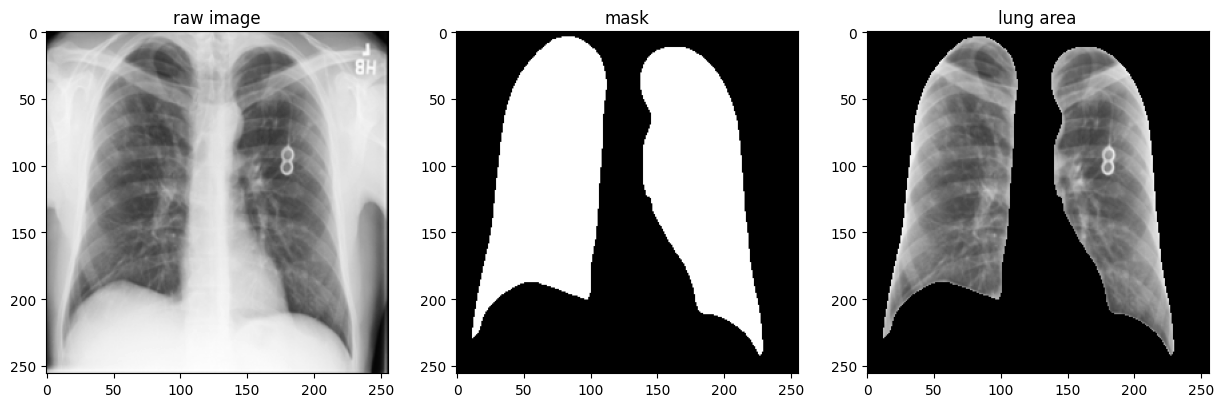

In [6]:

# Step 3.3: Plot to check if the roi selection worked- for some random images

for i in np.random.choice(np.arange(0, len(image_data)), size = 1):
    img = image_data[i] 
    mask = mask_data[i]
    lung = lung_area[i]
  
    fig = plt.figure(figsize=(15,15))
    plt.subplot(131),plt.imshow(img, cmap = 'gray'),plt.title('raw image')
    plt.subplot(132),plt.imshow(mask, cmap = 'gray'),plt.title('mask')
    plt.subplot(133),plt.imshow(lung, cmap = 'gray'),plt.title('lung area')
    
  
print('The roi selection of the lung area seems to have worked')

In [7]:
print(lung_area.index)
print(image_df.head())

<built-in method index of list object at 0x177e54f40>
              name                                              image   label
0  Normal-6196.png  [[247, 244, 241, 239, 236, 233, 231, 228, 228,...  Normal
1  Normal-7288.png  [[233, 228, 223, 220, 217, 215, 214, 211, 210,...  Normal
2  Normal-1821.png  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...  Normal
3  Normal-4781.png  [[18, 11, 6, 3, 2, 3, 2, 2, 2, 2, 2, 3, 3, 3, ...  Normal
4  Normal-4959.png  [[206, 200, 192, 170, 130, 85, 58, 41, 27, 20,...  Normal


              name   label                                         lung_image
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


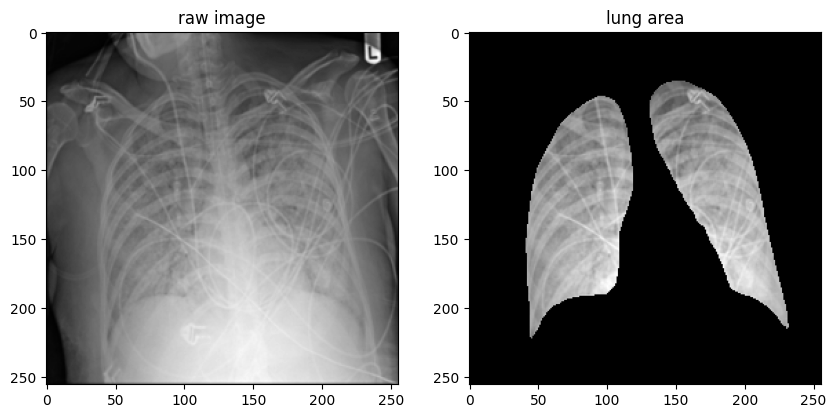

In [8]:
# Step 4: Merge the data into a df for all the subsequent steps

# STep 4.1: Create a df that contains the image name, pixels from just the lung area and the label
lung_data = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'lung_image': lung_area})

print(lung_data.head())# The merge was done considering that the order of images is the same in the df and the lung_area array

#Step 4.2: plot randome images to see if the image and the lung area are indeed of the same raw image- SORT OF A REDUNDANT STEP from step 3.3
for i in np.random.choice(np.arange(0, len(lung_data)), size = 1):
    img = image_data[i] 
    lung = lung_data['lung_image'][i]
  
    fig = plt.figure(figsize=(10,10))
    plt.subplot(121),plt.imshow(img, cmap = 'gray'),plt.title('raw image')
    plt.subplot(122),plt.imshow(lung, cmap = 'gray'),plt.title('lung area')


Text(0.5, 1.0, 'median blur 7 + Canny 0-50')

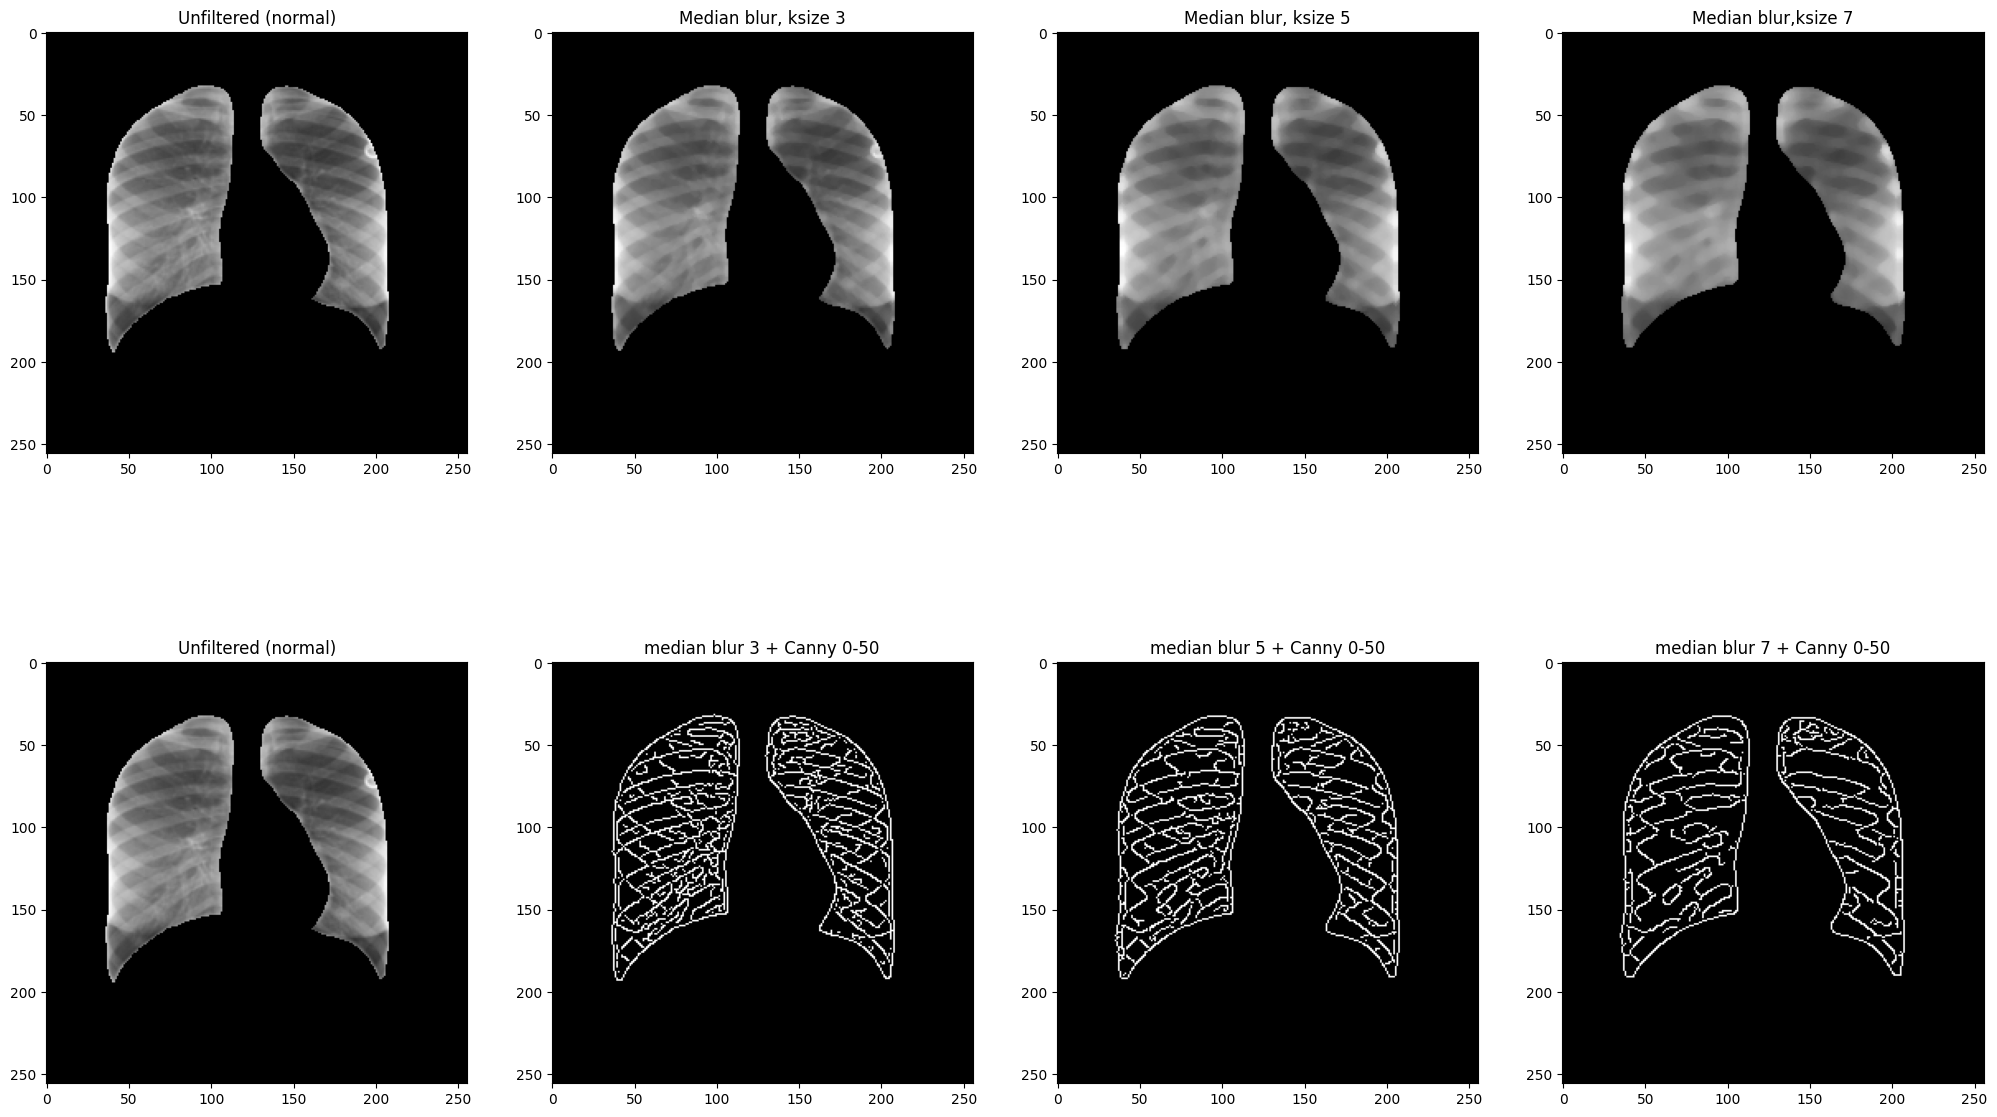

In [9]:
############+++++++++++++++++++++++++++++++++++++  Step 5: Use different filters to check how we can eliminate unwanted noise ++++++++++++++++++#######################

# Step 5.1 : median blur + Canny for normal

# Median blur with 3 different ksizes- DETAILED ANALYSIS 
### STep 5.1.1: median blur for normal
med_normal_1 = cv2.medianBlur(roi_normal, ksize = 3)
med_normal_2 = cv2.medianBlur(roi_normal, ksize = 5)
med_normal_3 = cv2.medianBlur(roi_normal, ksize = 7)

# Step 5.1.2: Canny detection for Normal

med1_canny_nor = cv2.Canny(med_normal_1, 0, 50)
med2_canny_nor = cv2.Canny(med_normal_2, 0, 50)
med3_canny_nor = cv2.Canny(med_normal_3, 0, 50)

## Step 5.1.3 PLot
fig = plt.figure(figsize=(25,15))

# images- normal

plt.subplot(241)
plt.imshow(roi_normal, cmap = 'gray')
plt.title('Unfiltered (normal)')

plt.subplot(242)
plt.imshow(med_normal_1, cmap="gray")
plt.title('Median blur, ksize 3')

plt.subplot(243)
plt.imshow(med_normal_2, cmap="gray")
plt.title('Median blur, ksize 5')

plt.subplot(244)
plt.imshow(med_normal_3, cmap="gray")
plt.title('Median blur,ksize 7')

plt.subplot(245)
plt.imshow(roi_normal, cmap = 'gray')
plt.title('Unfiltered (normal)')

plt.subplot(246)
plt.imshow(med1_canny_nor, cmap="gray")
plt.title('median blur 3 + Canny 0-50')

plt.subplot(247)
plt.imshow(med2_canny_nor, cmap="gray")
plt.title('median blur 5 + Canny 0-50')

plt.subplot(248)
plt.imshow(med3_canny_nor, cmap="gray")
plt.title('median blur 7 + Canny 0-50')


Median blur and Canny edge detection detects noise as well and we observe the rib cage and some fibres that are caught as structures with edge detection
Median blur 5 and 7 is sort of creating some shpaes which are actually not in the original image. SO, this will not be useful for us
Median blur 3, 3 and a canny filter of 50 looks promising although in normal it catches quite a bit of noise


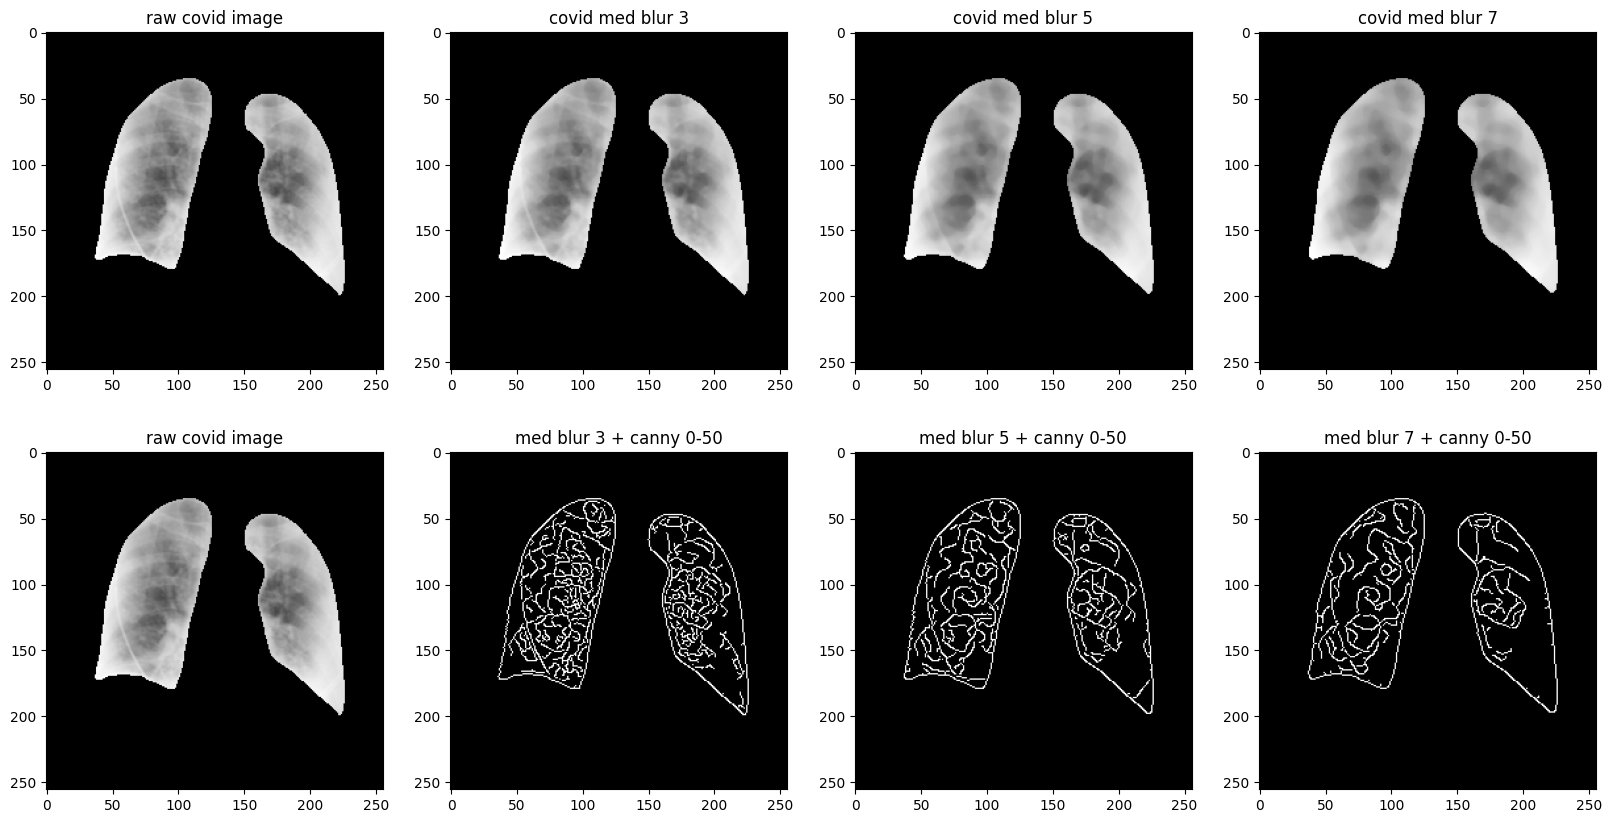

In [10]:
### Step 5.2: Canny edge detection for Median blurred images in COVID samples

###Step 5.2.1: median blur for covid
med_covid_1 = cv2.medianBlur(roi_covid, ksize = 3)
med_covid_2 = cv2.medianBlur(roi_covid, ksize = 5)
med_covid_3 = cv2.medianBlur(roi_covid, ksize = 7)

# STep 5.2.2: Canny detection for COVID
med1_canny = cv2.Canny(med_covid_1, 0, 50)
med2_canny = cv2.Canny(med_covid_2, 0, 50)
med3_canny = cv2.Canny(med_covid_3, 0, 50)



# Step 5.2.3: plot to see how median blur changes the image
# images- covid
fig = plt.figure(figsize=(20,10))
plt.subplot(241),plt.imshow(roi_covid, cmap = 'gray'),plt.title('raw covid image')
plt.subplot(242),plt.imshow(med_covid_1, cmap = 'gray'),plt.title('covid med blur 3')
plt.subplot(243),plt.imshow(med_covid_2, cmap = 'gray'),plt.title('covid med blur 5')
plt.subplot(244),plt.imshow(med_covid_3, cmap = 'gray'),plt.title('covid med blur 7')

plt.subplot(245),plt.imshow(roi_covid, cmap = 'gray'),plt.title('raw covid image')
plt.subplot(246),plt.imshow(med1_canny, cmap = 'gray'),plt.title('med blur 3 + canny 0-50')
plt.subplot(247),plt.imshow(med2_canny, cmap = 'gray'),plt.title('med blur 5 + canny 0-50')
plt.subplot(248),plt.imshow(med3_canny, cmap = 'gray'),plt.title('med blur 7 + canny 0-50')


print ('Median blur and Canny edge detection detects noise as well and we observe the rib cage and some fibres that are caught as structures with edge detection')# best')

print('Median blur 5 and 7 is sort of creating some shpaes which are actually not in the original image. SO, this will not be useful for us')
print('Median blur 3, 3 and a canny filter of 50 looks promising although in normal it catches quite a bit of noise')


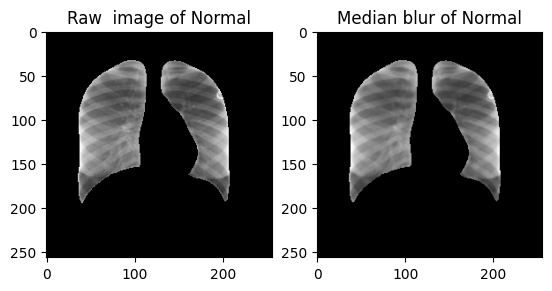

In [11]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############

######### +++++++++++++++++ Step 5.3: Median filter (function)
ksize = [3]# set based on the above run

def median_fil(image, ksize):

    for value in ksize:
        xray_med_fil = cv2.medianBlur(image, value) # the median blur

        #plot the image
        #med_fil_plot = plt.imshow(Xray_med_fil, cmap = 'gray')
        #plt.title('The median blur of ksize', value)

    return xray_med_fil


#Test if the function works
normal_med_fil = median_fil(roi_normal, ksize)# The median blur is only brighthening the white areas even more and blurring the image. WHat we want would be edge detection

# plot in graph
plt.subplot(121),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw  image of Normal')
plt.subplot(122),plt.imshow(normal_med_fil, cmap = 'gray'),plt.title('Median blur of Normal');



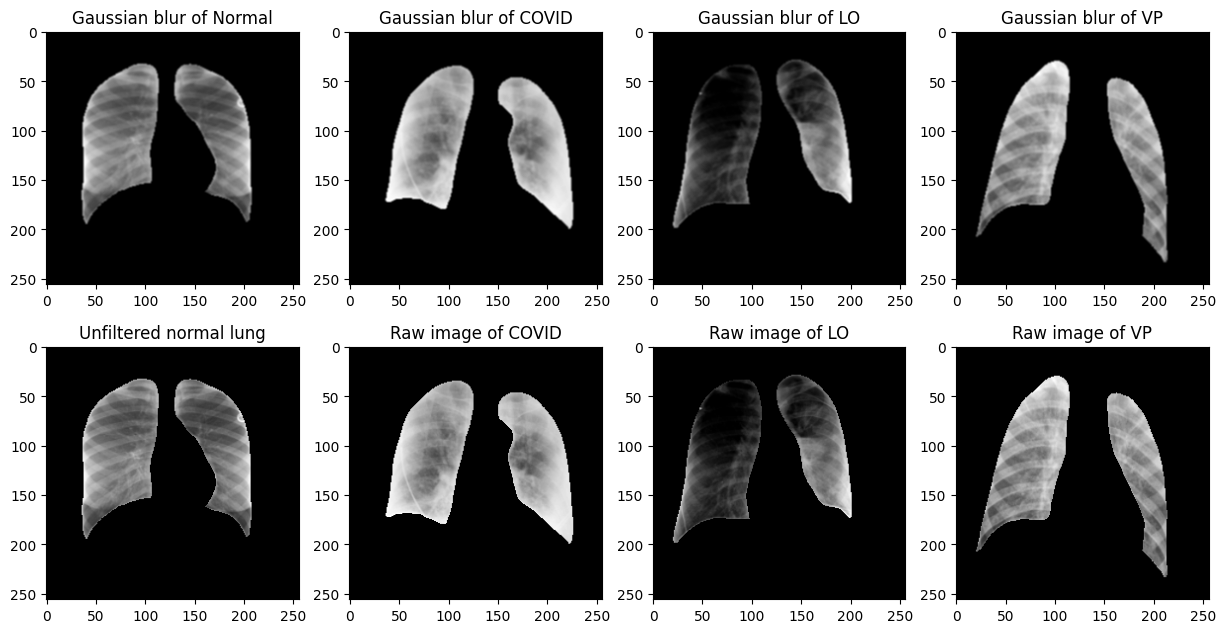

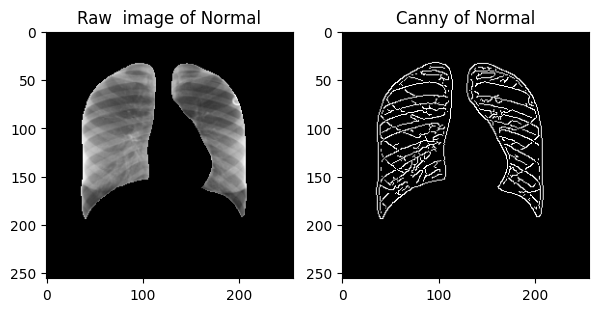

In [12]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############


### Step 5.3: Gaussian filter
#kernel = (3, 3)# , (5, 5), (7, 7)]

def Gau_fil(image):

    # Gaussian blur for the image
    xray_Gau = cv2.GaussianBlur(image, (3, 3), 0)

    return xray_Gau


#Test if the function works
normal_Gau = Gau_fil(roi_normal)# works well with Canny edge detection
covid_Gau = Gau_fil(roi_covid)
lo_Gau = Gau_fil(roi_lo)
vp_Gau = Gau_fil(roi_vp)

# plot in graph
fig = plt.figure(figsize=(15,15))
plt.subplot(141),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Unfiltered normal lung')

plt.subplot(142),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Raw image of COVID')

plt.subplot(143),plt.imshow(roi_lo, cmap = 'gray'),plt.title('Raw image of LO')

plt.subplot(144),plt.imshow(roi_vp, cmap = 'gray'),plt.title('Raw image of VP')

plt.subplot(241),plt.imshow(normal_Gau, cmap = 'gray'),plt.title('Gaussian blur of Normal')

plt.subplot(242),plt.imshow(covid_Gau, cmap = 'gray'),plt.title('Gaussian blur of COVID')

plt.subplot(243),plt.imshow(lo_Gau, cmap = 'gray'),plt.title('Gaussian blur of LO')

plt.subplot(244),plt.imshow(vp_Gau, cmap = 'gray'),plt.title('Gaussian blur of VP');


### Step 5.4: Canny filter using Gaussian blur as base

# Setting the values of the parameters
#min_canny = 0
#max_canny = 75

# Function for Canny
def canny_fil(image, min_canny, max_canny):

    #  Canny edge detection
    xray_canny = cv2.Canny(image, min_canny, max_canny)

    return xray_canny


#Test if the function works
normal_Gau_canny = canny_fil(normal_Gau, min_canny = 0, max_canny = 75 )# works well with Canny edge detection

# plot in graph
fig = plt.figure(figsize=(7,7))
plt.subplot(121),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw  image of Normal')
plt.subplot(122),plt.imshow(normal_Gau_canny, cmap = 'gray'),plt.title('Canny of Normal');





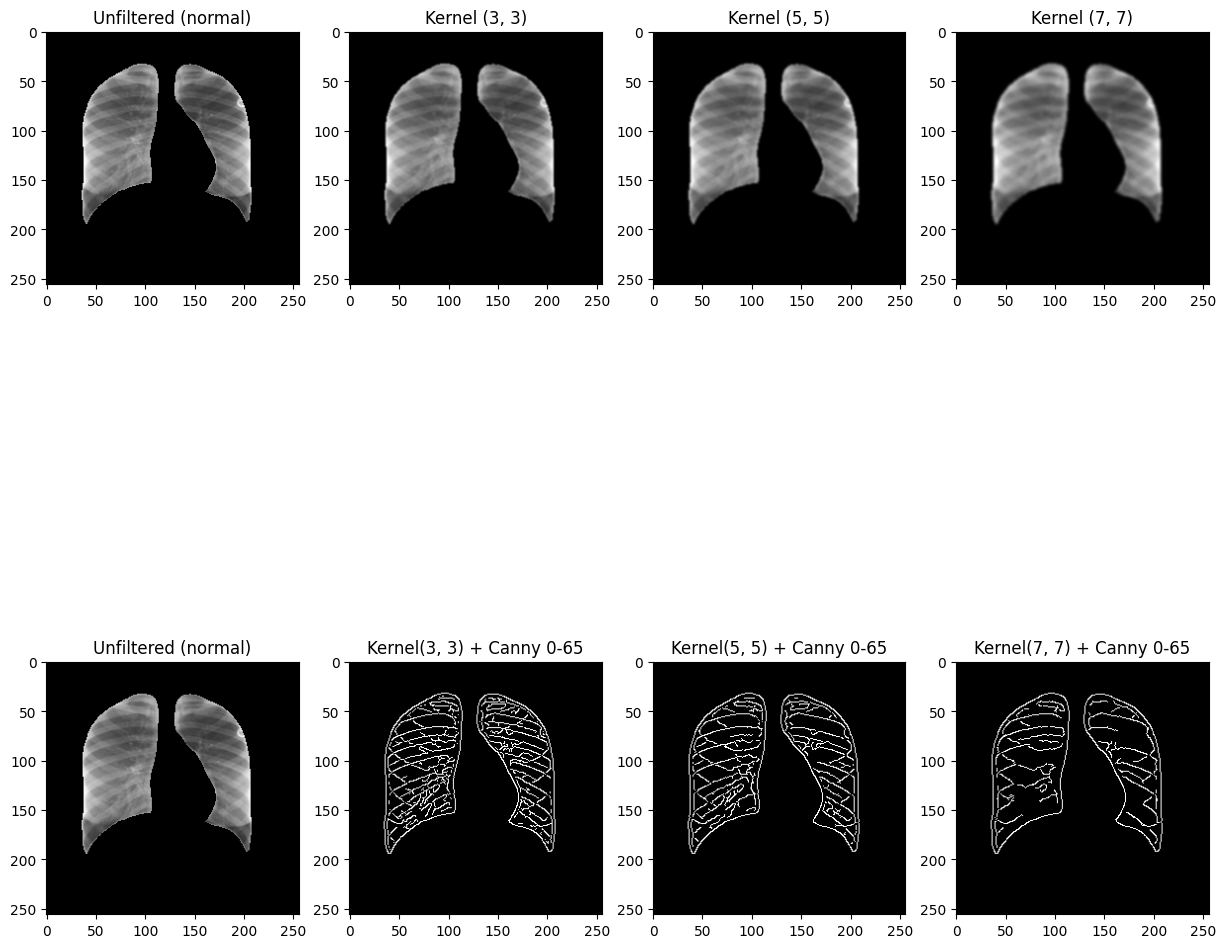

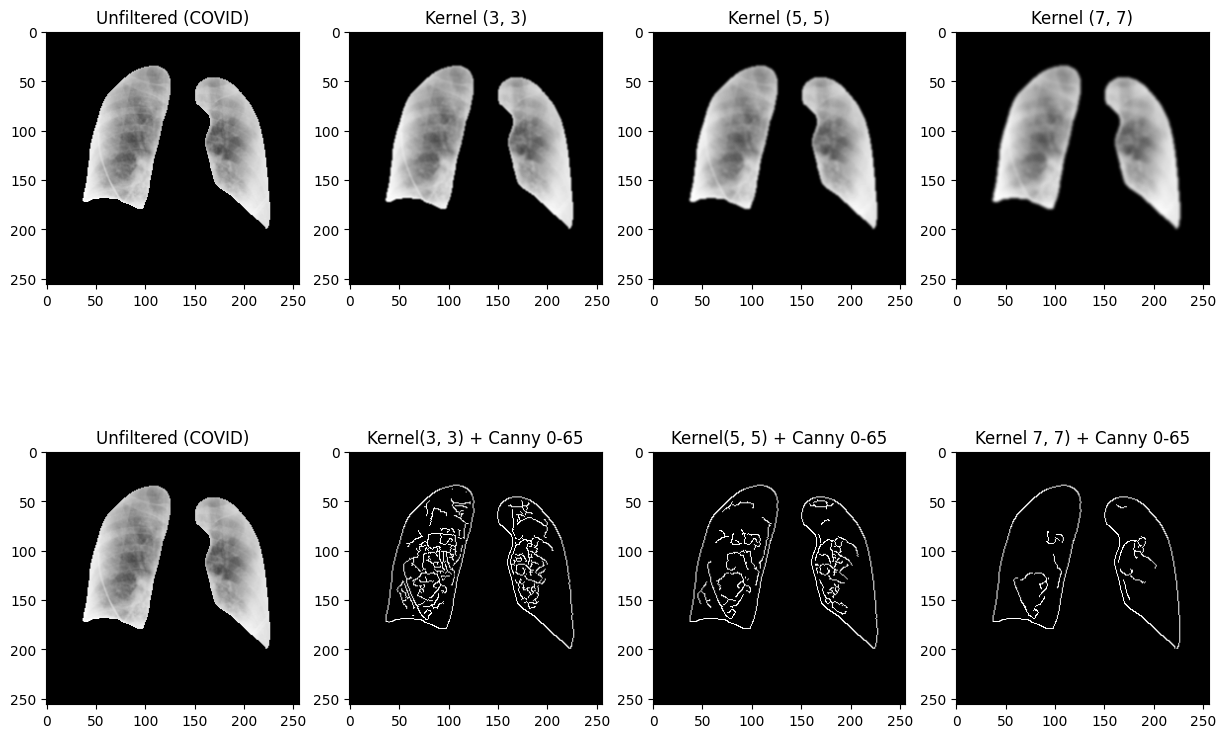

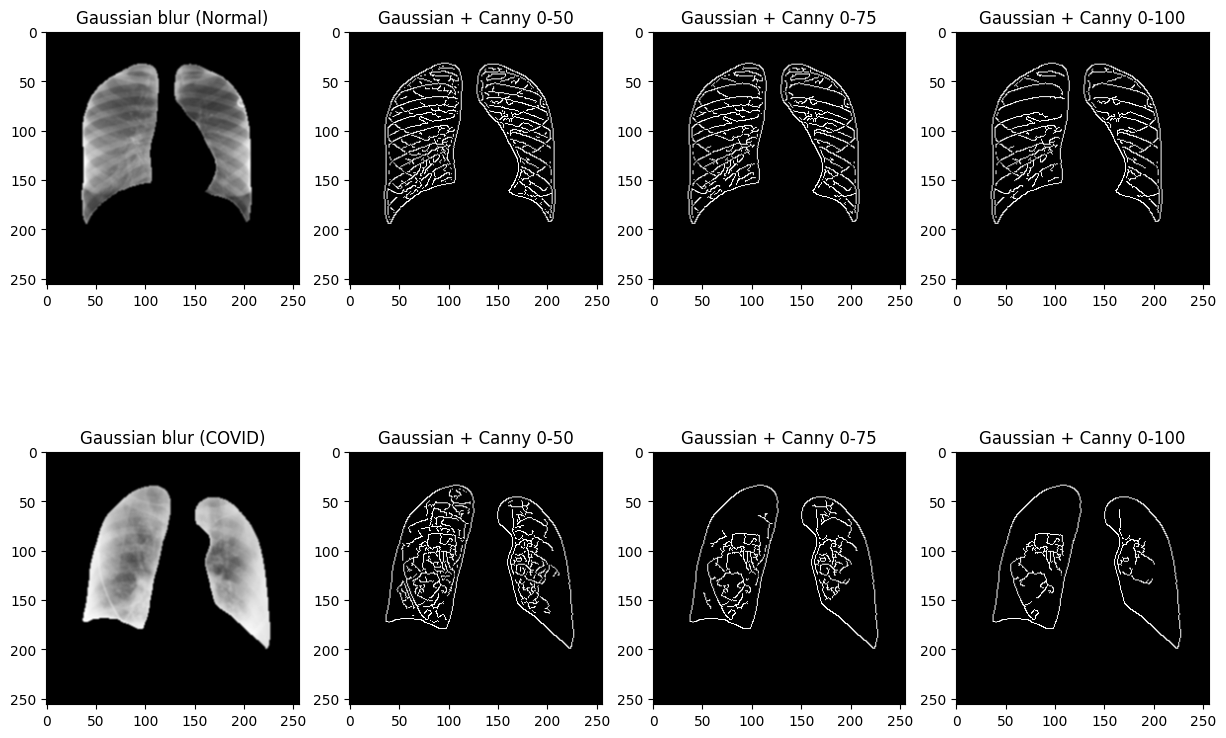

In [13]:
####### +++++++++++++++++++++++++++++++++++++++++++ Detailed analysis of  GAussian blur+ Canny +++++++++++++++++++++++++++++++++++++++++++++++++

####Apply the Gaussian filter- Normal
filter1 = cv2.GaussianBlur(roi_normal, (3, 3), 0)
filter2 = cv2.GaussianBlur(roi_normal, (5, 5), 0)
filter3 = cv2.GaussianBlur(roi_normal, (7, 7), 0)

# Canny filter for normal- diffrent kernel size and diff max threshold values for Canny
edge1 = cv2.Canny(filter1, 0, 50)
edge2 = cv2.Canny(filter1, 0, 75)
edge3 = cv2.Canny(filter1, 0, 100)
edge4 = cv2.Canny(filter2, 0, 50)
edge5 = cv2.Canny(filter3, 0, 50)
edge6 = cv2.Canny(filter1, 0, 65)
edge7 = cv2.Canny(filter2, 0, 65)
edge8 = cv2.Canny(filter3, 0, 65)

####Apply the Gaussian filter-COVID
filter1_covi = cv2.GaussianBlur(roi_covid, (3, 3), 0)
filter2_covi = cv2.GaussianBlur(roi_covid, (5, 5), 0)
filter3_covi = cv2.GaussianBlur(roi_covid, (7, 7), 0)

# Canny filter for COVID
edge1_covi = cv2.Canny(filter1_covi, 0, 50)
edge2_covi = cv2.Canny(filter1_covi, 0, 75)
edge3_covi = cv2.Canny(filter1_covi, 0, 100)

edge4_covi = cv2.Canny(filter2_covi, 0, 50)
edge5_covi = cv2.Canny(filter3_covi, 0, 50)

edge6_covi = cv2.Canny(filter1_covi, 0, 65)
edge7_covi = cv2.Canny(filter2_covi, 0, 65)
edge8_covi = cv2.Canny(filter3_covi, 0, 65)

## PLot to check which kernel size is best- Gaussian blur and Canny for normal
fig = plt.figure(figsize=(15,15))
plt.subplot(241),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Unfiltered (normal)')
plt.subplot(242),plt.imshow(filter1, cmap = 'gray'),plt.title('Kernel (3, 3)')
plt.subplot(243),plt.imshow(filter2, cmap = 'gray'),plt.title('Kernel (5, 5)')
plt.subplot(244),plt.imshow(filter3, cmap = 'gray'),plt.title('Kernel (7, 7)')
plt.subplot(245),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Unfiltered (normal)')
plt.subplot(246),plt.imshow(edge6, cmap = 'gray'),plt.title('Kernel(3, 3) + Canny 0-65')
plt.subplot(247),plt.imshow(edge7, cmap = 'gray'),plt.title('Kernel(5, 5) + Canny 0-65')
plt.subplot(248),plt.imshow(edge8, cmap = 'gray'),plt.title('Kernel(7, 7) + Canny 0-65');


## PLot to check which kernel size is best- Gaussian blur and Canny for COVID
fig1 = plt.figure(figsize=(15,10))
plt.subplot(2,4,1),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Unfiltered (COVID)')
plt.subplot(2,4,2),plt.imshow(filter1_covi, cmap = 'gray'),plt.title('Kernel (3, 3)')
plt.subplot(2,4,3),plt.imshow(filter2_covi, cmap = 'gray'),plt.title('Kernel (5, 5)')
plt.subplot(2,4,4),plt.imshow(filter3_covi, cmap = 'gray'),plt.title('Kernel (7, 7)')
plt.subplot(2,4,5),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Unfiltered (COVID)')
plt.subplot(2,4,6),plt.imshow(edge6_covi, cmap = 'gray'),plt.title('Kernel(3, 3) + Canny 0-65')
plt.subplot(2,4,7),plt.imshow(edge7_covi, cmap = 'gray'),plt.title('Kernel(5, 5) + Canny 0-65')
plt.subplot(2,4,8),plt.imshow(edge8_covi, cmap = 'gray'),plt.title('Kernel 7, 7) + Canny 0-65');



#PLot in a graph- Images for Canny edge detection using a Gaussian filter - Detailed CANNY EDGE DETECTION for report
fig2 = plt.figure(figsize=(15,10))
plt.subplot(241),plt.imshow(filter1, cmap = 'gray'),plt.title('Gaussian blur (Normal)')
plt.subplot(242),plt.imshow(edge1, cmap = 'gray'),plt.title('Gaussian + Canny 0-50')
plt.subplot(243),plt.imshow(edge2, cmap = 'gray'),plt.title('Gaussian + Canny 0-75')
plt.subplot(244),plt.imshow(edge3, cmap = 'gray'),plt.title('Gaussian + Canny 0-100')
plt.subplot(245),plt.imshow(filter1_covi, cmap = 'gray'),plt.title('Gaussian blur (COVID)')
plt.subplot(246),plt.imshow(edge1_covi, cmap = 'gray'),plt.title('Gaussian + Canny 0-50')
plt.subplot(247),plt.imshow(edge2_covi, cmap = 'gray'),plt.title('Gaussian + Canny 0-75')
plt.subplot(248),plt.imshow(edge3_covi, cmap = 'gray'),plt.title('Gaussian + Canny 0-100');



(<Axes: title={'center': 'Canny VP'}>,
 Text(0.5, 1.0, 'Canny VP'))

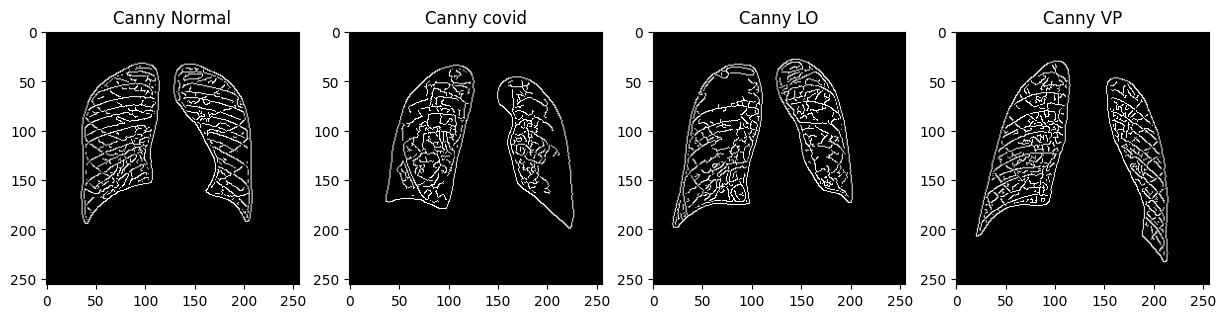

In [14]:
### Unused plots for Gaussian

###Apply the Gaussian filter-LO
filter1_lo = cv2.GaussianBlur(roi_lo, (3, 3), 0)
filter2_lo = cv2.GaussianBlur(roi_lo, (5, 5), 0)
filter3_lo = cv2.GaussianBlur(roi_lo, (7, 7), 0)


# Canny filter for LO
edge1_lo = cv2.Canny(filter1_lo, 0, 50)
edge2_lo = cv2.Canny(filter1_lo, 0, 75)
edge3_lo = cv2.Canny(filter1_lo, 0, 100)


####Apply the Gaussian filter-VP
filter1_vp = cv2.GaussianBlur(roi_vp, (3, 3), 0)
filter2_vp = cv2.GaussianBlur(roi_vp, (5, 5), 0)
filter3_vp = cv2.GaussianBlur(roi_vp, (7, 7), 0)


# Canny filter for VP
edge1_vp = cv2.Canny(filter1_vp, 0, 50)
edge2_vp = cv2.Canny(filter1_vp, 0, 75)
edge3_vp = cv2.Canny(filter1_vp, 0, 100)


#PLot in a graph
fig = plt.figure(figsize=(15,15))
plt.subplot(141),plt.imshow(edge1, cmap = 'gray'),plt.title('Canny Normal')
plt.subplot(142),plt.imshow(edge1_covi, cmap = 'gray'),plt.title('Canny covid')
plt.subplot(143),plt.imshow(edge1_lo, cmap = 'gray'),plt.title('Canny LO')
plt.subplot(144),plt.imshow(edge1_vp, cmap = 'gray'),plt.title('Canny VP')

(<Axes: title={'center': 'Laplacian filter (COVID)'}>,
 Text(0.5, 1.0, 'Laplacian filter (COVID)'))

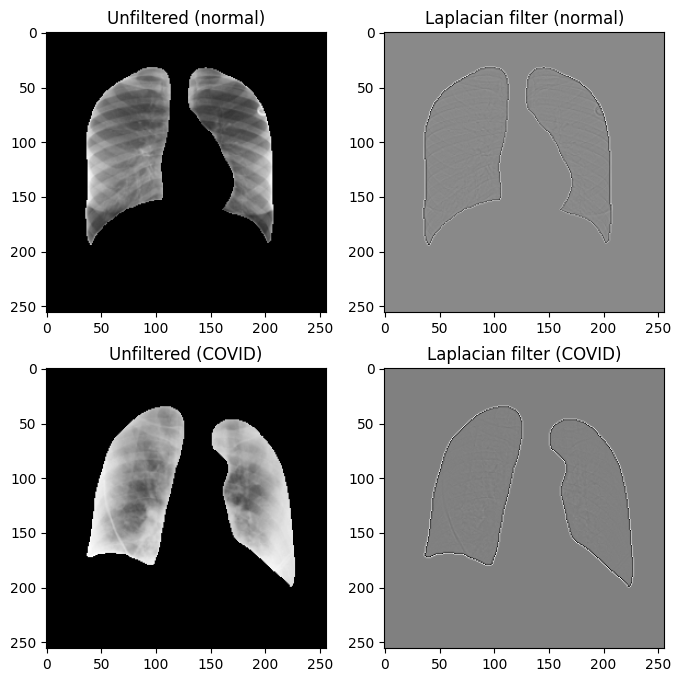

In [15]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############

## Step 5.5: Laplacian filter
def Lap_fil(image):

    xray_lap = cv2.Laplacian(image, ddepth = cv2.CV_64F)# tried ddepth of CV_16S, CV_64F

    return xray_lap

#Test if the function works
normal_Lap_fil = Lap_fil(roi_normal)
covid_Lap_fil =Lap_fil(roi_covid)
#normal_Lap_fil_2 = Lap_fil(roi_normal)
#normal_Lap_fil_3 = Lap_fil(roi_normal)

# plot in graph
fig = plt.figure(figsize=(8,8))
plt.subplot(221),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Unfiltered (normal)')
plt.subplot(222),plt.imshow(normal_Lap_fil, cmap = 'gray'),plt.title('Laplacian filter (normal)')
plt.subplot(223),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Unfiltered (COVID)');
plt.subplot(224),plt.imshow(covid_Lap_fil, cmap = 'gray'),plt.title('Laplacian filter (COVID)')

#plt.subplot(144),plt.imshow(normal_Lap_fil_3, cmap = 'gray'),plt.title('Laplacian Normal (ksize 7)')
#plt.xticks([]), plt.yticks([])
#plt.show()

(<Axes: title={'center': 'Kernel(3,3) + Canny 0-65'}>,
 Text(0.5, 1.0, 'Kernel(3,3) + Canny 0-65'))

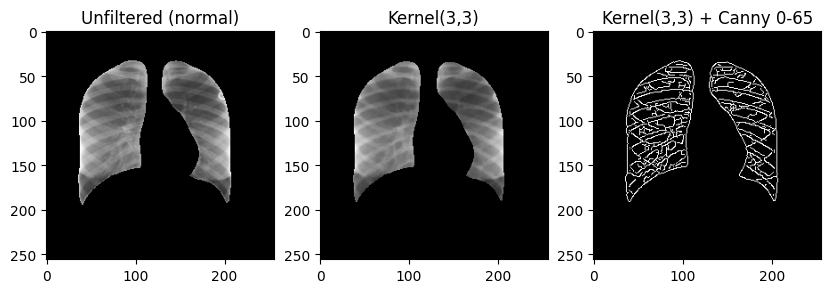

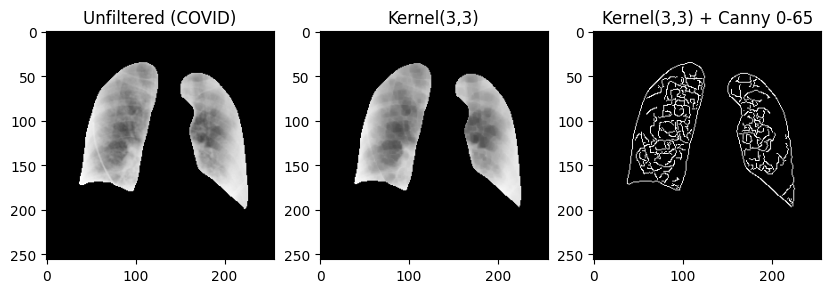

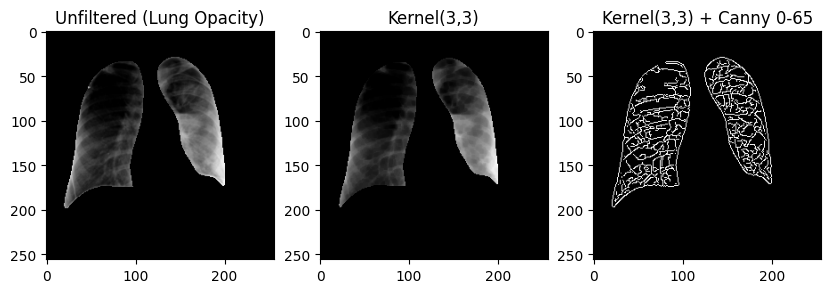

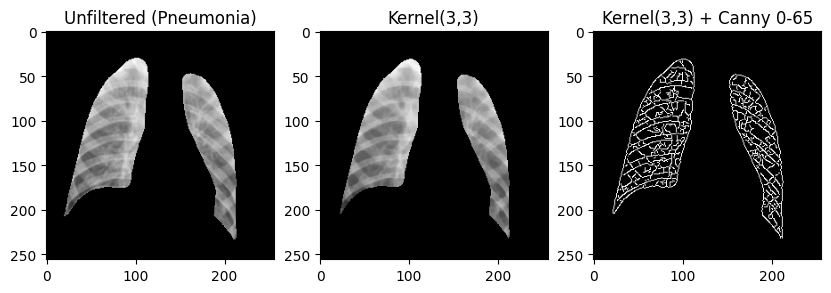

In [16]:
#########++++++++++++++++++++++++++++Step 5:  Filtering images using different techniques (continued) +++++++++++++++++++++++++++++++############


## Step 5.6: Errosion
# Carry out 3 erosions using the erode function of cv2 using 3 convolution cores composed of only 1 but with respective dimensions (3.3), (5.5) and (7.7).
kernel_1 = np.ones((3, 3), np.uint8)
kernel_2 = np.ones((5, 5), np.uint8)
kernel_3 = np.ones((7, 7), np.uint8)

#Define a function for errosion 
def ero_img(image, kernel):

    xray_ero =  cv2.erode(image, kernel)

    return xray_ero

normal_erosion1 = ero_img(roi_normal, kernel_1)# Looks interesting. Check COVID and LO
normal_erosion2 = cv2.erode(roi_normal, kernel_2)
normal_erosion3 = cv2.erode(roi_normal, kernel_3)

covid_erosion = ero_img(roi_covid, kernel_1)
lo_erosion = ero_img(roi_lo, kernel_1)
vp_erosion = ero_img(roi_vp, kernel_1)


# One could try edge detection after errosion 
normal_ero_can = canny_fil(normal_erosion1, min_canny = 0, max_canny = 65)
covid_ero_can = canny_fil(covid_erosion, min_canny = 0, max_canny = 65)
lo_ero_can = canny_fil(lo_erosion, min_canny = 0, max_canny = 65)
vp_ero_can = canny_fil(vp_erosion, min_canny = 0, max_canny = 65)


# plot in graph
fig = plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Unfiltered (normal)')
plt.subplot(132),plt.imshow(normal_erosion1, cmap = 'gray'),plt.title('Kernel(3,3)')
plt.subplot(133),plt.imshow(normal_ero_can, cmap = 'gray'),plt.title('Kernel(3,3) + Canny 0-65');


fig = plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(roi_covid, cmap = 'gray'),plt.title('Unfiltered (COVID)')
plt.subplot(132),plt.imshow(covid_erosion, cmap = 'gray'),plt.title('Kernel(3,3)')
plt.subplot(133),plt.imshow(covid_ero_can, cmap = 'gray'),plt.title('Kernel(3,3) + Canny 0-65');


fig = plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(roi_lo, cmap = 'gray'),plt.title('Unfiltered (Lung Opacity)')
plt.subplot(132),plt.imshow(lo_erosion, cmap = 'gray'),plt.title('Kernel(3,3)')
plt.subplot(133),plt.imshow(lo_ero_can, cmap = 'gray'),plt.title('Kernel(3,3) + Canny 0-65');

fig = plt.figure(figsize=(10,10))
plt.subplot(131),plt.imshow(roi_vp, cmap = 'gray'),plt.title('Unfiltered (Pneumonia)')
plt.subplot(132),plt.imshow(vp_erosion, cmap = 'gray'),plt.title('Kernel(3,3)')
plt.subplot(133),plt.imshow(vp_ero_can, cmap = 'gray'),plt.title('Kernel(3,3) + Canny 0-65')

After trying out different filtering methods, we conclude on the following:

1) Median filter: kernel size (3, 3) blurs the image to a certian extent and a Canny edge detection using a min = 0, max = between 50-75 would be useful. 50 considers noise and 75 eliminates some important structures in the lung. SOmething around 65 should be good
2) Gaussian filter: Functions similar to Median blur.Kernel size 3, and a Canny with min = 0, max = 50-75
3) Laplacian filter : DOes not work at all in our case. It eliminates the outline of important structuresIt will not be used
4) Erosion: Works well with ksize (3, 3) and a Canny min = 0, max = 60

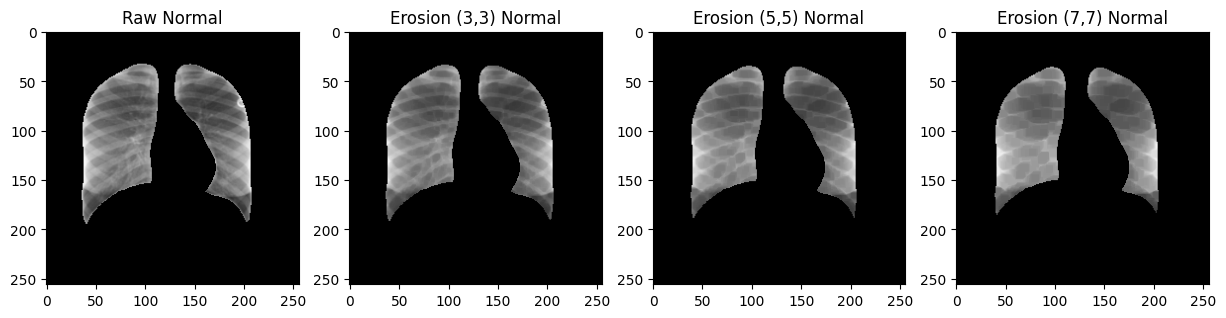

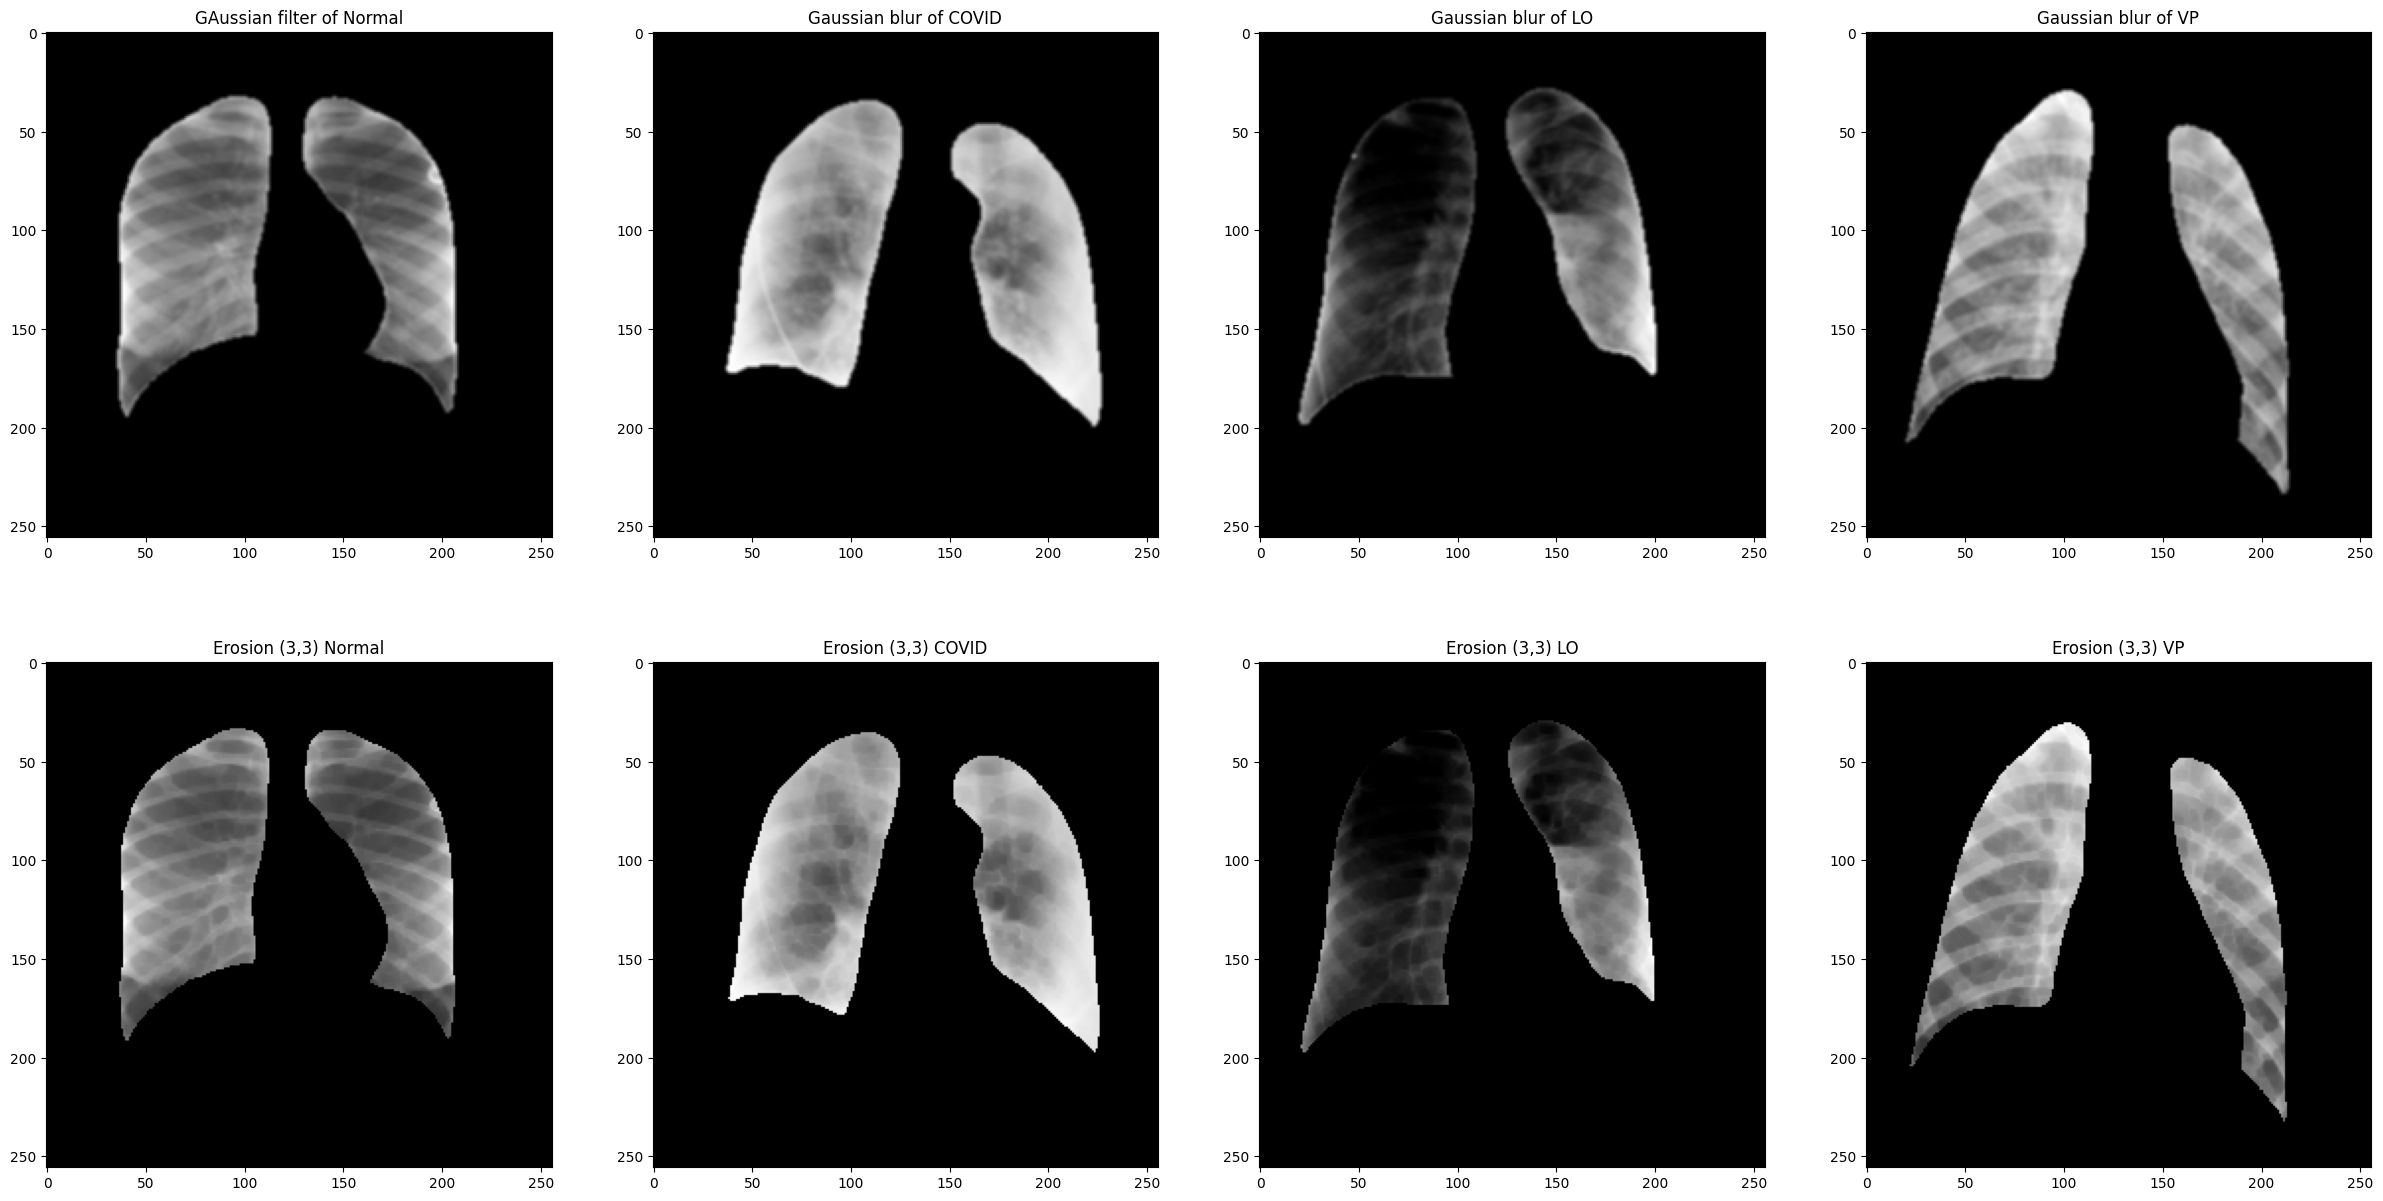

In [17]:
### Erosion plots not used in the report
# plot in graph
fig = plt.figure(figsize=(15,15))
plt.subplot(241),plt.imshow(roi_normal, cmap = 'gray'),plt.title('Raw Normal')
plt.subplot(242),plt.imshow(normal_erosion1, cmap = 'gray'),plt.title('Erosion (3,3) Normal')
plt.subplot(243),plt.imshow(normal_erosion2, cmap = 'gray'),plt.title('Erosion (5,5) Normal')
plt.subplot(244),plt.imshow(normal_erosion3, cmap = 'gray'),plt.title('Erosion (7,7) Normal')



fig = plt.figure(figsize=(30,15))
plt.subplot(241),plt.imshow(normal_Gau, cmap = 'gray'),plt.title('GAussian filter of Normal')
plt.subplot(242),plt.imshow(covid_Gau, cmap = 'gray'),plt.title('Gaussian blur of COVID')
plt.subplot(243),plt.imshow(lo_Gau, cmap = 'gray'),plt.title('Gaussian blur of LO')
plt.subplot(244),plt.imshow(vp_Gau, cmap = 'gray'),plt.title('Gaussian blur of VP')

plt.subplot(246),plt.imshow(covid_erosion, cmap = 'gray'),plt.title('Erosion (3,3) COVID')
plt.subplot(245),plt.imshow(normal_erosion1, cmap = 'gray'),plt.title('Erosion (3,3) Normal')
plt.subplot(247),plt.imshow(lo_erosion, cmap = 'gray'),plt.title('Erosion (3,3) LO')
plt.subplot(248),plt.imshow(vp_erosion, cmap = 'gray'),plt.title('Erosion (3,3) VP')

plt.show()


In [18]:
## Step 6: Apply each of the chosen filters to all images and create 3 diff dataframes for testing in models

#Step 6.1: Create an empty list to add image data after applying each filter
median_blur = []


#Step 6.2: Apply the median blur and Canny filter based on former experiments

for image in lung_area:

    # Median blur
    med_blur = cv2.medianBlur(image, 3) # the median blur

    # Canny blur
    canny_med = cv2.Canny(med_blur, 0, 60)

    # Add data in a list
    median_blur.append(canny_med)

# Add data in a df
med_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'median_Canny_img': median_blur})
    

              name   label                                   median_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


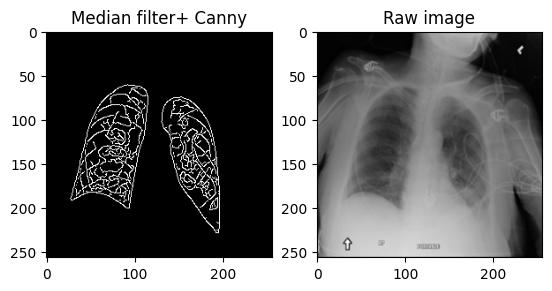

In [19]:
# check the df and check if the images in raw and filtered are the same
print(med_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(med_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(med_canny_lung['median_Canny_img'][i], cmap = 'gray'), plt.title('Median filter+ Canny')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

In [20]:
#Step 6.3: Apply the Gaussian blur + Canny filter

gaussian_blur = []# an empty list
for image in lung_area:

    # Gaussian blur
    gau_blur = cv2.GaussianBlur(image, (3, 3), 0) # the gaussian blur sigmax = 0

    # Canny blur
    canny_gau = cv2.Canny(gau_blur, 0, 65)

    # Add data in a list
    gaussian_blur.append(canny_gau)

# Add data in a df
gau_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'Gau_Canny_img': gaussian_blur})

              name   label                                      Gau_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


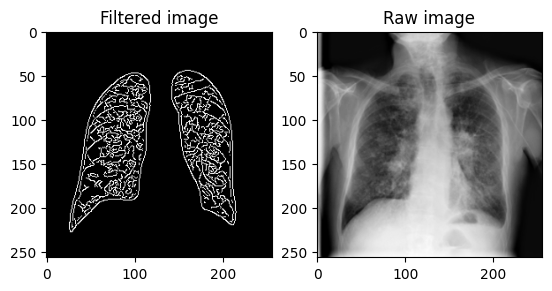

In [21]:
# check the df and check if the images in raw and filtered are the same
print(gau_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(gau_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(gau_canny_lung['Gau_Canny_img'][i], cmap = 'gray'), plt.title('Filtered image')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

In [22]:
#Step 6.4: Apply Erosion + Canny filter

erosion = []# an empty list

for image in lung_area:

    # erosion
    ero = cv2.erode(image,(3, 3)) 

    # Canny blur
    canny_ero = cv2.Canny(ero, 0, 65)

    # Add data in a list
    erosion.append(canny_ero)

# Add data in a df
ero_canny_lung = pd.DataFrame({'name': image_df['name'], 'label': image_df['label'], 'Ero_Canny_img': erosion})

              name   label                                      Ero_Canny_img
0  Normal-6196.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  Normal-7288.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
2  Normal-1821.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  Normal-4781.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  Normal-4959.png  Normal  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...


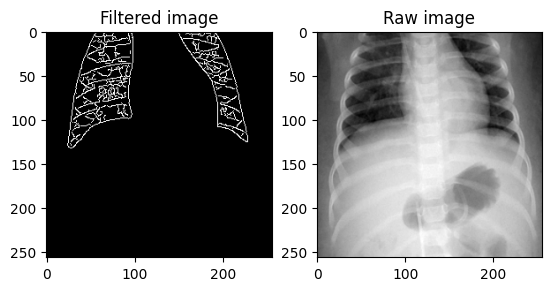

In [23]:
print(ero_canny_lung.head())

#plot and check
for i in np.random.choice(np.arange(0, len(ero_canny_lung)), size = 1):
    plt.subplot(121), plt.imshow(ero_canny_lung['Ero_Canny_img'][i], cmap = 'gray'), plt.title('Filtered image')
    plt.subplot(122), plt.imshow(image_df['image'][i], cmap = 'gray'), plt.title('Raw image')
#image_df.head()

### Creating Dataframes for further Model Training and Testing

In [ ]:
# creating dataset of raw lung images for model training and testing

data_lungs_raw = pd.DataFrame()
for i in range(0,len(lung_data['lung_image'])):
    image_row = pd.DataFrame(lung_data['lung_image'][i][:].reshape([256*256])).transpose()
    image_row['label'] = lung_data['label'][i]
    data_lungs_raw = pd.concat([data_lungs_raw, image_row])
data_lungs_raw.index = range(len(data_lungs_raw))
data_lungs_raw

0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
.. .. .. .. .. .. .. .. .. .. ..  ...    ...    ...    ...    ...    ...   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
0   0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

    65532  65533  65534  65535            label  
0       0      0      0      0           Normal  
0       0      0      0      0           Normal  
0       0      0      0      0           Normal  
0       0      0      0      0           Normal  
0       0      0      0      0           Normal  
..    ...    ...    ...    ...              ...  
0       0      0      0      0  Viral Pneumonia  
0       0      0      0      0  Viral Pneumonia  
0       0      0      0      0  Viral Pneumonia  
0       0      0      0      0  Viral Pneumonia  
0       0      0      0      0  Viral Pneumonia  

[21165 rows x 65537 columns]

In [ ]:
from joblib import dump

# Save the dataframe
dump(data_lungs_raw, '../data/data_lungs_raw.joblib')

In [ ]:
# creating dataset of filtered lung areas for training and testing

data_lungs_filtered = pd.DataFrame()
for i in range(0,len(gau_canny_lung['Gau_Canny_img'])):
    image_row = pd.DataFrame(gau_canny_lung['Gau_Canny_img'][i][:].reshape([256*256])).transpose()
    image_row['label'] = gau_canny_lung['label'][i]
    data_lungs_filtered = pd.concat([data_lungs_filtered, image_row])
data_lungs_filtered.index = range(len(data_lungs_filtered))
data_lungs_filtered

0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0      0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
1      0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2      0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3      0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4      0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
...   .. .. .. .. .. .. .. .. .. ..  ...    ...    ...    ...    ...    ...   
21160  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
21161  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
21162  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
21163  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
21164  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

       65532  65533  65534  65535            label  
0          0      0      0      0           Normal  
1          0      0      0      0           Normal  
2          0      0      0      0           Normal  
3          0      0      0      0           Normal  
4          0      0      0      0           Normal  
...      ...    ...    ...    ...              ...  
21160      0      0      0      0  Viral Pneumonia  
21161      0      0      0      0  Viral Pneumonia  
21162      0      0      0      0  Viral Pneumonia  
21163      0      0      0      0  Viral Pneumonia  
21164      0      0      0      0  Viral Pneumonia  

[21165 rows x 65537 columns]

In [ ]:
# Save the dataframe
dump(data_lungs_filtered, '../data/data_lungs_filtered.joblib')

# Classification of ROI and ROI+filters

In [ ]:
import nbformat

def merge_notebooks(notebook_paths, output_path):
    # Load the notebooks
    notebooks = [nbformat.read(path, as_version=4) for path in notebook_paths]
    
    # Create a new notebook
    merged_notebook = nbformat.v4.new_notebook()
    
    # Combine the cells from all notebooks
    for notebook in notebooks:
        merged_notebook.cells.extend(notebook.cells)
    
    # Save the merged notebook
    with open(output_path, 'w') as f:
        nbformat.write(merged_notebook, f)

# Paths to the notebooks to be merged
notebook_paths = ['Preprocessing and Classification.ipynb', 'Aleksandra_Processed_Data_Classical_Models.ipynb']
output_path = '.ipynb'

# Merge the notebooks
merge_notebooks(notebook_paths, output_path)

In [24]:
#Importing libraries

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Do not forget to change the paths to .joblib files

## 1. Classification of ROI (no filters)

In [25]:
import joblib

file_path = '../data/data_lungs_raw.joblib'
loaded_object = joblib.load(file_path)

print(type(loaded_object))

<class 'pandas.core.frame.DataFrame'>


In [26]:
print(loaded_object.head())

   0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

   65532  65533  65534  65535   label  
0      0      0      0      0  Normal  
1      0      0      0      0  Normal  
2      0      0      0      0  Normal  
3      0      0      0      0  Normal  
4      0      0      0      0  Normal  

[5 rows x 65537 columns]


In [27]:
print(loaded_object.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Columns: 65537 entries, 0 to label
dtypes: object(1), uint8(65536)
memory usage: 1.3+ GB
None


#### Splitting the dataset (80% for training and 20% for testing)

In [29]:
import joblib
from sklearn.model_selection import train_test_split

file_path = '../data/data_lungs_raw.joblib'
loaded_data = joblib.load(file_path)

X = loaded_data.drop(columns=['label']) 
y = loaded_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


#### Calculating statistical weights

In [19]:
import numpy as np
import pickle
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

class_weights_path = 'class_weights.pkl'
with open(class_weights_path, 'wb') as f:
    pickle.dump(class_weights_dict, f)

#### Importing standard scaler

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 1.1. Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=123)

rf_classifier.fit(X_train_scaled, y_train)

y_pred = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

import pickle

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights_dict, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)


Accuracy: 0.7543


In [17]:
from sklearn.metrics import classification_report

y_pred = rf_classifier.predict(X_test_scaled)

report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.75      0.37      0.49       726
   Lung_Opacity       0.76      0.75      0.75      1236
Viral Pneumonia       0.74      0.92      0.82      1995
          COVID       0.93      0.62      0.75       276

       accuracy                           0.75      4233
      macro avg       0.80      0.66      0.70      4233
   weighted avg       0.76      0.75      0.74      4233



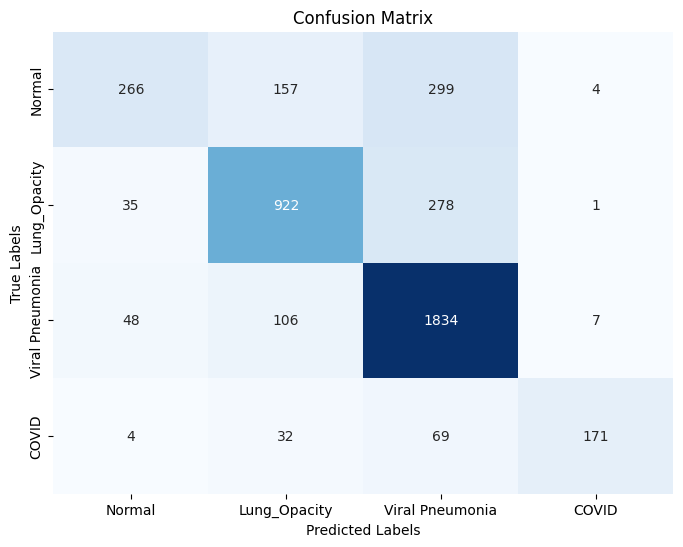

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import pickle

with open('random_forest_model.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

with open('standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('class_weights.pkl', 'rb') as f:
    class_weights_dict = pickle.load(f)

with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)


## 1.2. Bagging with Random Forest

In [20]:
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the Bagging classifier
bagging_classifier = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=123)
bagging_classifier.fit(X_train_scaled, y_train)

with open('bagging_classifier.pkl', 'wb') as f:
    pickle.dump(bagging_classifier, f)

with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [21]:
# Load the Bagging classifier
with open('bagging_classifier.pkl', 'rb') as f:
    bagging_classifier = pickle.load(f)

# Load the class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Evaluate the Bagging classifier
y_pred = bagging_classifier.predict(X_test_scaled)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.78      0.29      0.42       726
   Lung_Opacity       0.74      0.74      0.74      1236
Viral Pneumonia       0.72      0.93      0.81      1995
          COVID       0.95      0.57      0.71       276

       accuracy                           0.74      4233
      macro avg       0.80      0.63      0.67      4233
   weighted avg       0.75      0.74      0.72      4233

Confusion Matrix:
 [[ 208  180  335    3]
 [  29  918  288    1]
 [  27  113 1850    5]
 [   2   28   89  157]]


In [22]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7401370186628868


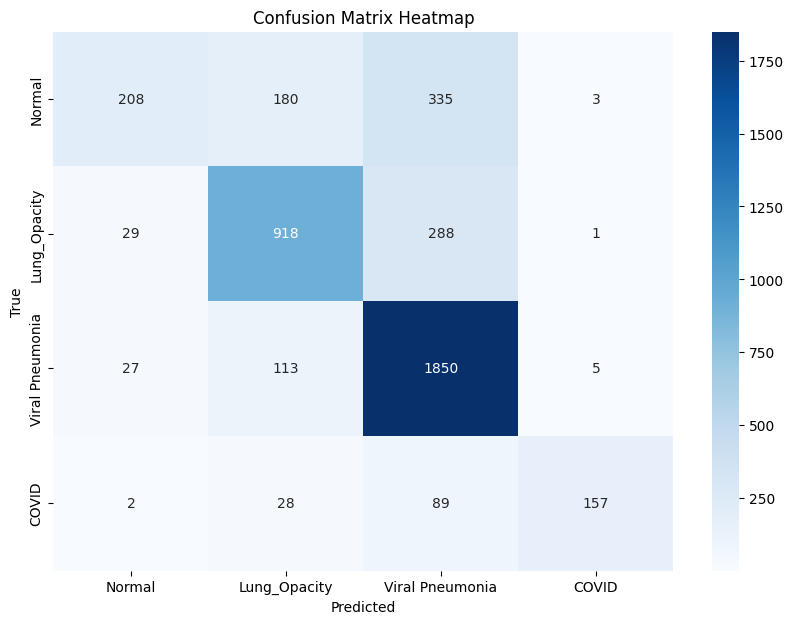

In [23]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

## 1.3. XG Boost

In [25]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=4, scale_pos_weight=class_weights)
xgb_classifier.fit(X_train_scaled, y_train_encoded)

# Save the XGBoost classifier
xgb_classifier.save_model('xgb_classifier.json')

# Save the class weights
with open('class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

# Save the categories
with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [08:51:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.74      0.48      0.58       726
   Lung_Opacity       0.77      0.77      0.77      1236
Viral Pneumonia       0.79      0.91      0.85      1995
          COVID       0.94      0.80      0.87       276

       accuracy                           0.79      4233
      macro avg       0.81      0.74      0.77      4233
   weighted avg       0.79      0.79      0.78      4233

Confusion Matrix:
 [[ 346  157  222    1]
 [  57  946  232    1]
 [  57  102 1825   11]
 [   5   19   31  221]]
Accuracy: 0.788566028821167


<function matplotlib.pyplot.title(label: 'str', fontdict: 'dict[str, Any] | None' = None, loc: "Literal['left', 'center', 'right'] | None" = None, pad: 'float | None' = None, *, y: 'float | None' = None, **kwargs) -> 'Text'>

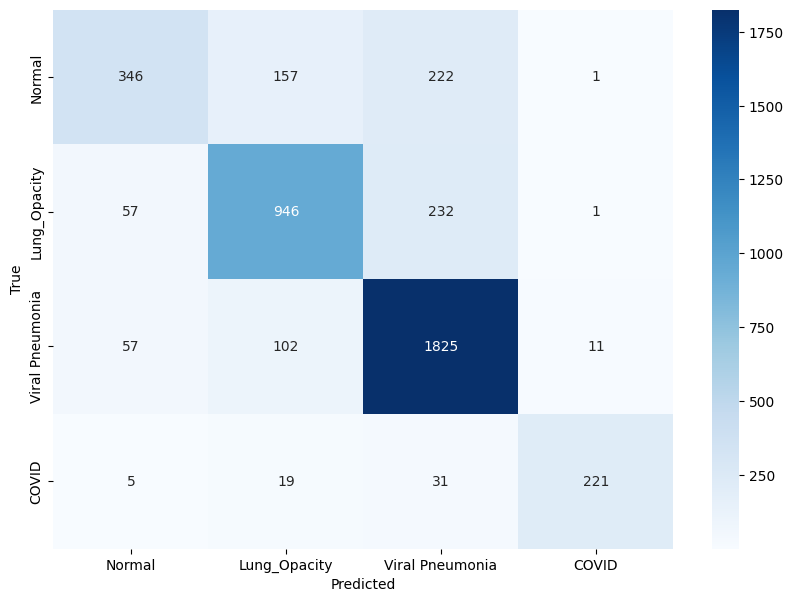

In [26]:
# Load the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.load_model('xgb_classifier.json')

# Load the class weights
with open('class_weights.pkl', 'rb') as f:
    class_weights = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Evaluate the XGBoost classifier
y_pred_encoded = xgb_classifier.predict(X_test_scaled)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=categories)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title

# 2. Classification of ROI + Filters

In [30]:
import joblib

file_path_2 = '../data/data_lungs_filtered.joblib'
loaded_object_2 = joblib.load(file_path_2)

print(type(loaded_object_2))

<class 'pandas.core.frame.DataFrame'>


In [22]:
print(loaded_object_2.head())

   0  1  2  3  4  5  6  7  8  9  ...  65527  65528  65529  65530  65531  \
0  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
1  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
2  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
3  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   
4  0  0  0  0  0  0  0  0  0  0  ...      0      0      0      0      0   

   65532  65533  65534  65535   label  
0      0      0      0      0  Normal  
1      0      0      0      0  Normal  
2      0      0      0      0  Normal  
3      0      0      0      0  Normal  
4      0      0      0      0  Normal  

[5 rows x 65537 columns]


#### Splitting the dataset (80% for training and 20% for testing)

In [31]:
import joblib
from sklearn.model_selection import train_test_split

file_path_2 = '../data/data_lungs_filtered.joblib'
loaded_data_2 = joblib.load(file_path_2)

X_filtered = loaded_data_2.drop(columns=['label'])  
y_filtered = loaded_data_2['label']

X_filtered_train, X_filtered_test, y_filtered_train, y_filtered_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=123)


#### Calculating statistical weights

In [24]:
import numpy as np
import pickle
from sklearn.utils import class_weight

# Example: Compute class weights
class_weights_filtered = class_weight.compute_class_weight('balanced', classes=np.unique(y_filtered_train), y=y_filtered_train)
class_weights_filtered_dict = dict(enumerate(class_weights_filtered))

# Save class weights using pickle
class_weights_filtered_path = 'class_weights_filtered.pkl'
with open(class_weights_filtered_path, 'wb') as f:
    pickle.dump(class_weights_dict, f)


#### Importing standard scaler

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_filtered_train_scaled = scaler.fit_transform(X_filtered_train)
X_filtered_test_scaled = scaler.transform(X_filtered_test)


## 2.1. Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier_filtered = RandomForestClassifier(n_estimators=100, random_state=123)

rf_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train)

y_filtered_pred = rf_classifier_filtered.predict(X_filtered_test_scaled)

accuracy = accuracy_score(y_filtered_test, y_filtered_pred)
print(f'Accuracy: {accuracy:.4f}')

import pickle

with open('random_forest_model_filtered.pkl', 'wb') as f:
    pickle.dump(rf_classifier_filtered, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered_dict, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

Accuracy: 0.5615


In [36]:
import pickle

with open('random_forest_model_filtered.pkl', 'rb') as f:
    rf_classifier_filtered = pickle.load(f)

with open('standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered_dict = pickle.load(f)

with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)


In [37]:
from sklearn.metrics import classification_report

y_filtered_pred = rf_classifier_filtered.predict(X_filtered_test_scaled)

report2 = classification_report(y_filtered_test, y_filtered_pred, target_names=categories)
print("Classification Report:\n", report)


Classification Report:
                  precision    recall  f1-score   support

         Normal       0.74      0.48      0.58       726
   Lung_Opacity       0.77      0.77      0.77      1236
Viral Pneumonia       0.79      0.91      0.85      1995
          COVID       0.94      0.80      0.87       276

       accuracy                           0.79      4233
      macro avg       0.81      0.74      0.77      4233
   weighted avg       0.79      0.79      0.78      4233



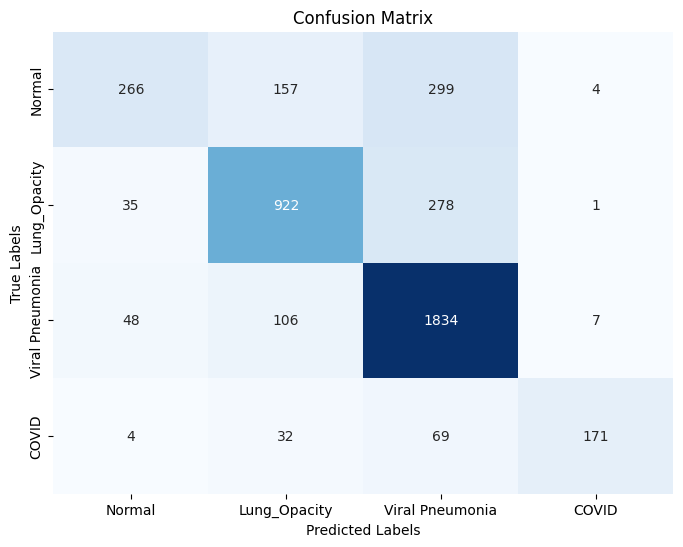

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm2 = confusion_matrix(y_filtered_test, y_filtered_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## 2.2. Bagging with Random Forest

In [39]:
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the Bagging classifier
bagging_classifier_filtered = BaggingClassifier(estimator=RandomForestClassifier(), n_estimators=100, random_state=123)
bagging_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train)

with open('bagging_classifier_filtered.pkl', 'wb') as f:
    pickle.dump(bagging_classifier_filtered, f)

with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered, f)

with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [40]:
# Load the Bagging classifier
with open('bagging_classifier_filtered.pkl', 'rb') as f:
    bagging_classifier_filtered = pickle.load(f)

# Load the class weights
with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Evaluate the Bagging classifier
y_filtered_pred = bagging_classifier_filtered.predict(X_filtered_test_scaled)

# Generate the classification report
report2 = classification_report(y_filtered_test, y_filtered_pred, target_names=categories)
print("Classification Report:\n", report2)

# Generate the confusion matrix
conf_matrix2 = confusion_matrix(y_filtered_test, y_filtered_pred)
print("Confusion Matrix:\n", conf_matrix2)

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.95      0.03      0.05       726
   Lung_Opacity       0.62      0.35      0.44      1236
Viral Pneumonia       0.53      0.94      0.68      1995
          COVID       1.00      0.01      0.02       276

       accuracy                           0.55      4233
      macro avg       0.78      0.33      0.30      4233
   weighted avg       0.66      0.55      0.46      4233

Confusion Matrix:
 [[  20  132  574    0]
 [   1  427  808    0]
 [   0  119 1876    0]
 [   0   12  261    3]]


In [41]:
accuracy2 = accuracy_score(y_filtered_test, y_filtered_pred)
print("Accuracy:", accuracy2)

Accuracy: 0.549492085991023


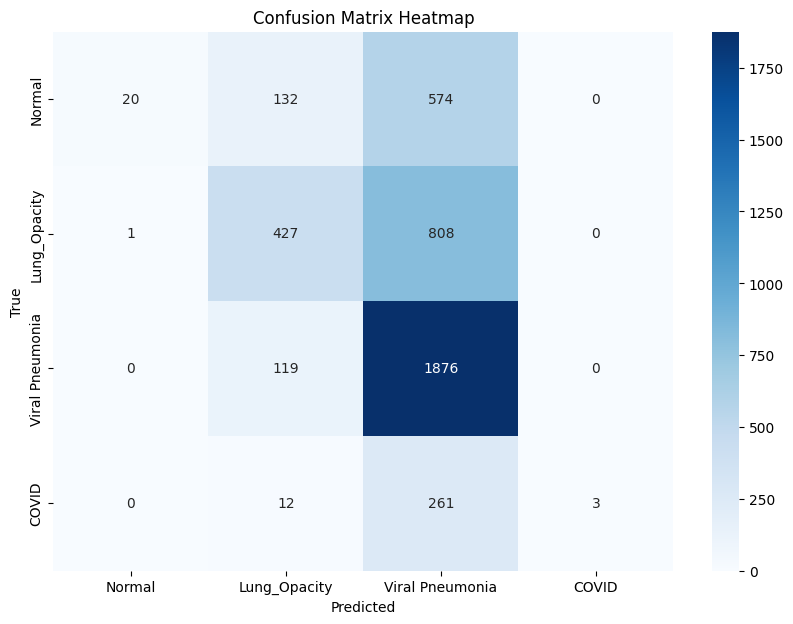

In [42]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

## 2.3. XG Boost

In [44]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Encode the labels
label_encoder = LabelEncoder()
y_filtered_train_encoded = label_encoder.fit_transform(y_filtered_train)
y_filtered_test_encoded = label_encoder.transform(y_filtered_test)

# Train the XGBoost classifier
xgb_classifier_filtered = xgb.XGBClassifier(objective='multi:softmax', num_class=4, scale_pos_weight=class_weights_filtered)
xgb_classifier_filtered.fit(X_filtered_train_scaled, y_filtered_train_encoded)

# Save the XGBoost classifier
xgb_classifier_filtered.save_model('xgb_classifier_filtered.json')

# Save the class weights
with open('class_weights_filtered.pkl', 'wb') as f:
    pickle.dump(class_weights_filtered, f)

# Save the categories
with open('categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the label encoder
with open('label_encoder_filtered.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:14:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [46]:
import pickle
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the XGBoost classifier
xgb_classifier_filtered = xgb.XGBClassifier()
xgb_classifier_filtered.load_model('xgb_classifier_filtered.json')

# Load the class weights
with open('class_weights_filtered.pkl', 'rb') as f:
    class_weights_filtered = pickle.load(f)

# Load the categories
with open('categories.pkl', 'rb') as f:
    categories = pickle.load(f)

# Load the scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Load the label encoder
with open('label_encoder_filtered.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Encode the true labels
y_filtered_test_encoded = label_encoder.transform(y_filtered_test)

# Evaluate the XGBoost classifier
y_filtered_pred_encoded = xgb_classifier_filtered.predict(X_filtered_test_scaled)

# Generate the classification report
report2 = classification_report(y_filtered_test_encoded, y_filtered_pred_encoded, target_names=categories)
print("Classification Report:\n", report2)

# Generate the confusion matrix
conf_matrix2 = confusion_matrix(y_filtered_test_encoded, y_filtered_pred_encoded)
print("Confusion Matrix:\n", conf_matrix2)

Classification Report:
                  precision    recall  f1-score   support

         Normal       0.50      0.16      0.24       726
   Lung_Opacity       0.58      0.56      0.57      1236
Viral Pneumonia       0.64      0.85      0.73      1995
          COVID       0.85      0.51      0.64       276

       accuracy                           0.62      4233
      macro avg       0.64      0.52      0.54      4233
   weighted avg       0.61      0.62      0.59      4233

Confusion Matrix:
 [[ 113  230  379    4]
 [  64  693  478    1]
 [  47  238 1690   20]
 [   3   24  108  141]]


In [47]:
# Calculate the accuracy
accuracy2 = accuracy_score(y_filtered_test_encoded, y_filtered_pred_encoded)
print("Accuracy:", accuracy2)

Accuracy: 0.622962437987243


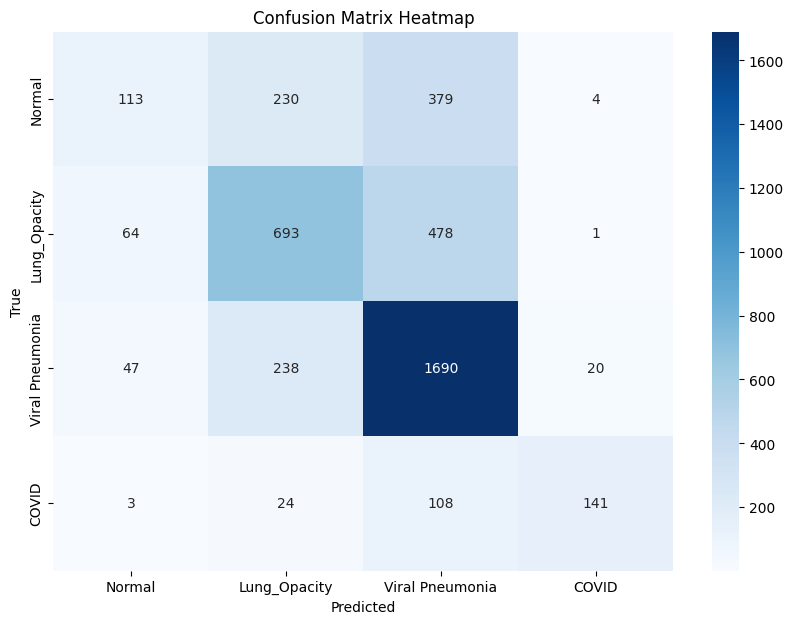

In [48]:
# Plot heatmap of confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Summarizing the results and creation of dataframe for ROI (no filters)

In [58]:
results = {
    'Model': ['Random Forest', 'Bagging', 'XGBoost'],
    'Accuracy': [0.75, 0.74, 0.79],
    'Precision_Normal': [0.75, 0.78, 0.74],
    'Recall_Normal': [0.37, 0.29, 0.48],
    'F1-Score_Normal': [0.49, 0.42, 0.58],
    'Precision_Lung_Opacity': [0.76, 0.74, 0.77],
    'Recall_Lung_Opacity': [0.75, 0.74, 0.77],
    'F1-Score_Lung_Opacity': [0.75, 0.74, 0.77],
    'Precision_Viral_Pneumonia': [0.74, 0.72, 0.79],
    'Recall_Viral_Pneumonia': [0.92, 0.93, 0.91],
    'F1-Score_Viral_Pneumonia': [0.82, 0.81, 0.85],
    'Precision_COVID': [0.93, 0.95, 0.94],
    'Recall_COVID': [0.62, 0.57, 0.80],
    'F1-Score_COVID': [0.75, 0.71, 0.87]
}

summary_classification_df = pd.DataFrame(results)
summary_classification_df.head()


Model  Accuracy  Precision_Normal  Recall_Normal  F1-Score_Normal  \
0  Random Forest      0.75              0.75           0.37             0.49   
1        Bagging      0.74              0.78           0.29             0.42   
2        XGBoost      0.79              0.74           0.48             0.58   

   Precision_Lung_Opacity  Recall_Lung_Opacity  F1-Score_Lung_Opacity  \
0                    0.76                 0.75                   0.75   
1                    0.74                 0.74                   0.74   
2                    0.77                 0.77                   0.77   

   Precision_Viral_Pneumonia  Recall_Viral_Pneumonia  \
0                       0.74                    0.92   
1                       0.72                    0.93   
2                       0.79                    0.91   

   F1-Score_Viral_Pneumonia  Precision_COVID  Recall_COVID  F1-Score_COVID  
0                      0.82             0.93          0.62            0.75  
1                      0.81             0.95          0.57            0.71  
2                      0.85             0.94          0.80            0.87

#### Visualization of accuracies

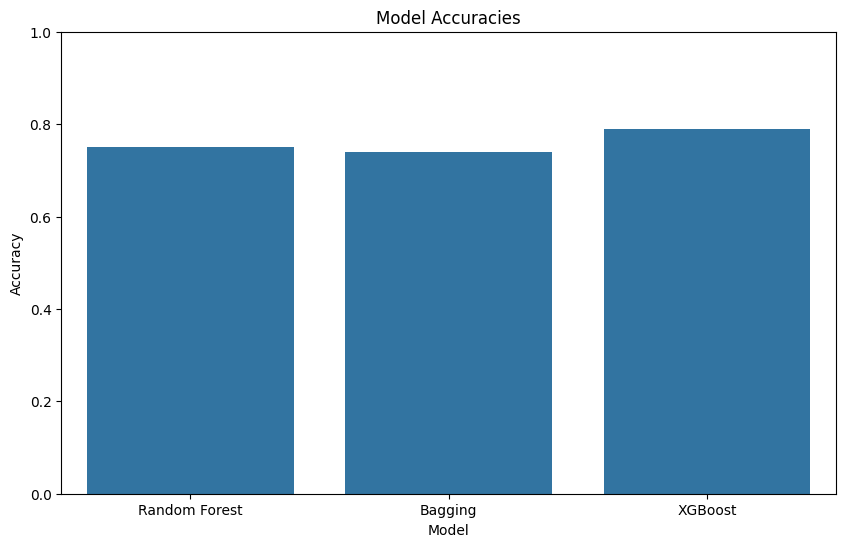

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_classification_df)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()


#### Melting the dataframe and visualization (Precision, Recall, F1-Score)

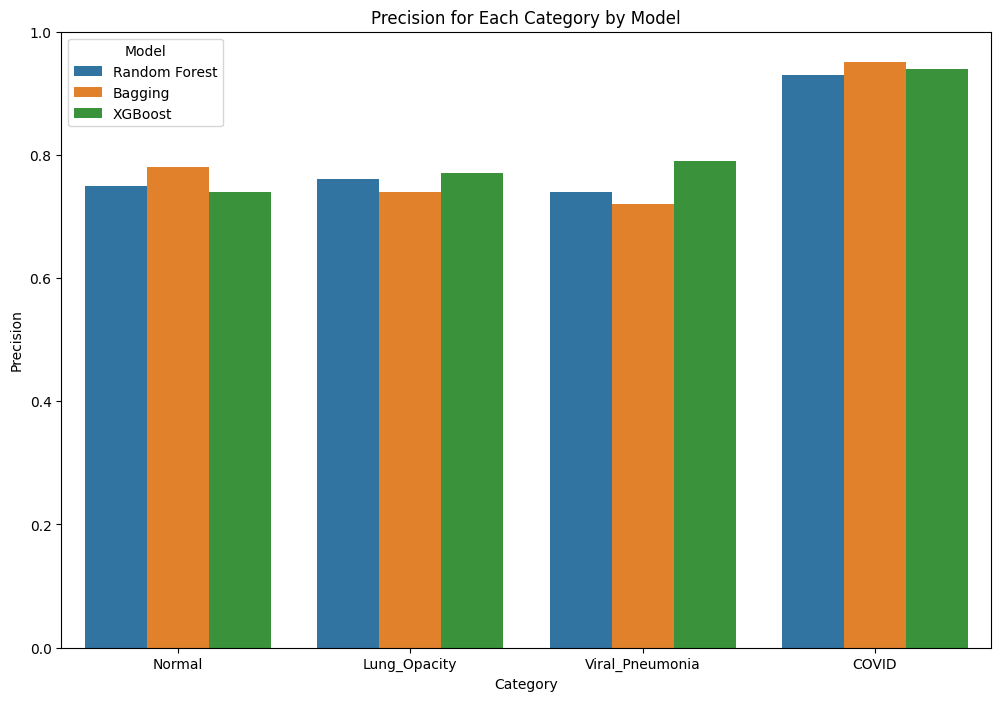

In [63]:
# Melting the DataFrame for precision values
precision_df = summary_classification_df.melt(id_vars=['Model'], 
                                              value_vars=[f'Precision_{category}' for category in categories],
                                              var_name='Category', value_name='Precision')


precision_df['Category'] = precision_df['Category'].str.replace('Precision_', '')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Category', y='Precision', hue='Model', data=precision_df)
plt.title('Precision for Each Category by Model')
plt.ylabel('Precision')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

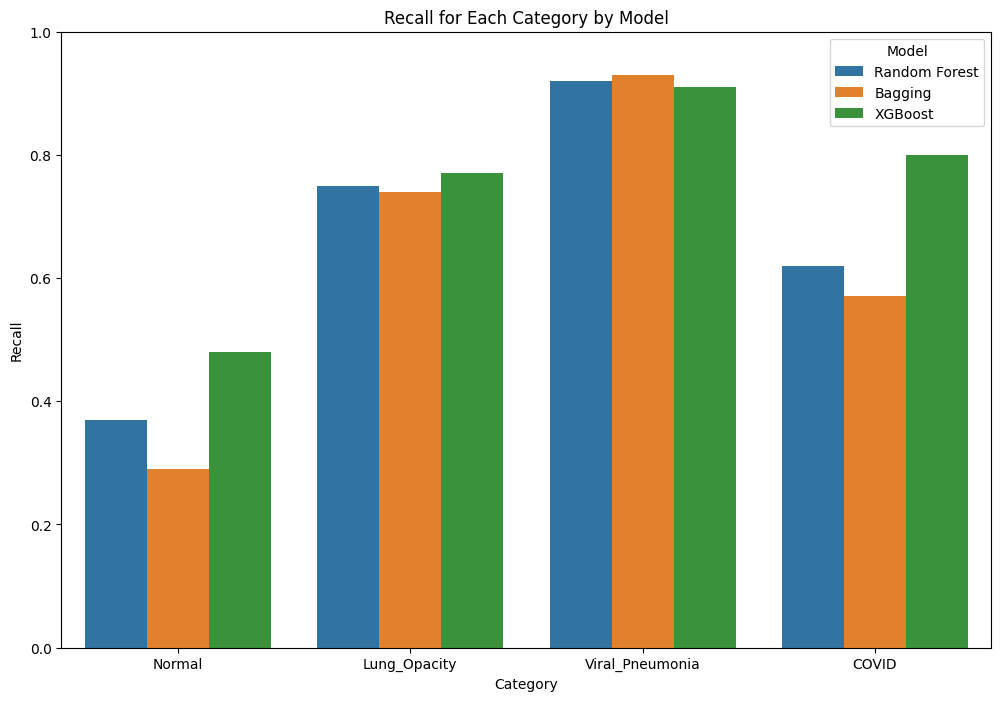

In [64]:
recall_df = summary_classification_df.melt(id_vars=['Model'], 
                                           value_vars=[f'Recall_{category}' for category in categories],
                                           var_name='Metric', value_name='Value')


recall_df['Metric'] = recall_df['Metric'].str.replace('Recall_', '')

# Plotting Recall
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=recall_df)
plt.title('Recall for Each Category by Model')
plt.ylabel('Recall')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()



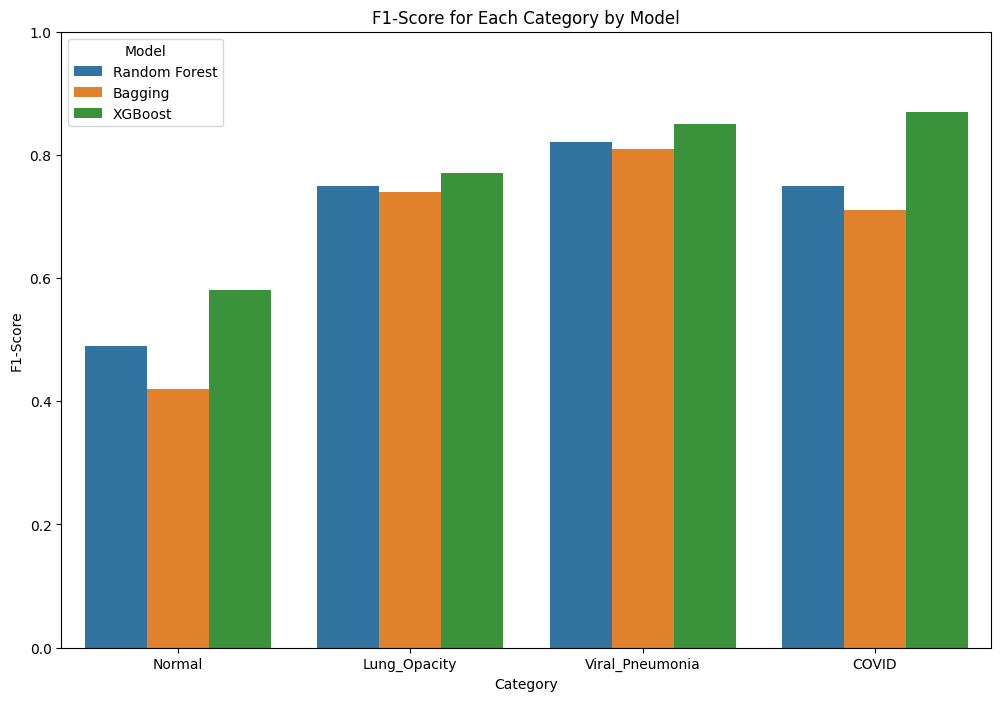

In [65]:
f1_score_df = summary_classification_df.melt(id_vars=['Model'], 
                                             value_vars=[f'F1-Score_{category}' for category in categories],
                                             var_name='Metric', value_name='Value')

# Removing the 'F1-Score_' prefix
f1_score_df['Metric'] = f1_score_df['Metric'].str.replace('F1-Score_', '')

# Plotting F1-Score
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=f1_score_df)
plt.title('F1-Score for Each Category by Model')
plt.ylabel('F1-Score')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()


#### Calculation and visualization of ROC Curves for ROI (no filters)

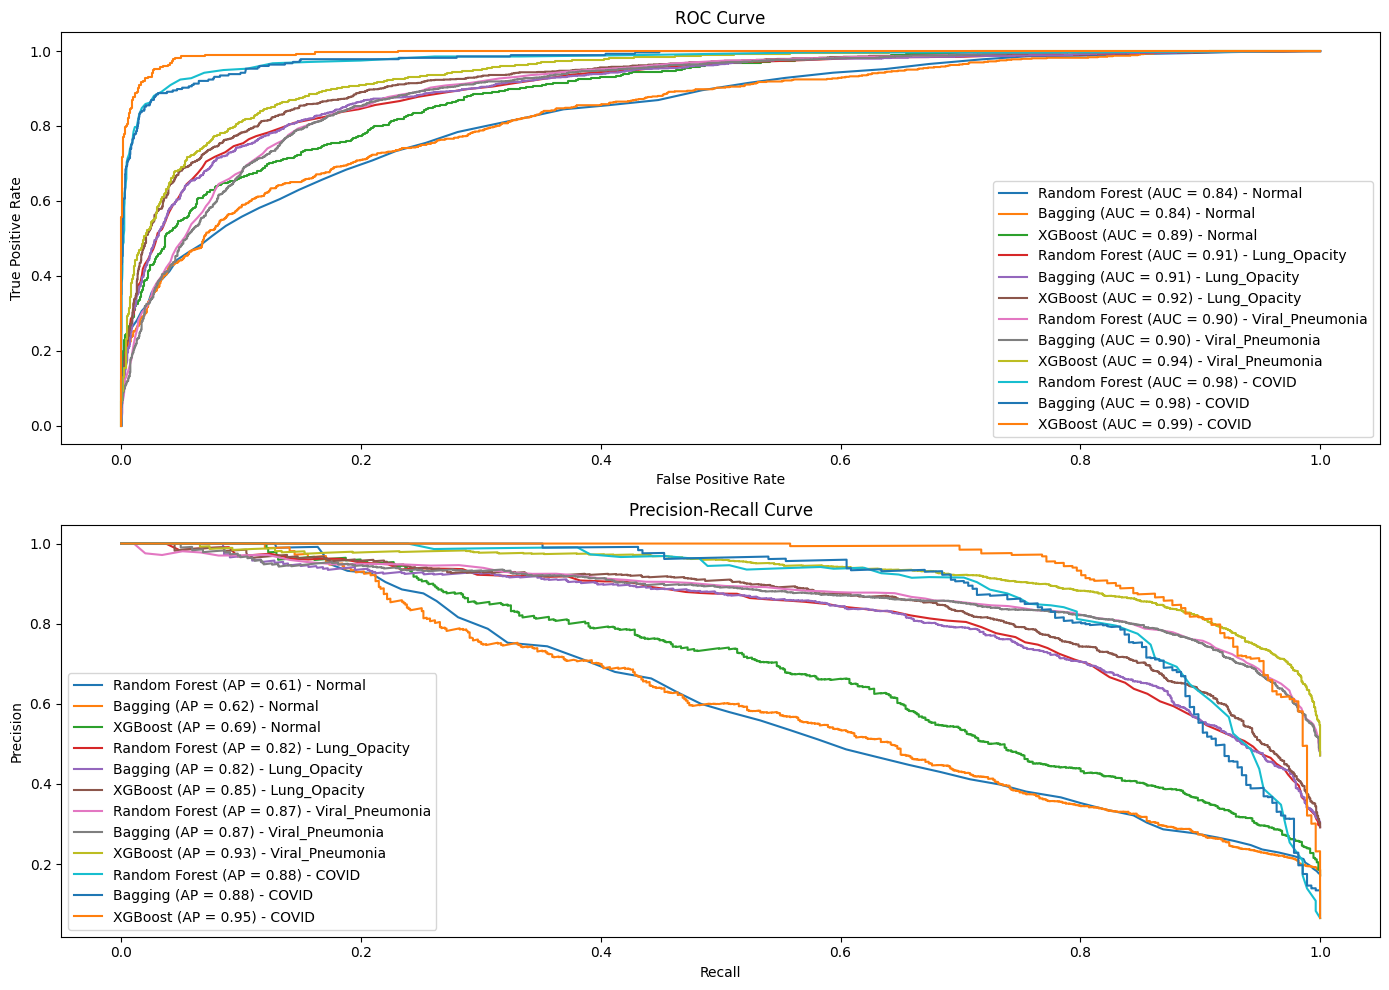

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get predicted probabilities
rf_y_prob = rf_classifier.predict_proba(X_test_scaled)
bagging_y_prob = bagging_classifier.predict_proba(X_test_scaled)
xgb_y_prob = xgb_classifier.predict_proba(X_test_scaled)

# Initialize plots for ROC and PR curves
plt.figure(figsize=(14, 10))

# Calculate ROC and PR curves for each class
for i, category in enumerate(categories):
    # Random Forest
    rf_fpr, rf_tpr, _ = roc_curve(y_test_encoded == i, rf_y_prob[:, i])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    rf_precision, rf_recall, _ = precision_recall_curve(y_test_encoded == i, rf_y_prob[:, i])
    rf_average_precision = average_precision_score(y_test_encoded == i, rf_y_prob[:, i])

    # Bagging Classifier
    bagging_fpr, bagging_tpr, _ = roc_curve(y_test_encoded == i, bagging_y_prob[:, i])
    bagging_roc_auc = auc(bagging_fpr, bagging_tpr)
    bagging_precision, bagging_recall, _ = precision_recall_curve(y_test_encoded == i, bagging_y_prob[:, i])
    bagging_average_precision = average_precision_score(y_test_encoded == i, bagging_y_prob[:, i])

    # XGBoost
    xgb_fpr, xgb_tpr, _ = roc_curve(y_test_encoded == i, xgb_y_prob[:, i])
    xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_test_encoded == i, xgb_y_prob[:, i])
    xgb_average_precision = average_precision_score(y_test_encoded == i, xgb_y_prob[:, i])

    # Plot ROC curve
    plt.subplot(2, 1, 1)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f}) - {category}')
    plt.plot(bagging_fpr, bagging_tpr, label=f'Bagging (AUC = {bagging_roc_auc:.2f}) - {category}')
    plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f}) - {category}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    # Plot PR curve
    plt.subplot(2, 1, 2)
    plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_average_precision:.2f}) - {category}')
    plt.plot(bagging_recall, bagging_precision, label=f'Bagging (AP = {bagging_average_precision:.2f}) - {category}')
    plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_average_precision:.2f}) - {category}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()


#### Calculation and visualization of Feature Importances for ROI (no filters)

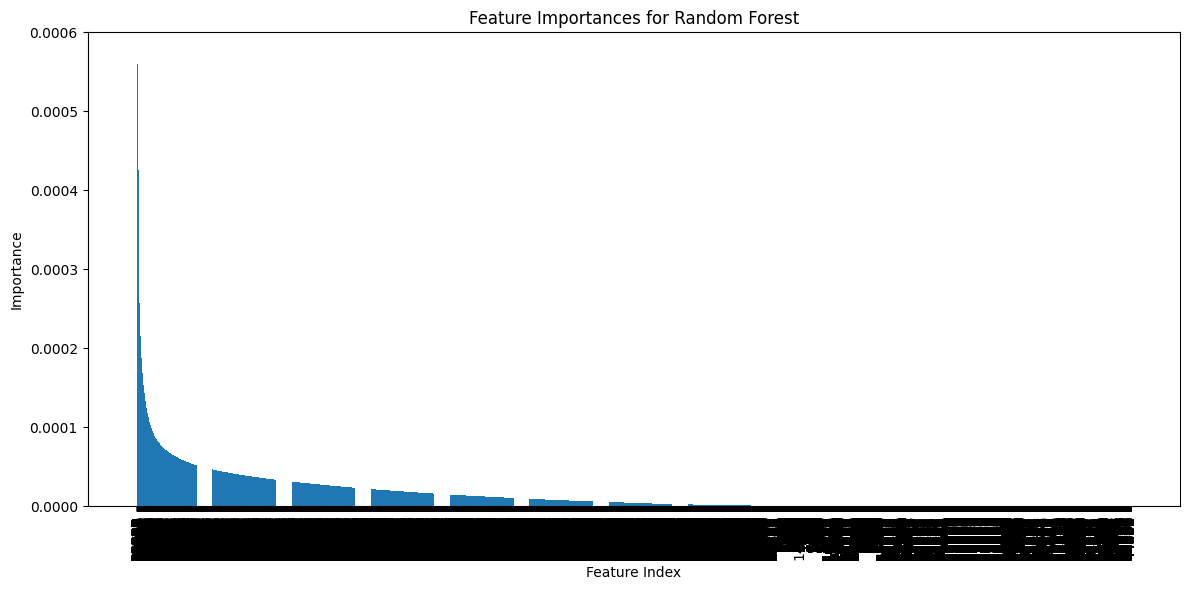

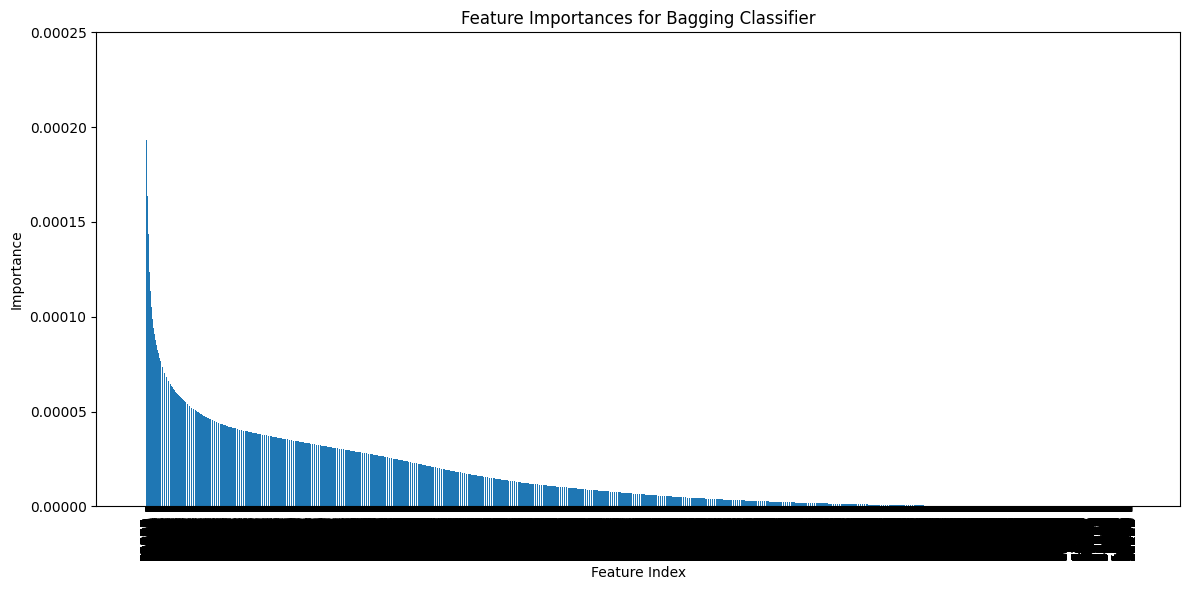

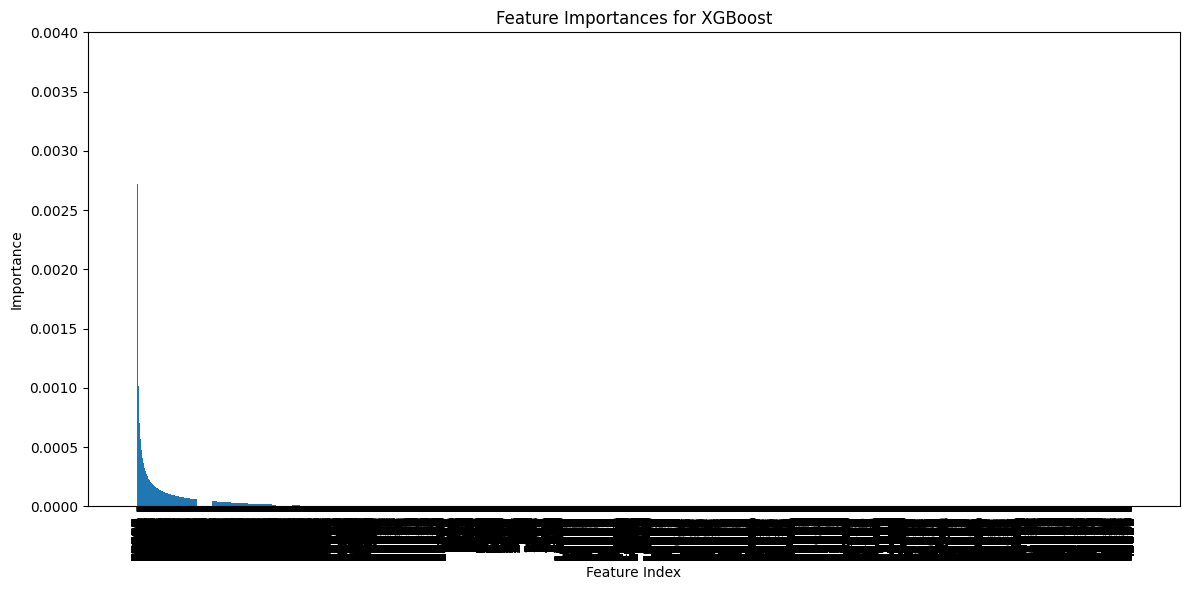

In [53]:
# Plot feature importances for Random Forest and Bagging Classifier
for model_name, model in models.items():
    if model_name == 'Random Forest':
        importances = model.feature_importances_
        ylim = (0, 0.0006)
    elif model_name == 'Bagging Classifier':
        importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
        ylim = (0, 0.00025)
    else:
        continue

    indices = np.argsort(importances)[::-1]
    features = X.columns

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), features[indices], rotation=90)
    plt.ylim(*ylim)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importances for XGBoost
xgb_importances = xgb_classifier.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
features = X.columns

plt.figure(figsize=(12, 6))
plt.title('Feature Importances for XGBoost')
plt.bar(range(X.shape[1]), xgb_importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.ylim(0, 0.004)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



## Summary and creation of dataframe for ROI + Filters

In [31]:
import pandas as pd

results_filtered = {
    'Model': ['Random Forest', 'Bagging', 'XGBoost'],
    'Accuracy': [0.56, 0.55, 0.62],
    'Precision_Normal': [0.74, 0.95, 0.50],
    'Recall_Normal': [0.48, 0.03, 0.16],
    'F1-Score_Normal': [0.58, 0.05, 0.24],
    'Precision_Lung_Opacity': [0.77, 0.62, 0.58],
    'Recall_Lung_Opacity': [0.77, 0.35, 0.56],
    'F1-Score_Lung_Opacity': [0.77, 0.44, 0.57],
    'Precision_Viral_Pneumonia': [0.79, 0.53, 0.64],
    'Recall_Viral Pneumonia': [0.91, 0.94, 0.85],
    'F1-Score_Viral_Pneumonia': [0.85, 0.68, 0.73],
    'Precision_COVID': [0.94, 1.00, 0.85],
    'Recall_COVID': [0.80, 0.01, 0.51],
    'F1-Score_COVID': [0.87, 0.02, 0.64]
}

summary_classification_filtered_df = pd.DataFrame(results_filtered)
summary_classification_filtered_df.head()

Model  Accuracy  Precision_Normal  Recall_Normal  F1-Score_Normal  \
0  Random Forest      0.56              0.74           0.48             0.58   
1        Bagging      0.55              0.95           0.03             0.05   
2        XGBoost      0.62              0.50           0.16             0.24   

   Precision_Lung_Opacity  Recall_Lung_Opacity  F1-Score_Lung_Opacity  \
0                    0.77                 0.77                   0.77   
1                    0.62                 0.35                   0.44   
2                    0.58                 0.56                   0.57   

   Precision_Viral_Pneumonia  Recall_Viral Pneumonia  \
0                       0.79                    0.91   
1                       0.53                    0.94   
2                       0.64                    0.85   

   F1-Score_Viral_Pneumonia  Precision_COVID  Recall_COVID  F1-Score_COVID  
0                      0.85             0.94          0.80            0.87  
1                      0.68             1.00          0.01            0.02  
2                      0.73             0.85          0.51            0.64

#### Visualization of accuracies

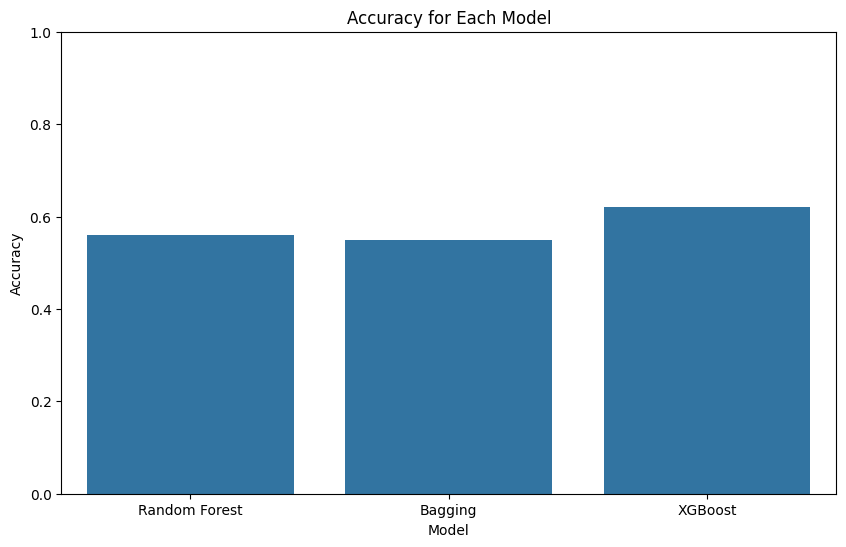

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plotting the accuracies for each model
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=summary_classification_filtered_df)
plt.title('Accuracy for Each Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()


#### Melting the dataframe and visualization for ROI + Filters (Precision, Recall, F1-Score)

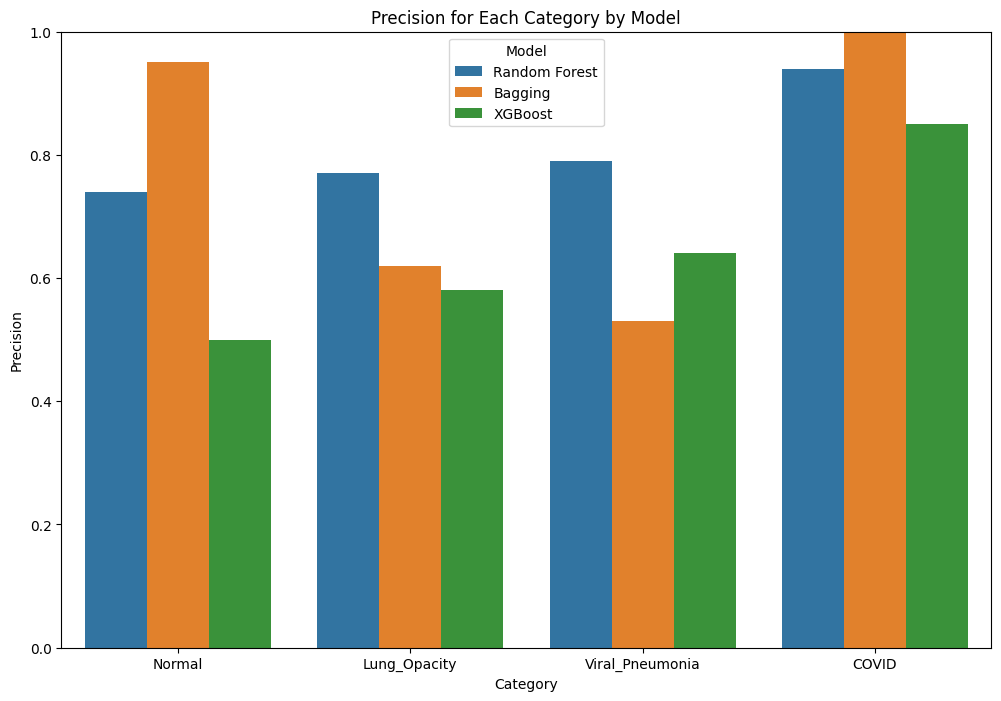

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Correcting the 'results_filtered' dictionary
results_filtered = {
    'Model': ['Random Forest', 'Bagging', 'XGBoost'],
    'Accuracy': [0.56, 0.55, 0.62],
    'Precision_Normal': [0.74, 0.95, 0.50],
    'Recall_Normal': [0.48, 0.03, 0.16],
    'F1-Score_Normal': [0.58, 0.05, 0.24],
    'Precision_Lung_Opacity': [0.77, 0.62, 0.58],
    'Recall_Lung_Opacity': [0.77, 0.35, 0.56],
    'F1-Score_Lung_Opacity': [0.77, 0.44, 0.57],
    'Precision_Viral_Pneumonia': [0.79, 0.53, 0.64],
    'Recall_Viral_Pneumonia': [0.91, 0.94, 0.85],
    'F1-Score_Viral_Pneumonia': [0.85, 0.68, 0.73],
    'Precision_COVID': [0.94, 1.00, 0.85],
    'Recall_COVID': [0.80, 0.01, 0.51],
    'F1-Score_COVID': [0.87, 0.02, 0.64]
}

# Create DataFrame
summary_classification_filtered_df = pd.DataFrame(results_filtered)

# Define categories list
categories = ['Normal', 'Lung_Opacity', 'Viral_Pneumonia', 'COVID']

# Melting the DataFrame for precision values
precision_filtered_df = summary_classification_filtered_df.melt(
    id_vars=['Model'], 
    value_vars=[f'Precision_{category}' for category in categories],
    var_name='Metric', 
    value_name='Value'
)

# Adjust the Metric column to remove 'Precision_'
precision_filtered_df['Metric'] = precision_filtered_df['Metric'].str.replace('Precision_', '')

# Plotting Precision
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=precision_filtered_df)
plt.title('Precision for Each Category by Model')
plt.ylabel('Precision')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()


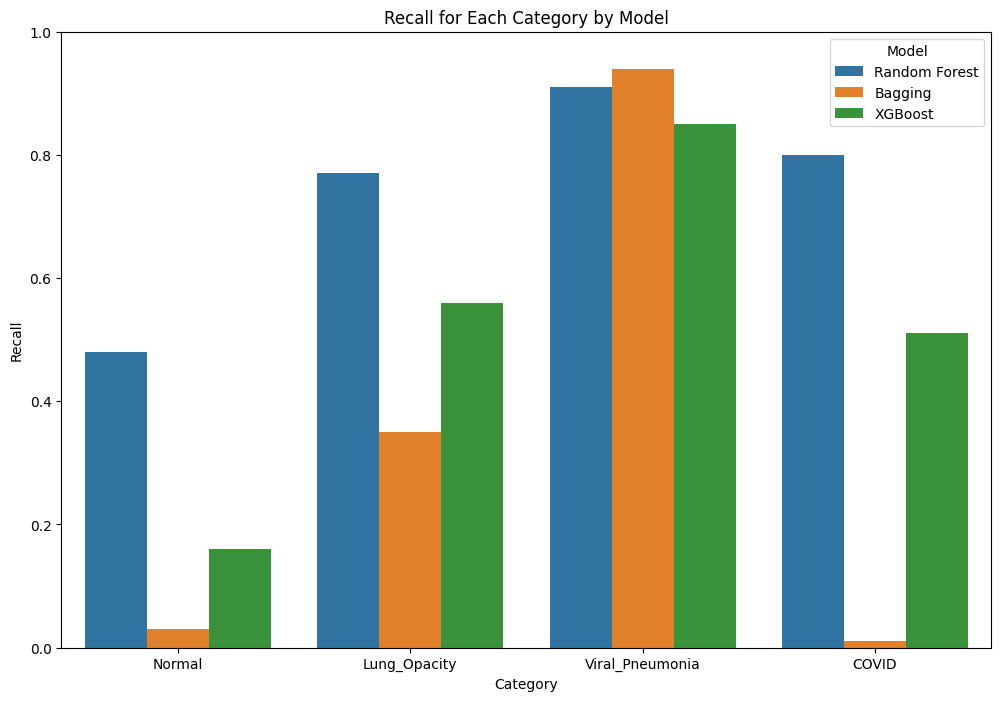

In [35]:
# Melting the DataFrame for recall values
recall_df = summary_classification_filtered_df.melt(id_vars=['Model'], 
                                                    value_vars=[f'Recall_{category}' for category in categories],
                                                    var_name='Metric', value_name='Value')

recall_df['Metric'] = recall_df['Metric'].str.replace('Recall_', '')

# Plotting Recall
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=recall_df)
plt.title('Recall for Each Category by Model')
plt.ylabel('Recall')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

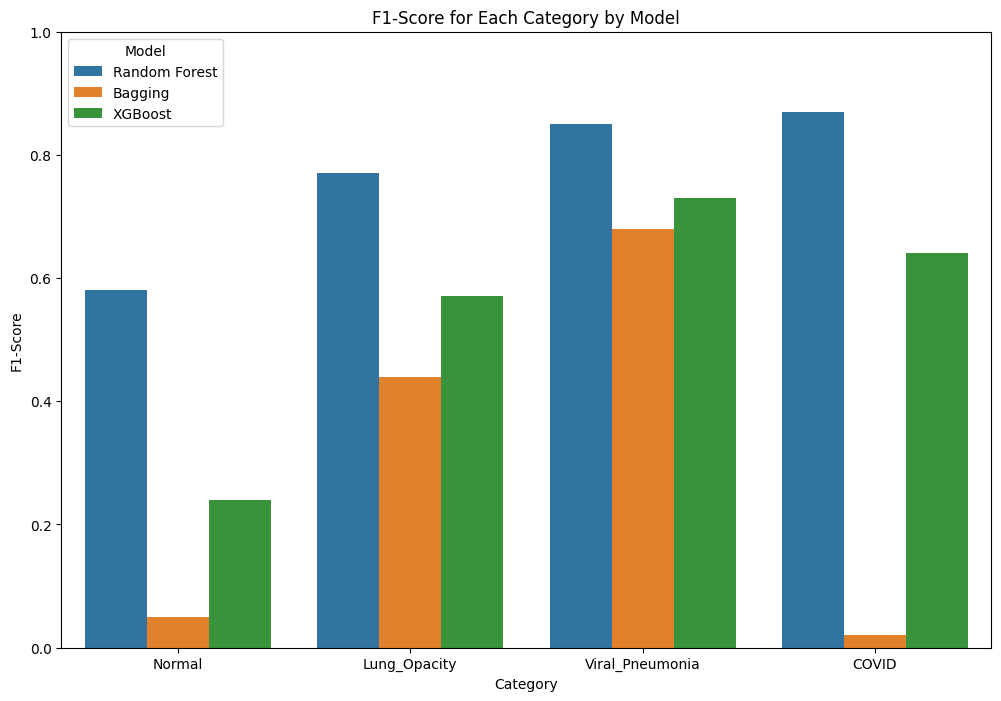

In [36]:
# Melting the DataFrame for F1-score values
f1_score_df = summary_classification_filtered_df.melt(id_vars=['Model'], 
                                                      value_vars=[f'F1-Score_{category}' for category in categories],
                                                      var_name='Metric', value_name='Value')

f1_score_df['Metric'] = f1_score_df['Metric'].str.replace('F1-Score_', '')

# Plotting F1-Score
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Model', data=f1_score_df)
plt.title('F1-Score for Each Category by Model')
plt.ylabel('F1-Score')
plt.xlabel('Category')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.show()

#### Calculation and visualization of ROC curves for ROI + Filters

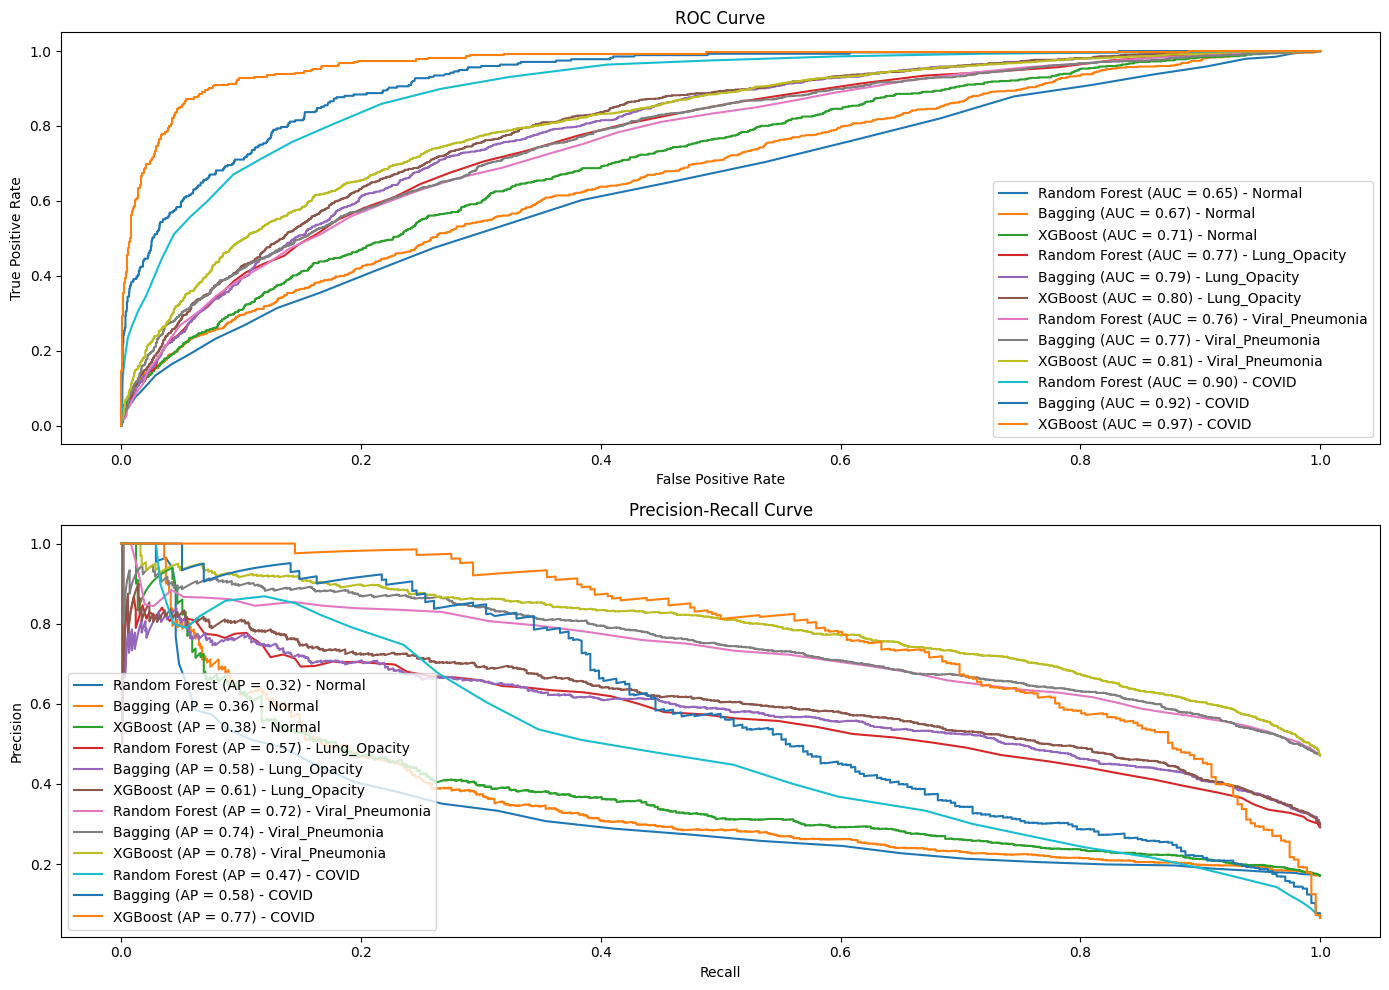

In [73]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Get predicted probabilities
rf_y_prob = rf_classifier_filtered.predict_proba(X_filtered_test_scaled)
bagging_y_prob = bagging_classifier_filtered.predict_proba(X_filtered_test_scaled)
xgb_y_prob = xgb_classifier_filtered.predict_proba(X_filtered_test_scaled)

# Initialize plots for ROC and PR curves
plt.figure(figsize=(14, 10))

# Calculate ROC and PR curves for each class
for i, category in enumerate(categories):
    # Random Forest
    rf_fpr, rf_tpr, _ = roc_curve(y_filtered_test_encoded == i, rf_y_prob[:, i])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    rf_precision, rf_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, rf_y_prob[:, i])
    rf_average_precision = average_precision_score(y_filtered_test_encoded == i, rf_y_prob[:, i])

    # Bagging Classifier
    bagging_fpr, bagging_tpr, _ = roc_curve(y_filtered_test_encoded == i, bagging_y_prob[:, i])
    bagging_roc_auc = auc(bagging_fpr, bagging_tpr)
    bagging_precision, bagging_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, bagging_y_prob[:, i])
    bagging_average_precision = average_precision_score(y_filtered_test_encoded == i, bagging_y_prob[:, i])

    # XGBoost
    xgb_fpr, xgb_tpr, _ = roc_curve(y_filtered_test_encoded == i, xgb_y_prob[:, i])
    xgb_roc_auc = auc(xgb_fpr, xgb_tpr)
    xgb_precision, xgb_recall, _ = precision_recall_curve(y_filtered_test_encoded == i, xgb_y_prob[:, i])
    xgb_average_precision = average_precision_score(y_filtered_test_encoded == i, xgb_y_prob[:, i])

    # Plot ROC curve
    plt.subplot(2, 1, 1)
    plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.2f}) - {category}')
    plt.plot(bagging_fpr, bagging_tpr, label=f'Bagging (AUC = {bagging_roc_auc:.2f}) - {category}')
    plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_roc_auc:.2f}) - {category}')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')

    # Plot PR curve
    plt.subplot(2, 1, 2)
    plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_average_precision:.2f}) - {category}')
    plt.plot(bagging_recall, bagging_precision, label=f'Bagging (AP = {bagging_average_precision:.2f}) - {category}')
    plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AP = {xgb_average_precision:.2f}) - {category}')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()



#### Calculation and visualization of Feature Importances for ROI + Filters

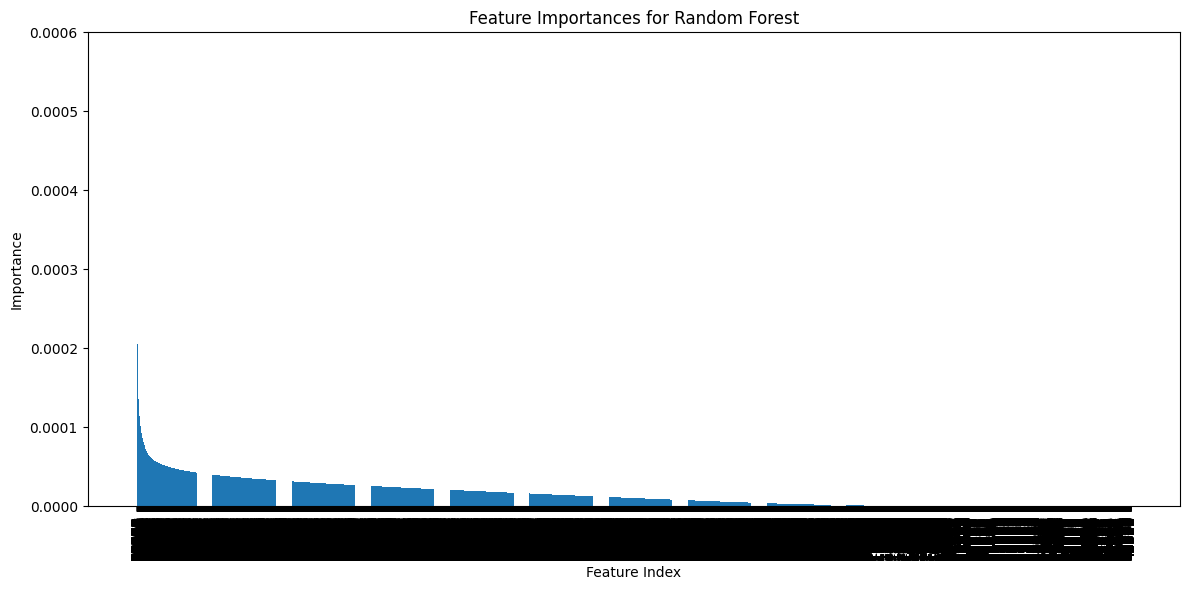

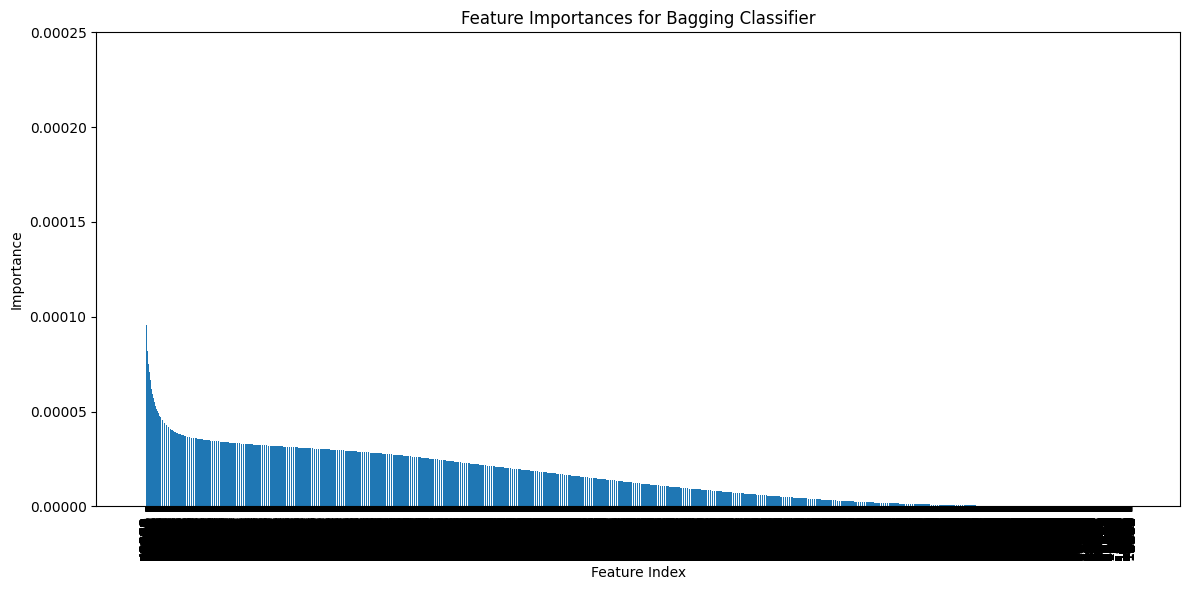

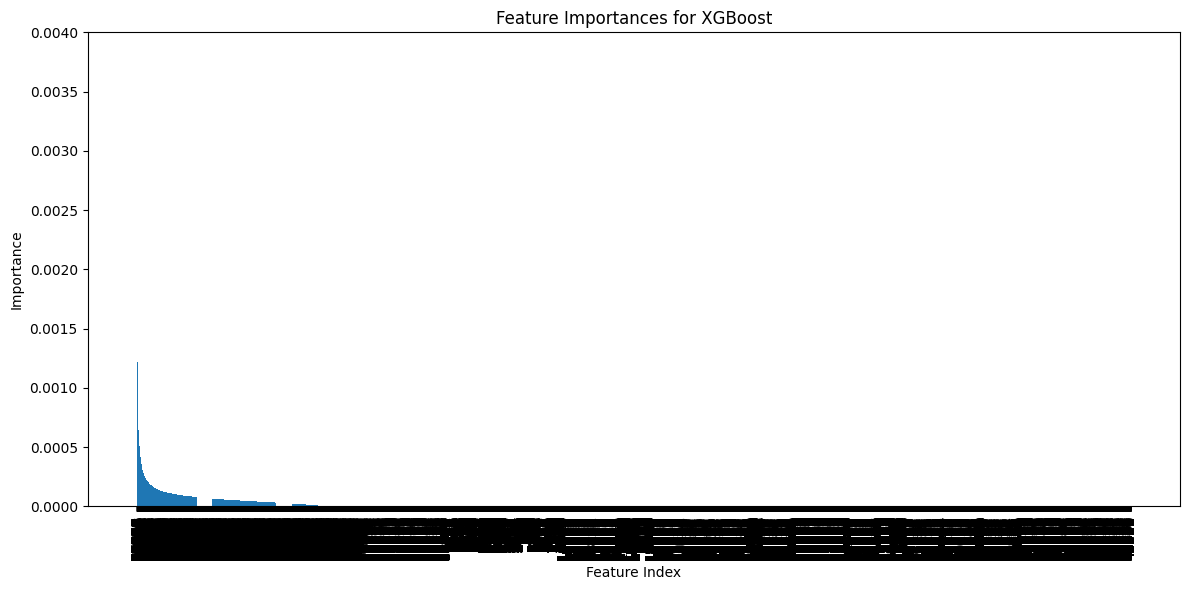

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

# predicted probabilities
rf_y_prob = rf_classifier_filtered.predict_proba(X_filtered_test_scaled)
bagging_y_prob = bagging_classifier_filtered.predict_proba(X_filtered_test_scaled)
xgb_y_prob = xgb_classifier_filtered.predict_proba(X_filtered_test_scaled)

# Feature Importances for Random Forest and Bagging Classifier
models = {
    'Random Forest': rf_classifier_filtered,
    'Bagging Classifier': bagging_classifier_filtered
}

for model_name, model in models.items():
    if model_name == 'Random Forest':
        importances = model.feature_importances_
        ylim = (0, 0.0006)
    elif model_name == 'Bagging Classifier':
        importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
        ylim = (0, 0.00025)
    else:
        continue

    indices = np.argsort(importances)[::-1]
    features = X_filtered_train.columns  # Use the original DataFrame to get feature names

    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importances for {model_name}')
    plt.bar(range(X_filtered_train.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_filtered_train.shape[1]), features[indices], rotation=90)
    plt.ylim(ylim)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

# Feature Importances for XGBoost
xgb_importances = xgb_classifier_filtered.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
features = X_filtered_train.columns  # Use the original DataFrame to get feature names

plt.figure(figsize=(12, 6))
plt.title('Feature Importances for XGBoost')
plt.bar(range(X_filtered_train.shape[1]), xgb_importances[indices], align='center')
plt.xticks(range(X_filtered_train.shape[1]), features[indices], rotation=90)
plt.ylim(0, 0.004)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
